In [1]:
    import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
import NegativeClassOptimization.config as config
import NegativeClassOptimization.datasets as datasets
from NegativeClassOptimization.preprocessing import onehot_encode_df, get_one_hot_aa_encoder
from captum.attr import IntegratedGradients
from modif_utils import *
import torch.optim as optim

In [2]:
from sklearn.model_selection import train_test_split
import re

In [12]:
from itertools import permutations

In [3]:
ONE_VS_ALL_PATH = Path('../data/full_data/1_vs_all')
PAIRWISE_HIGH_PATH = Path('../data/full_data/high_pairwise')
HIGH_LOW_PATH = Path('../data/full_data/high_low_concat')

In [4]:
class MLP_2L(nn.Module):
    """The simple neural network 10 (SN10) model from `Absolut!`.
    """

    def __init__(self, neurons_1, neurons_2, normalize = False):
        super(MLP_2L, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11*20, neurons_1),
            nn.ReLU(),
            nn.Linear(neurons_1, neurons_2),
            nn.ReLU(),
            nn.Linear(neurons_2, 1),
        )
        self.normalize = normalize 
        if self.normalize:
            self.norm = UnitNormLayer()
        self.sigmoid = nn.Sigmoid()

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def forward(
        self, 
        x: torch.Tensor, 
        return_logits = False
        ):
        logits = self.forward_logits(x)
        if self.normalize:
            logits = self.norm(logits)
        expits = self.sigmoid(logits)
        if return_logits:
            return expits, logits
        else:
            return expits

In [5]:
def train_mlp(model, device, train_loader, val_loader, saving_folder, file_name, epochs=100, learning_rate = 0.002, momentum = 0, weight_decay = 0, patience = 10, min_delta = 0.005):


    optimizer = torch.optim.Adam(
                model.parameters(), 
                lr=learning_rate,
                weight_decay=weight_decay,
                )
    loss_fn = nn.BCELoss()

    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        #train
        running_loss = []
        for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            X = X.to(device)
            y = y.to(device)
            y_pred, logits = model(X, return_logits = True)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        train_loss = np.mean(running_loss)
        train_losses.append(float(train_loss))

        #validation
        running_loss = []
        with torch.no_grad():
            validation_loss = []
            for batch, (X,y) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
                X = X.to(device)
                y = y.to(device)
                y_pred = model(X)
                running_loss.append(loss_fn(y_pred, y).cpu().detach().numpy())
            val_loss = np.mean(running_loss) 
            val_losses.append(float(val_loss))
        print(f"Epoch: {epoch+1}/{epochs} - Train loss: {train_loss}, Validation loss: {val_loss}") #save to log-file
        with open(f'./logs/{file_name}.txt', 'a') as log:
            log.write(f"Epoch: {epoch+1}/{epochs} - Train loss: {train_loss}, Validation loss: {val_loss}\n")

        #alternative early stopping
        if len(val_losses) >= patience:
            last_losses = val_losses[-patience:]
            max_loss = max(last_losses)
            min_loss = min(last_losses)
            if min_loss + min_delta >= max_loss:
                print("Early stopping") #save-to log file
                #save train_losses and val_losses to log file
                #save the model
                break
    with open(f'./logs/{file_name}_train_val_losses.json', 'w') as f:
        json.dump([train_losses, val_losses], f)
    torch.save(model.state_dict(), f'./torch_models/{saving_folder}/{file_name}.pt')



In [6]:
def compute_binary_metrics(y_test_pred, y_test_true) -> dict:
    acc = metrics.accuracy_score(y_true=y_test_true, y_pred=y_test_pred)
    recall= metrics.recall_score(y_true=y_test_true, y_pred=y_test_pred)
    prec = metrics.precision_score(y_true=y_test_true, y_pred=y_test_pred)
    f1 = metrics.f1_score(y_true=y_test_true, y_pred=y_test_pred)
    return [acc, recall, prec, f1]

In [42]:
def test_loop(model, X, y, compute_merics = True):
    loss_fn = nn.BCELoss()
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred, logits = model(X, return_logits = True)
        loss = loss_fn(y_pred, y).cpu().detach().numpy()
        performance = [loss]
    if compute_merics:
        y_pred = y_pred.cpu().detach().numpy().reshape(-1).round()
        y = y.cpu().detach().numpy()
        performance = performance + compute_binary_metrics(y_pred, y)
    return performance

In [8]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [9]:
one_vs_all_paths = glob.glob(str(Path(ONE_VS_ALL_PATH)) + "/[0-9A-Z]*")

In [14]:
architectures = list(permutations(np.arange(2,7), 2)) + [(i,i) for i in range(2,7)]

In [15]:
one_vs_all_paths[1]

'../data/full_data/1_vs_all/1ADQ_vs_all.tsv'

In [16]:
replicates = 5
batch_size = 100
dataset = one_vs_all_paths[1]
file = dataset.split('/')[-1].strip('.tsv')
df = pd.read_csv(dataset, sep='\t')
train_one_all, val_one_all,  test_one_all = train_val_test_prep(df, scale = False)
train_loader = DataLoader(train_one_all, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_one_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_one_all, batch_size=batch_size, shuffle=True)
for arc in architectures:
    for i in range(1, replicates+1):
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        layer1 = arc[0]
        layer2 = arc[1]
        model = MLP_2L(layer1,layer2).to(device)
        print(f'Architecture {arc}')
        train_mlp(model, device, train_loader, val_loader, 'MLP_2L_1_vs_all', f'{file}_layers_{layer1}_{layer2}_repl_{i}', epochs=200)

Architecture (2, 3)


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6032971739768982, Validation loss: 0.5294925570487976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.5135217308998108, Validation loss: 0.5065164566040039


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.497580885887146, Validation loss: 0.4944959580898285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4833802282810211, Validation loss: 0.479805052280426


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.467306911945343, Validation loss: 0.4656974673271179


Training:   0%|          | 0/275 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
models_path = glob.glob('./torch_models/MLP_2L_1_vs_all/1ADQ_vs_all_layers_' + '[0-9]_[0-9]_repl_[0-9].pt')

In [ ]:
#def get_perf_df(antigens, moedls_folder, file_fstr, open_path, closed_path, model)

In [43]:
def get_open_closed_dataloader(open_path, closed_path):
    df_open = pd.read_csv(open_path, sep='\t') #HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    df_open = df_open[df_open['Train'] == False].reset_index(drop =True)
    df_open = dataset_preprosessing(df_open)
    open_dataloader = DataLoader(df_open, batch_size=df_open.__len__(), shuffle=True)
    
    df_closed = pd.read_csv(closed_path, sep='\t')#ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    df_closed = df_closed[df_closed['Train'] == False].reset_index(drop =True)
    df_closed = dataset_preprosessing(df_closed)
    closed_dataloader = DataLoader(df_closed, batch_size=df_closed.__len__(), shuffle=True)
    return open_dataloader, closed_dataloader

In [44]:
def get_open_closed_perf(model, open_dataloader, closed_dataloader):
    open_performance = dict()
    for batch, (X, y) in enumerate(open_dataloader): 
        open_performance = test_loop(model, X, y)
    open_performance[0] = float(np.mean(open_performance[0]))
        
    closed_performance = dict()
    for batch, (X, y) in enumerate(closed_dataloader): 
        closed_performance = test_loop(model, X, y)
    closed_performance[0] = float(np.mean(closed_performance[0])) 

    return open_performance, closed_performance
    

In [49]:
models_folder = 'MLP_2L_1_vs_all'
fstr_file = 'vs_all_layers_[0-9]_[0-9]_repl_[0-9].pt'
var_col = "[f'{l1}_{l2}']"
var_col_name = ['architecture']
ags = ['1ADQ']
list_4_df = []

for ag in ags:
    models = glob.glob(f'./torch_models/{models_folder}/{ag}_{fstr_file}')
    open_path = HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    closed_path = ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    open_dataloader, closed_dataloader = get_open_closed_dataloader(open_path, closed_path)
    for model_path in models:
        
        #what is variable in the model !CHANGABLE
        l1, l2 = re.search('layers_([0-9])_([0-9])',model_path.split('/')[-1]).groups()
        l1, l2 = int(l1), int(l2)
        
        #model definition !CHANGABLE
        model = MLP_2L(l1, l2)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        #get repl number
        repl = model_path.split('/')[-1]
        repl = re.search('\.*_repl_(\d*)', repl).group(1)
        
        open_performance, closed_performance = get_open_closed_perf(model, open_dataloader, closed_dataloader)
        list_4_df.append([ag, 'open', repl] + eval(var_col) + open_performance)
        list_4_df.append([ag, 'closed', repl] + eval(var_col) + closed_performance)

performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl'] + var_col_name +['loss', 'acc', 'recall', 'prec', 'f1'])

In [50]:
performance_df.head()

,ag,test type,repl,architecture,loss,acc,recall,prec,f1
0,1ADQ,open,3,6_5,1.434199,0.751088,0.896327,0.694570,0.782655
1,1ADQ,closed,3,6_5,0.264948,0.901729,0.896327,0.906190,0.901231
2,1ADQ,open,2,3_5,0.714855,0.734966,0.848571,0.691463,0.762004
3,1ADQ,closed,2,3_5,0.384473,0.829386,0.848571,0.817324,0.832655
4,1ADQ,open,5,4_5,0.767553,0.765102,0.895238,0.710353,0.792151


In [51]:
performance_df6 = performance_df[performance_df['architecture'].isin(['6_2', '6_3', '6_4', '6_5', '6_6'])]

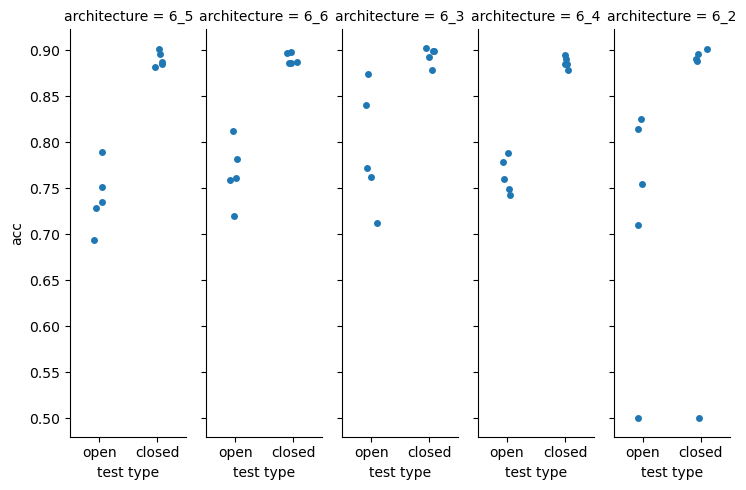

In [52]:
sns.catplot(performance_df6, x ='test type', y ='acc', col='architecture', aspect=0.3)

In [53]:
performance_df5 = performance_df[performance_df['architecture'].isin(['5_2', '5_3', '5_4', '5_5', '5_6'])]

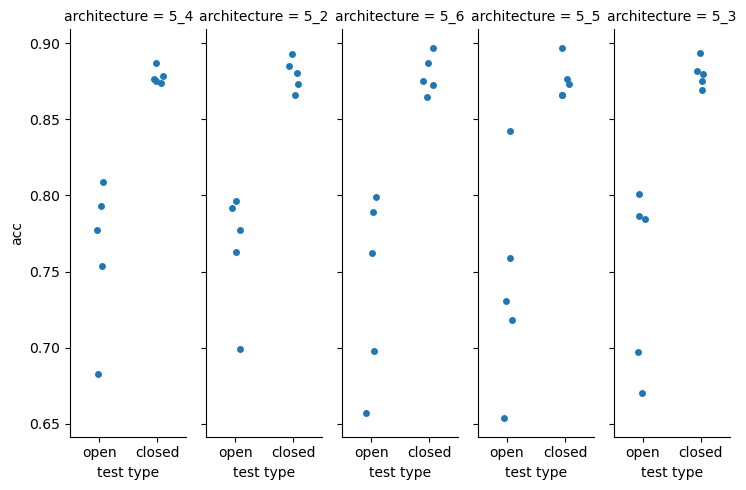

In [54]:
sns.catplot(performance_df5, x ='test type', y ='acc', col='architecture', aspect=0.3)

In [55]:
closed_perf = performance_df[performance_df['test type'] == 'closed'].groupby('architecture').mean()

In [56]:
open_perf = performance_df[performance_df['test type'] == 'open'].groupby('architecture').mean()

In [57]:
open_perf.sort_values('acc', axis = 0)

,loss,acc,recall,prec,f1
architecture,,,,,
2_3,0.686043,0.675687,0.846259,0.650046,0.727332
2_5,0.724372,0.690286,0.774340,0.663880,0.714398
2_2,0.616465,0.692531,0.872136,0.661923,0.744947
2_6,0.749951,0.697864,0.837469,0.657038,0.735565
3_5,0.775007,0.707184,0.850612,0.662406,0.744352
4_2,0.791686,0.711347,0.864381,0.662293,0.749701
2_4,0.691998,0.715932,0.794639,0.687322,0.736583
3_2,0.546890,0.719442,0.890204,0.687235,0.767665
3_3,0.727972,0.720136,0.842639,0.679658,0.751514


In [58]:
closed_perf.sort_values('acc', axis = 0)

,loss,acc,recall,prec,f1
architecture,,,,,
2_3,0.479881,0.744372,0.846259,0.744579,0.778065
2_2,0.476537,0.746522,0.872136,0.732663,0.784757
3_2,0.443288,0.768545,0.890204,0.755048,0.805406
2_6,0.426448,0.794964,0.837469,0.772968,0.803566
2_5,0.427739,0.804777,0.774340,0.826362,0.797258
2_4,0.423748,0.808589,0.794639,0.819928,0.805502
6_2,0.356214,0.815517,0.923701,0.809302,0.849702
3_4,0.383544,0.832898,0.825469,0.838644,0.831428
3_5,0.367127,0.837879,0.850612,0.829834,0.840026


In [65]:
class SN_n(nn.Module):


    def __init__(self, neurons_1, normalize = False):
        super(SN_n, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11*20, neurons_1),
            nn.ReLU(),
            nn.Linear(neurons_1, 1),
        )
        self.normalize = normalize 
        if self.normalize:
            self.norm = UnitNormLayer()
        self.sigmoid = nn.Sigmoid()

    def forward_logits(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def forward(
        self, 
        x: torch.Tensor, 
        return_logits = False
        ):
        logits = self.forward_logits(x)
        if self.normalize:
            logits = self.norm(logits)
        expits = self.sigmoid(logits)
        if return_logits:
            return expits, logits
        else:
            return expits

In [98]:
replicates = 5
batch_size = 100
dataset = one_vs_all_paths[1]
file = dataset.split('/')[-1].strip('.tsv')
df = pd.read_csv(dataset, sep='\t')
train_one_all, val_one_all,  test_one_all = train_val_test_prep(df, scale = False)
train_loader = DataLoader(train_one_all, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_one_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_one_all, batch_size=batch_size, shuffle=True)
for arc in np.arange(7,11):
    for i in range(1, replicates+1):
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        model = SN_n(arc).to(device)
        print(f'Architecture {arc}')
        train_mlp(model, device, train_loader, 'SN_n_1_vs_all', f'{file}_layers_{arc}_repl_{i}', epochs=200)

Architecture 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5631846785545349, Validation loss: 0.4822101294994354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4517561197280884, Validation loss: 0.44530218839645386


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.42052483558654785, Validation loss: 0.4245917499065399


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.39613571763038635, Validation loss: 0.40461573004722595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.37371858954429626, Validation loss: 0.38539907336235046


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3537224233150482, Validation loss: 0.36917930841445923


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.33711057901382446, Validation loss: 0.3569265604019165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3236202895641327, Validation loss: 0.345172643661499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3120342493057251, Validation loss: 0.336098849773407


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3024362027645111, Validation loss: 0.33024200797080994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.29452550411224365, Validation loss: 0.32229137420654297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.28786200284957886, Validation loss: 0.31540781259536743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.28127190470695496, Validation loss: 0.31182584166526794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.27468007802963257, Validation loss: 0.3075112998485565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2688659131526947, Validation loss: 0.3037867546081543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.264358788728714, Validation loss: 0.2967471182346344


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2597966492176056, Validation loss: 0.29167357087135315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2551014721393585, Validation loss: 0.2893918752670288


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.25205662846565247, Validation loss: 0.28924819827079773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.24803683161735535, Validation loss: 0.2846660017967224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.24481390416622162, Validation loss: 0.28158867359161377


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.24154798686504364, Validation loss: 0.2803943455219269


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.23896579444408417, Validation loss: 0.2780446410179138


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.23680394887924194, Validation loss: 0.2777203917503357


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.234513521194458, Validation loss: 0.27598506212234497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.23274829983711243, Validation loss: 0.2712880074977875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2303704023361206, Validation loss: 0.2728700041770935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.22909925878047943, Validation loss: 0.27134066820144653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2273806929588318, Validation loss: 0.26989415287971497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.2265254557132721, Validation loss: 0.2708451449871063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.22458577156066895, Validation loss: 0.26916009187698364


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.22336263954639435, Validation loss: 0.26980847120285034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.22173941135406494, Validation loss: 0.2702234983444214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.22113637626171112, Validation loss: 0.2685737609863281


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.21956057846546173, Validation loss: 0.26697367429733276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.21892477571964264, Validation loss: 0.26857995986938477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2181088775396347, Validation loss: 0.2661556899547577


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.21773238480091095, Validation loss: 0.2682207226753235
Early stopping
Architecture 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5501201748847961, Validation loss: 0.48118719458580017


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45017218589782715, Validation loss: 0.44131049513816833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4155895411968231, Validation loss: 0.41700485348701477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3883321285247803, Validation loss: 0.3944128453731537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3658794164657593, Validation loss: 0.3765310049057007


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.34587040543556213, Validation loss: 0.36215338110923767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.32917657494544983, Validation loss: 0.3491393029689789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.31468483805656433, Validation loss: 0.3393572270870209


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3043021857738495, Validation loss: 0.33261263370513916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2955930531024933, Validation loss: 0.32541751861572266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2881467640399933, Validation loss: 0.32509157061576843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.28180214762687683, Validation loss: 0.3150938153266907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.27641215920448303, Validation loss: 0.3129459619522095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2713826596736908, Validation loss: 0.31091824173927307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.26758232712745667, Validation loss: 0.30875587463378906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2639361023902893, Validation loss: 0.3058154284954071


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2617393136024475, Validation loss: 0.30435484647750854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.25793367624282837, Validation loss: 0.30329012870788574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.254899799823761, Validation loss: 0.3003827929496765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.25343504548072815, Validation loss: 0.29961031675338745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.25134316086769104, Validation loss: 0.2986420691013336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.24948669970035553, Validation loss: 0.2968622148036957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.24845097959041595, Validation loss: 0.2978072762489319


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.24608628451824188, Validation loss: 0.3005675673484802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.24490778148174286, Validation loss: 0.29890069365501404


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.24387986958026886, Validation loss: 0.2979590594768524


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.24258916079998016, Validation loss: 0.2990171015262604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.24100323021411896, Validation loss: 0.29558539390563965
Early stopping
Architecture 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5531072020530701, Validation loss: 0.48442697525024414


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45790183544158936, Validation loss: 0.4477249085903168


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4267500340938568, Validation loss: 0.42617419362068176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4034072458744049, Validation loss: 0.4051862061023712


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3804943859577179, Validation loss: 0.38715052604675293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3591125011444092, Validation loss: 0.36900225281715393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.339422345161438, Validation loss: 0.35392001271247864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.32259073853492737, Validation loss: 0.33975663781166077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.30806609988212585, Validation loss: 0.32913416624069214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2967087924480438, Validation loss: 0.3232599198818207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2877601087093353, Validation loss: 0.31717929244041443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2800576984882355, Validation loss: 0.30831053853034973


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2735297977924347, Validation loss: 0.3039962947368622


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.26819080114364624, Validation loss: 0.2994464039802551


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.26391470432281494, Validation loss: 0.2964631915092468


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.25923478603363037, Validation loss: 0.2945861220359802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2551245391368866, Validation loss: 0.2932664752006531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.25182685256004333, Validation loss: 0.2952220141887665


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24917203187942505, Validation loss: 0.2878178656101227


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.24637922644615173, Validation loss: 0.2861424684524536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.24338434636592865, Validation loss: 0.28707578778266907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.24149197340011597, Validation loss: 0.2849445044994354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.23904937505722046, Validation loss: 0.28231894969940186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.23759698867797852, Validation loss: 0.28361913561820984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2361268252134323, Validation loss: 0.28303730487823486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.23397202789783478, Validation loss: 0.282431960105896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2324874848127365, Validation loss: 0.28010863065719604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.23064710199832916, Validation loss: 0.2823651432991028


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2301206886768341, Validation loss: 0.2808120846748352


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.228583425283432, Validation loss: 0.27906742691993713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.227298304438591, Validation loss: 0.27853724360466003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.22589050233364105, Validation loss: 0.27640610933303833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.22524550557136536, Validation loss: 0.2757265567779541


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.22395499050617218, Validation loss: 0.2757848799228668


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.22259913384914398, Validation loss: 0.2751399576663971


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.22120234370231628, Validation loss: 0.27397000789642334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.22035124897956848, Validation loss: 0.27175572514533997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.21948042511940002, Validation loss: 0.2729155123233795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.21896281838417053, Validation loss: 0.271501749753952


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.21793967485427856, Validation loss: 0.27087438106536865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.21655595302581787, Validation loss: 0.2741301357746124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.2162429839372635, Validation loss: 0.2687097489833832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.2155790776014328, Validation loss: 0.2712048292160034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.2142171859741211, Validation loss: 0.2689286768436432


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.21355722844600677, Validation loss: 0.2699733078479767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.21315880119800568, Validation loss: 0.2685774266719818


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.21263238787651062, Validation loss: 0.268269419670105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.2115563452243805, Validation loss: 0.26807671785354614


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.21069735288619995, Validation loss: 0.266791433095932


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.2105354517698288, Validation loss: 0.267848402261734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.20931249856948853, Validation loss: 0.2664690315723419
Early stopping
Architecture 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5609528422355652, Validation loss: 0.4888703227043152


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45233631134033203, Validation loss: 0.44050756096839905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41025829315185547, Validation loss: 0.4104388952255249


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3792892098426819, Validation loss: 0.3858261704444885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3544180691242218, Validation loss: 0.3647325336933136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3320149779319763, Validation loss: 0.34532833099365234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.31304335594177246, Validation loss: 0.33333930373191833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.29824352264404297, Validation loss: 0.32337653636932373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2874812185764313, Validation loss: 0.31500816345214844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2786586284637451, Validation loss: 0.30989813804626465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.27124807238578796, Validation loss: 0.3054512143135071


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.26583269238471985, Validation loss: 0.2986999452114105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2602311968803406, Validation loss: 0.29601743817329407


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.25570544600486755, Validation loss: 0.2940877377986908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.25189292430877686, Validation loss: 0.29054003953933716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.24818062782287598, Validation loss: 0.2881876826286316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.24591901898384094, Validation loss: 0.2852456867694855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24293312430381775, Validation loss: 0.2845262587070465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24111968278884888, Validation loss: 0.28381142020225525


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23851335048675537, Validation loss: 0.28450876474380493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.23707892000675201, Validation loss: 0.2806641161441803


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.23528334498405457, Validation loss: 0.28070268034935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.23421896994113922, Validation loss: 0.2809978127479553


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.23265311121940613, Validation loss: 0.28024500608444214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.23101507127285004, Validation loss: 0.279888778924942


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.22941134870052338, Validation loss: 0.28006264567375183


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2285286784172058, Validation loss: 0.2795834243297577
Early stopping
Architecture 7


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.557839572429657, Validation loss: 0.48659637570381165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4531231224536896, Validation loss: 0.4378044307231903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4110510051250458, Validation loss: 0.40650948882102966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38236382603645325, Validation loss: 0.38620883226394653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3628952205181122, Validation loss: 0.3731359839439392


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.346832275390625, Validation loss: 0.36291855573654175


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.33143559098243713, Validation loss: 0.3514883518218994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3170875608921051, Validation loss: 0.3385156989097595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.30352890491485596, Validation loss: 0.3292434513568878


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.29180023074150085, Validation loss: 0.3214403986930847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.28219693899154663, Validation loss: 0.31933510303497314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.27449357509613037, Validation loss: 0.3129667639732361


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.26772239804267883, Validation loss: 0.3089121878147125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2620515525341034, Validation loss: 0.30565783381462097


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.25706836581230164, Validation loss: 0.30319952964782715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.25319141149520874, Validation loss: 0.3008819818496704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2482207715511322, Validation loss: 0.3002174496650696


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24495816230773926, Validation loss: 0.29851487278938293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24244917929172516, Validation loss: 0.2967568039894104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23911668360233307, Validation loss: 0.2932155132293701


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.23727603256702423, Validation loss: 0.2912651300430298


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.23490875959396362, Validation loss: 0.2885429263114929


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.23285642266273499, Validation loss: 0.2889646589756012


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.23091411590576172, Validation loss: 0.287664532661438


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.22955645620822906, Validation loss: 0.2862241864204407


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.22915685176849365, Validation loss: 0.28449469804763794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.22694139182567596, Validation loss: 0.28418514132499695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.22559309005737305, Validation loss: 0.2824433147907257


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.22533799707889557, Validation loss: 0.2833661437034607


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.22428013384342194, Validation loss: 0.28336235880851746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.22346705198287964, Validation loss: 0.28466761112213135


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.22274251282215118, Validation loss: 0.28413549065589905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.22125652432441711, Validation loss: 0.28432971239089966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.22105009853839874, Validation loss: 0.2819320261478424
Early stopping
Architecture 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5541536808013916, Validation loss: 0.49358120560646057


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4655866026878357, Validation loss: 0.4536777436733246


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4299294352531433, Validation loss: 0.4226880967617035


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3963836133480072, Validation loss: 0.3911154866218567


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3644925653934479, Validation loss: 0.3641470968723297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3367331326007843, Validation loss: 0.34422892332077026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3147053122520447, Validation loss: 0.3262619972229004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.297664999961853, Validation loss: 0.31391143798828125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2838071584701538, Validation loss: 0.3040434420108795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.27301859855651855, Validation loss: 0.2972739338874817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.26424187421798706, Validation loss: 0.29074499011039734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2573005259037018, Validation loss: 0.2896730601787567


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2509450912475586, Validation loss: 0.28380638360977173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.24615156650543213, Validation loss: 0.2804977595806122


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2411927878856659, Validation loss: 0.2761102318763733


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.23768161237239838, Validation loss: 0.274513840675354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.23448827862739563, Validation loss: 0.27399054169654846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.23162810504436493, Validation loss: 0.27292099595069885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.22899536788463593, Validation loss: 0.27247488498687744


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22695691883563995, Validation loss: 0.27025753259658813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22402529418468475, Validation loss: 0.2696763575077057


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22196513414382935, Validation loss: 0.26999589800834656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22073794901371002, Validation loss: 0.2692083716392517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2190631628036499, Validation loss: 0.2669707238674164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2173876315355301, Validation loss: 0.2679683268070221


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2163643091917038, Validation loss: 0.26847317814826965


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21446125209331512, Validation loss: 0.26858091354370117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21430420875549316, Validation loss: 0.26795339584350586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.21240359544754028, Validation loss: 0.26820963621139526
Early stopping
Architecture 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.553614616394043, Validation loss: 0.48517486453056335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45764124393463135, Validation loss: 0.44790807366371155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4223025441169739, Validation loss: 0.41765642166137695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38763752579689026, Validation loss: 0.3879871070384979


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.35397326946258545, Validation loss: 0.35699018836021423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32372909784317017, Validation loss: 0.33468419313430786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3010060787200928, Validation loss: 0.3183383345603943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28189989924430847, Validation loss: 0.30428197979927063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2681199014186859, Validation loss: 0.29479530453681946


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25765931606292725, Validation loss: 0.2900797724723816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2484528124332428, Validation loss: 0.286708801984787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2422655075788498, Validation loss: 0.2798224091529846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23587483167648315, Validation loss: 0.2770566940307617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23082822561264038, Validation loss: 0.27427592873573303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22681677341461182, Validation loss: 0.2703084945678711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.22328497469425201, Validation loss: 0.26957979798316956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21909673511981964, Validation loss: 0.2683084309101105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21643297374248505, Validation loss: 0.2667451500892639


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.21358120441436768, Validation loss: 0.266149640083313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.21180832386016846, Validation loss: 0.26538193225860596


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20933182537555695, Validation loss: 0.26232966780662537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.20682993531227112, Validation loss: 0.26143234968185425


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20513857901096344, Validation loss: 0.2619144320487976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.20312152802944183, Validation loss: 0.25927504897117615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.20193800330162048, Validation loss: 0.25971972942352295


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.19986781477928162, Validation loss: 0.2597317397594452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.19820895791053772, Validation loss: 0.25716227293014526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19687587022781372, Validation loss: 0.25996842980384827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1959797590970993, Validation loss: 0.2585781514644623


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.19469690322875977, Validation loss: 0.2566959261894226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.19350607693195343, Validation loss: 0.25723370909690857


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1925298273563385, Validation loss: 0.26069191098213196


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.19122189283370972, Validation loss: 0.25708097219467163
Early stopping
Architecture 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5517871379852295, Validation loss: 0.48448580503463745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4487224817276001, Validation loss: 0.43567243218421936


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40643367171287537, Validation loss: 0.4021625816822052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37512922286987305, Validation loss: 0.3788946270942688


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.350419819355011, Validation loss: 0.36067643761634827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3307859003543854, Validation loss: 0.3473983108997345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.31419482827186584, Validation loss: 0.33577099442481995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.30182451009750366, Validation loss: 0.3267718255519867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2914458215236664, Validation loss: 0.318803608417511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2819529175758362, Validation loss: 0.31170281767845154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.27473604679107666, Validation loss: 0.307050496339798


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2676766812801361, Validation loss: 0.30299440026283264


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2614959478378296, Validation loss: 0.29891514778137207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.255719393491745, Validation loss: 0.2956964075565338


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.25164535641670227, Validation loss: 0.2917352020740509


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.24703744053840637, Validation loss: 0.2900116741657257


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.24403411149978638, Validation loss: 0.29071757197380066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.23976869881153107, Validation loss: 0.28558915853500366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.23656971752643585, Validation loss: 0.2833947539329529


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23244178295135498, Validation loss: 0.27900397777557373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22955726087093353, Validation loss: 0.2782796621322632


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2276618331670761, Validation loss: 0.2756967544555664


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22484378516674042, Validation loss: 0.27777791023254395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22309981286525726, Validation loss: 0.27636364102363586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.22099947929382324, Validation loss: 0.27221018075942993


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21927453577518463, Validation loss: 0.2724725902080536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21759241819381714, Validation loss: 0.27086907625198364


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21662089228630066, Validation loss: 0.27113252878189087


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.21481113135814667, Validation loss: 0.270493745803833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.21317867934703827, Validation loss: 0.27003243565559387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.21213503181934357, Validation loss: 0.27138376235961914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.21118701994419098, Validation loss: 0.2713346481323242


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.21084491908550262, Validation loss: 0.26964038610458374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.20967771112918854, Validation loss: 0.27143701910972595
Early stopping
Architecture 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5532160997390747, Validation loss: 0.48996955156326294


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.46493491530418396, Validation loss: 0.4563004970550537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.43431273102760315, Validation loss: 0.43307554721832275


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.40791553258895874, Validation loss: 0.40813153982162476


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.38080742955207825, Validation loss: 0.38230952620506287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3548831343650818, Validation loss: 0.3623300790786743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3315645754337311, Validation loss: 0.34353575110435486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3118264079093933, Validation loss: 0.32981255650520325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.29621627926826477, Validation loss: 0.31727442145347595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2838684320449829, Validation loss: 0.31023192405700684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2732350826263428, Validation loss: 0.30241936445236206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2650456726551056, Validation loss: 0.2989458441734314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2591308653354645, Validation loss: 0.2968390882015228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2531391978263855, Validation loss: 0.29511409997940063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.24850589036941528, Validation loss: 0.29057392477989197


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.24472297728061676, Validation loss: 0.2883085012435913


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2405533641576767, Validation loss: 0.28773820400238037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2372964769601822, Validation loss: 0.2870872914791107


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.23448023200035095, Validation loss: 0.2898201048374176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23238959908485413, Validation loss: 0.285421222448349


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.23026755452156067, Validation loss: 0.28613853454589844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22728513181209564, Validation loss: 0.2847249209880829


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22582755982875824, Validation loss: 0.2843568027019501


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22444181144237518, Validation loss: 0.283891886472702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.22204968333244324, Validation loss: 0.2842259407043457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.22092032432556152, Validation loss: 0.28409242630004883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2196415215730667, Validation loss: 0.28353264927864075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.2182995080947876, Validation loss: 0.2819116711616516


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2169559895992279, Validation loss: 0.28245213627815247
Early stopping
Architecture 8


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.559343695640564, Validation loss: 0.49221503734588623


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4696812331676483, Validation loss: 0.46082401275634766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.43837183713912964, Validation loss: 0.4328497350215912


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4072902798652649, Validation loss: 0.40391242504119873


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.37513095140457153, Validation loss: 0.37562689185142517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3459080755710602, Validation loss: 0.3524271249771118


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.32252565026283264, Validation loss: 0.33360105752944946


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3037894070148468, Validation loss: 0.3200942873954773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.288277268409729, Validation loss: 0.3108876347541809


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.27665945887565613, Validation loss: 0.30105558037757874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2668287754058838, Validation loss: 0.2969557046890259


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.25972235202789307, Validation loss: 0.29423585534095764


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2527162432670593, Validation loss: 0.289389967918396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2483682483434677, Validation loss: 0.2852201461791992


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.24338847398757935, Validation loss: 0.28459519147872925


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.239837646484375, Validation loss: 0.28262120485305786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.23658885061740875, Validation loss: 0.2792215943336487


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.23350879549980164, Validation loss: 0.2762247323989868


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2303960919380188, Validation loss: 0.281462699174881


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22796079516410828, Validation loss: 0.2746725380420685


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22541959583759308, Validation loss: 0.2749316096305847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22354723513126373, Validation loss: 0.27258026599884033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22167399525642395, Validation loss: 0.27315694093704224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22012774646282196, Validation loss: 0.2734127342700958


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2184397131204605, Validation loss: 0.2694229781627655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21696063876152039, Validation loss: 0.27148422598838806


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21567445993423462, Validation loss: 0.26891154050827026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21458537876605988, Validation loss: 0.26772403717041016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.21288341283798218, Validation loss: 0.2697523236274719


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.21167515218257904, Validation loss: 0.27064189314842224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.21134835481643677, Validation loss: 0.2681193947792053


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.21027009189128876, Validation loss: 0.26685968041419983


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.20877104997634888, Validation loss: 0.2673417925834656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.20775070786476135, Validation loss: 0.26788556575775146
Early stopping
Architecture 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5553776621818542, Validation loss: 0.49355897307395935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4697073698043823, Validation loss: 0.4547343850135803


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.43378162384033203, Validation loss: 0.42331311106681824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3979009985923767, Validation loss: 0.3905062973499298


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.36429697275161743, Validation loss: 0.362501323223114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3348084092140198, Validation loss: 0.3386247158050537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.31111693382263184, Validation loss: 0.32155391573905945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2927451431751251, Validation loss: 0.3128836750984192


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27782002091407776, Validation loss: 0.30448344349861145


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2662723660469055, Validation loss: 0.29536834359169006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25611504912376404, Validation loss: 0.29097023606300354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2483789622783661, Validation loss: 0.2878532409667969


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.24115067720413208, Validation loss: 0.28505611419677734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23528312146663666, Validation loss: 0.28161221742630005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.23016229271888733, Validation loss: 0.28469133377075195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.22566735744476318, Validation loss: 0.28192880749702454


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2223062962293625, Validation loss: 0.28127434849739075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21919575333595276, Validation loss: 0.28048503398895264


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.21671265363693237, Validation loss: 0.28039777278900146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.21340128779411316, Validation loss: 0.27867287397384644


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.21169480681419373, Validation loss: 0.2780376374721527


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.209437757730484, Validation loss: 0.27856749296188354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20829914510250092, Validation loss: 0.27844589948654175


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.20532497763633728, Validation loss: 0.28051701188087463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2038571834564209, Validation loss: 0.2820075452327728
Early stopping
Architecture 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5408173203468323, Validation loss: 0.48112934827804565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45030510425567627, Validation loss: 0.4408210813999176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4131207764148712, Validation loss: 0.41047728061676025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3787723481655121, Validation loss: 0.3826964199542999


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3480527997016907, Validation loss: 0.3579185903072357


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3212974965572357, Validation loss: 0.3355683982372284


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.29854121804237366, Validation loss: 0.32002073526382446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.280101478099823, Validation loss: 0.30290356278419495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26470184326171875, Validation loss: 0.2944556176662445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25280138850212097, Validation loss: 0.2881062924861908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24456603825092316, Validation loss: 0.2797026038169861


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2362595498561859, Validation loss: 0.27627894282341003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22992068529129028, Validation loss: 0.2713069021701813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22527264058589935, Validation loss: 0.26584237813949585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21875400841236115, Validation loss: 0.2638501822948456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2158450335264206, Validation loss: 0.2622819244861603


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21189165115356445, Validation loss: 0.2615959942340851


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20883683860301971, Validation loss: 0.26253339648246765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20591086149215698, Validation loss: 0.25905945897102356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20326335728168488, Validation loss: 0.2620365619659424


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20077630877494812, Validation loss: 0.2559167742729187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19820153713226318, Validation loss: 0.25585076212882996


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19765205681324005, Validation loss: 0.2585485279560089


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19482554495334625, Validation loss: 0.25464001297950745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19260554015636444, Validation loss: 0.25347763299942017


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1918645203113556, Validation loss: 0.2542653977870941


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18996624648571014, Validation loss: 0.253731369972229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18854893743991852, Validation loss: 0.25370699167251587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1864091008901596, Validation loss: 0.2536594271659851


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18519502878189087, Validation loss: 0.2521304786205292


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1851789653301239, Validation loss: 0.2510187029838562


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.18413092195987701, Validation loss: 0.253037691116333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18286167085170746, Validation loss: 0.2529285252094269
Early stopping
Architecture 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5497667789459229, Validation loss: 0.48435455560684204


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45852673053741455, Validation loss: 0.44900330901145935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4267909526824951, Validation loss: 0.42289119958877563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3972160816192627, Validation loss: 0.39852848649024963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.36877864599227905, Validation loss: 0.37364497780799866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.34241148829460144, Validation loss: 0.3515901565551758


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.319426029920578, Validation loss: 0.33639413118362427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3003346920013428, Validation loss: 0.32082194089889526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2843240797519684, Validation loss: 0.3098771274089813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2699941098690033, Validation loss: 0.29876062273979187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2592517137527466, Validation loss: 0.29306739568710327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.25067242980003357, Validation loss: 0.28467708826065063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.24311761558055878, Validation loss: 0.27947452664375305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23643599450588226, Validation loss: 0.2777695655822754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.23098419606685638, Validation loss: 0.27127352356910706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.22623193264007568, Validation loss: 0.27002376317977905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.22277340292930603, Validation loss: 0.26834264397621155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21893909573554993, Validation loss: 0.26817095279693604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2161303162574768, Validation loss: 0.2636411190032959


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.21330679953098297, Validation loss: 0.26464593410491943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.21103298664093018, Validation loss: 0.2629975378513336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2086843103170395, Validation loss: 0.2629408836364746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20639587938785553, Validation loss: 0.2608626186847687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.20450156927108765, Validation loss: 0.26109009981155396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.20319700241088867, Validation loss: 0.2633214592933655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.20126178860664368, Validation loss: 0.26485055685043335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2000105381011963, Validation loss: 0.2616918385028839


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19827917218208313, Validation loss: 0.2627384066581726
Early stopping
Architecture 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5403479337692261, Validation loss: 0.47354331612586975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4451588988304138, Validation loss: 0.4377862215042114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41229134798049927, Validation loss: 0.40973833203315735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3809538781642914, Validation loss: 0.38203200697898865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.34981611371040344, Validation loss: 0.35433635115623474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3224695324897766, Validation loss: 0.3334144353866577


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2986660599708557, Validation loss: 0.3134842813014984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.27891236543655396, Validation loss: 0.2990655303001404


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26217350363731384, Validation loss: 0.28676918148994446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24809104204177856, Validation loss: 0.28087007999420166


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23804165422916412, Validation loss: 0.26939520239830017


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.22907085716724396, Validation loss: 0.2622915506362915


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22252285480499268, Validation loss: 0.25954097509384155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21644018590450287, Validation loss: 0.2537996768951416


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21132931113243103, Validation loss: 0.25195878744125366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2071102261543274, Validation loss: 0.25020065903663635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2033046931028366, Validation loss: 0.24934542179107666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.19984158873558044, Validation loss: 0.2457103431224823


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19643893837928772, Validation loss: 0.24499323964118958


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19406726956367493, Validation loss: 0.23959189653396606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19049082696437836, Validation loss: 0.24203380942344666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18903638422489166, Validation loss: 0.2394159883260727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18679578602313995, Validation loss: 0.23577482998371124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18490244448184967, Validation loss: 0.23536930978298187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18294622004032135, Validation loss: 0.2353082150220871


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18130943179130554, Validation loss: 0.2342221587896347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1800374984741211, Validation loss: 0.23679830133914948


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17854604125022888, Validation loss: 0.2373383492231369


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1776912957429886, Validation loss: 0.23588474094867706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1760943979024887, Validation loss: 0.23478911817073822


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17543545365333557, Validation loss: 0.23676703870296478


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17430508136749268, Validation loss: 0.23619677126407623
Early stopping
Architecture 9


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5468025207519531, Validation loss: 0.48734211921691895


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4641311466693878, Validation loss: 0.4539664089679718


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4317516088485718, Validation loss: 0.4249947965145111


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.40093788504600525, Validation loss: 0.39732858538627625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3694479763507843, Validation loss: 0.36816734075546265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.33720603585243225, Validation loss: 0.3419058918952942


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30928194522857666, Validation loss: 0.32078540325164795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2879219055175781, Validation loss: 0.30912819504737854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2714981436729431, Validation loss: 0.30033814907073975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2585696578025818, Validation loss: 0.2921408414840698


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24973705410957336, Validation loss: 0.2883574366569519


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24181854724884033, Validation loss: 0.28425922989845276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23566389083862305, Validation loss: 0.2783409059047699


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22985748946666718, Validation loss: 0.27601924538612366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22527915239334106, Validation loss: 0.27435538172721863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.22162988781929016, Validation loss: 0.27627068758010864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21750269830226898, Validation loss: 0.27370908856391907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21544048190116882, Validation loss: 0.2739837169647217


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2118019014596939, Validation loss: 0.27130740880966187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20990599691867828, Validation loss: 0.26946863532066345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20748285949230194, Validation loss: 0.2706297039985657


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2057201862335205, Validation loss: 0.2716275751590729


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20428721606731415, Validation loss: 0.2687667906284332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.20203740894794464, Validation loss: 0.27528122067451477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.20116505026817322, Validation loss: 0.27173295617103577


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.19902685284614563, Validation loss: 0.2708354890346527


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1976550817489624, Validation loss: 0.272031307220459


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19692929089069366, Validation loss: 0.2713131010532379


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.19559882581233978, Validation loss: 0.2757526934146881


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1942540407180786, Validation loss: 0.26856452226638794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1934686303138733, Validation loss: 0.26878008246421814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.19218164682388306, Validation loss: 0.27038758993148804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1912095844745636, Validation loss: 0.2704247832298279


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18971161544322968, Validation loss: 0.27154481410980225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.18885129690170288, Validation loss: 0.27127066254615784


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.18785858154296875, Validation loss: 0.2714609205722809


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.18701565265655518, Validation loss: 0.27039864659309387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.18607082962989807, Validation loss: 0.27130934596061707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.18620805442333221, Validation loss: 0.27093881368637085
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5434614419937134, Validation loss: 0.47699466347694397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4491259753704071, Validation loss: 0.44096070528030396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4151268005371094, Validation loss: 0.41518843173980713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38431811332702637, Validation loss: 0.38861969113349915


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3542408347129822, Validation loss: 0.3630196452140808


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3271031677722931, Validation loss: 0.3427693843841553


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30388781428337097, Validation loss: 0.3262673318386078


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28591030836105347, Validation loss: 0.3151256740093231


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2713552415370941, Validation loss: 0.3014278709888458


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25998395681381226, Validation loss: 0.29356464743614197


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25014612078666687, Validation loss: 0.2866171896457672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2413465976715088, Validation loss: 0.27994275093078613


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23401351273059845, Validation loss: 0.2770364582538605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22930404543876648, Validation loss: 0.27436819672584534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22377827763557434, Validation loss: 0.2696128487586975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21900427341461182, Validation loss: 0.268794447183609


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21504080295562744, Validation loss: 0.2682739198207855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21130648255348206, Validation loss: 0.26738110184669495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2095140665769577, Validation loss: 0.26666271686553955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20750150084495544, Validation loss: 0.26635050773620605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20393502712249756, Validation loss: 0.26545411348342896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.20199565589427948, Validation loss: 0.26499080657958984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20046579837799072, Validation loss: 0.2629915177822113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19781123101711273, Validation loss: 0.26319244503974915


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19635137915611267, Validation loss: 0.2651383578777313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.19531738758087158, Validation loss: 0.26194313168525696


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1931147426366806, Validation loss: 0.26330453157424927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19144582748413086, Validation loss: 0.26192915439605713
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5418270826339722, Validation loss: 0.4785287380218506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45365431904792786, Validation loss: 0.44412028789520264


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4199855625629425, Validation loss: 0.41351884603500366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3862874507904053, Validation loss: 0.3829527795314789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.35346493124961853, Validation loss: 0.3583846390247345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32481488585472107, Validation loss: 0.33725520968437195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30092015862464905, Validation loss: 0.31963130831718445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28246116638183594, Validation loss: 0.30768153071403503


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26773059368133545, Validation loss: 0.2978582978248596


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2561520040035248, Validation loss: 0.2899698317050934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24556496739387512, Validation loss: 0.28146564960479736


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2374078929424286, Validation loss: 0.27764037251472473


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23050780594348907, Validation loss: 0.2741045653820038


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22427736222743988, Validation loss: 0.27167999744415283


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21844276785850525, Validation loss: 0.2700999677181244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2134856879711151, Validation loss: 0.26992809772491455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20999953150749207, Validation loss: 0.26603060960769653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20574669539928436, Validation loss: 0.2657065987586975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20183522999286652, Validation loss: 0.2628280818462372


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1992177814245224, Validation loss: 0.2611112594604492


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19619940221309662, Validation loss: 0.2626124918460846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19356365501880646, Validation loss: 0.25832754373550415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19096429646015167, Validation loss: 0.2605132758617401


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18953511118888855, Validation loss: 0.25983545184135437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.1869172602891922, Validation loss: 0.26045742630958557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18439605832099915, Validation loss: 0.25715404748916626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18209852278232574, Validation loss: 0.2577877640724182


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1801435947418213, Validation loss: 0.2553390562534332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17852073907852173, Validation loss: 0.2590304911136627


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17723649740219116, Validation loss: 0.25688090920448303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1761106252670288, Validation loss: 0.2556452453136444


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17458076775074005, Validation loss: 0.25621315836906433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17339925467967987, Validation loss: 0.2556946277618408


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17135678231716156, Validation loss: 0.25645726919174194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1704161912202835, Validation loss: 0.25395676493644714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1697525531053543, Validation loss: 0.2547336220741272


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16850021481513977, Validation loss: 0.25593501329421997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.16686467826366425, Validation loss: 0.25558075308799744


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16603881120681763, Validation loss: 0.2543376088142395
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5483548045158386, Validation loss: 0.48038768768310547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4522998631000519, Validation loss: 0.44200679659843445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41607755422592163, Validation loss: 0.4105202555656433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3829842209815979, Validation loss: 0.3820036053657532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3497774004936218, Validation loss: 0.35037216544151306


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.319221556186676, Validation loss: 0.32487237453460693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.29341381788253784, Validation loss: 0.30747875571250916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.27254757285118103, Validation loss: 0.30009564757347107


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.25641632080078125, Validation loss: 0.2839694619178772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24354080855846405, Validation loss: 0.27572643756866455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23404014110565186, Validation loss: 0.2688799500465393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.22538211941719055, Validation loss: 0.26442545652389526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.21871988475322723, Validation loss: 0.2618909180164337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21295426785945892, Validation loss: 0.2574573755264282


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.20857833325862885, Validation loss: 0.2563636004924774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2040613889694214, Validation loss: 0.25612694025039673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20097950100898743, Validation loss: 0.2516712248325348


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.19690202176570892, Validation loss: 0.25524070858955383


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19380763173103333, Validation loss: 0.2530028223991394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19080495834350586, Validation loss: 0.2509135901927948


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.18888455629348755, Validation loss: 0.24926967918872833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18722297251224518, Validation loss: 0.2476125806570053


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18478403985500336, Validation loss: 0.246446892619133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18274667859077454, Validation loss: 0.2473738044500351


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18107879161834717, Validation loss: 0.24927932024002075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1793898344039917, Validation loss: 0.24819855391979218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17826300859451294, Validation loss: 0.2500198185443878


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17696577310562134, Validation loss: 0.24938063323497772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17592142522335052, Validation loss: 0.250042587518692
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5454637408256531, Validation loss: 0.4789790213108063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45290717482566833, Validation loss: 0.4438008666038513


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4180002510547638, Validation loss: 0.4111320376396179


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3838643431663513, Validation loss: 0.3823213577270508


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3523308336734772, Validation loss: 0.3581971228122711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32560452818870544, Validation loss: 0.3379476070404053


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30220815539360046, Validation loss: 0.32074594497680664


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2841607630252838, Validation loss: 0.30885764956474304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2696659564971924, Validation loss: 0.2970491349697113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.258486270904541, Validation loss: 0.28787651658058167


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24697570502758026, Validation loss: 0.2814214825630188


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23829828202724457, Validation loss: 0.2761225402355194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23022203147411346, Validation loss: 0.2744339108467102


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22405697405338287, Validation loss: 0.26946505904197693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2191101610660553, Validation loss: 0.26572492718696594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.213581845164299, Validation loss: 0.26483163237571716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20948682725429535, Validation loss: 0.2622220516204834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20594415068626404, Validation loss: 0.26372185349464417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2032107710838318, Validation loss: 0.26213595271110535


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19974449276924133, Validation loss: 0.26319825649261475


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19741784036159515, Validation loss: 0.26073190569877625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19534265995025635, Validation loss: 0.2610454857349396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19345159828662872, Validation loss: 0.2614758014678955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19102145731449127, Validation loss: 0.26090869307518005
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5451850295066833, Validation loss: 0.48024827241897583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45125895738601685, Validation loss: 0.4416976869106293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41759932041168213, Validation loss: 0.4149880111217499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38856473565101624, Validation loss: 0.38854703307151794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3620363473892212, Validation loss: 0.36573290824890137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3361370861530304, Validation loss: 0.3431978225708008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3116339147090912, Validation loss: 0.3222123682498932


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.29051026701927185, Validation loss: 0.3043149709701538


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27252495288848877, Validation loss: 0.28907132148742676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2578434646129608, Validation loss: 0.2796388864517212


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2452574521303177, Validation loss: 0.2719246447086334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23605091869831085, Validation loss: 0.26423946022987366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22774672508239746, Validation loss: 0.2633152902126312


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22166010737419128, Validation loss: 0.2568586766719818


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2156311273574829, Validation loss: 0.25593289732933044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2112821638584137, Validation loss: 0.25210806727409363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20710569620132446, Validation loss: 0.2521745562553406


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20359516143798828, Validation loss: 0.2530498504638672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20017477869987488, Validation loss: 0.24907636642456055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19790779054164886, Validation loss: 0.25071200728416443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1953425258398056, Validation loss: 0.2491396814584732


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19284383952617645, Validation loss: 0.254161536693573


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1907549798488617, Validation loss: 0.2522539794445038


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18927569687366486, Validation loss: 0.250537633895874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18768811225891113, Validation loss: 0.25217580795288086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1867513656616211, Validation loss: 0.25271278619766235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18444420397281647, Validation loss: 0.255184143781662


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18437732756137848, Validation loss: 0.2522026002407074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18214821815490723, Validation loss: 0.2504620850086212


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1813262552022934, Validation loss: 0.25367483496665955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17985981702804565, Validation loss: 0.2526419758796692
Early stopping


In [66]:
models_folder = 'SN_n_1_vs_all'
fstr_file = 'vs_all_layers_[0-9]*_repl_[0-9].pt'
var_col = "[f'{l1}']"
var_col_name = ['architecture']
ags = ['1ADQ']
list_4_df = []

for ag in ags:
    models = glob.glob(f'./torch_models/{models_folder}/{ag}_{fstr_file}')
    open_path = HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    closed_path = ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    open_dataloader, closed_dataloader = get_open_closed_dataloader(open_path, closed_path)
    for model_path in models:
        
        #what is variable in the model !CHANGABLE
        l1 = re.search('layers_([0-9]*)',model_path.split('/')[-1]).group(1)
        l1 = int(l1)
        model = SN_n(l1)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        
        #get repl number
        repl = model_path.split('/')[-1]
        repl = re.search('\.*_repl_(\d*)', repl).group(1)
        
        open_performance, closed_performance = get_open_closed_perf(model, open_dataloader, closed_dataloader)
        list_4_df.append([ag, 'open', repl] + eval(var_col) + open_performance)
        list_4_df.append([ag, 'closed', repl] + eval(var_col) + closed_performance)

performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl'] + var_col_name +['loss', 'acc', 'recall', 'prec', 'f1'])


In [67]:
performance_df

,ag,test type,repl,architecture,loss,acc,recall,prec,f1
0,1ADQ,open,3,10,0.594433,0.744490,0.885578,0.690683,0.776082
1,1ADQ,closed,3,10,0.288001,0.881108,0.885578,0.877815,0.881680
2,1ADQ,open,2,7,0.501158,0.816531,0.892517,0.774773,0.829487
3,1ADQ,closed,2,7,0.275187,0.888458,0.892517,0.885410,0.888949
4,1ADQ,open,4,9,0.547401,0.829116,0.919320,0.778815,0.843255
...,...,...,...,...,...,...,...,...,...
75,1ADQ,closed,1,7,0.254411,0.900912,0.899456,0.902156,0.900804
76,1ADQ,open,5,7,0.801976,0.744218,0.886122,0.690229,0.776004
77,1ADQ,closed,5,7,0.273971,0.888322,0.886122,0.890119,0.888116
78,1ADQ,open,4,10,0.581548,0.745306,0.881633,0.692752,0.775862


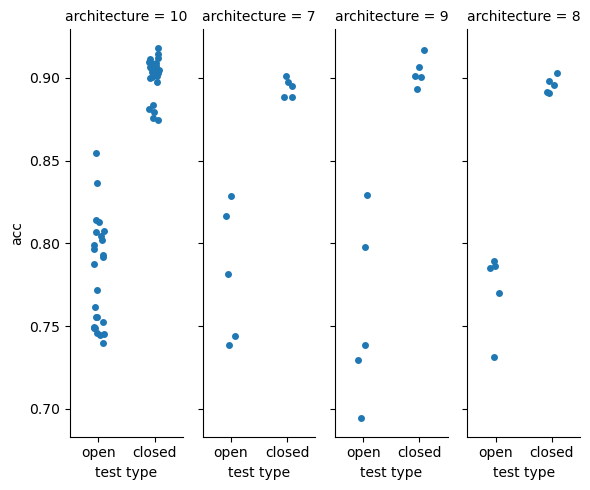

In [68]:
sns.catplot(performance_df, x ='test type', y ='acc', col='architecture', aspect=0.3)

In [108]:
closed_perf = performance_df[performance_df['test type'] == 'closed'].groupby('architecture').mean()

In [109]:
closed_perf.sort_values('acc', axis = 0)

,loss,acc,recall,prec,f1
architecture,,,,,
7,0.267924,0.894093,0.891537,0.896242,0.893869
8,0.262178,0.895876,0.895510,0.896282,0.895862
10,0.249042,0.903280,0.901442,0.904885,0.903142
9,0.246855,0.903607,0.907102,0.900960,0.903998


In [110]:
open_perf = performance_df[performance_df['test type'] == 'open'].groupby('architecture').mean()

In [111]:
open_perf.sort_values('acc', axis = 0)

,loss,acc,recall,prec,f1
architecture,,,,,
9,0.743707,0.757837,0.907102,0.702159,0.790626
8,0.652807,0.772313,0.895510,0.719591,0.797609
10,0.717574,0.775850,0.901442,0.721972,0.801343
7,0.687101,0.781973,0.891537,0.733861,0.804356


In [ ]:
#SN10 and MLP_2L 6_3 are the best, lets search leraning rate parameter (well Adam itself ia adapive but still)

In [115]:
replicates = 5
batch_size = 100
dataset = one_vs_all_paths[1]
file = dataset.split('/')[-1].strip('.tsv')
df = pd.read_csv(dataset, sep='\t')
train_one_all, val_one_all,  test_one_all = train_val_test_prep(df, scale = False)
train_loader = DataLoader(train_one_all, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_one_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_one_all, batch_size=batch_size, shuffle=True)
for lr in [0.01, 0.002, 0.001, 0.0001]:
    for i in range(1, replicates+1):
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        model = SN_n(10).to(device)
        print(f'Architecture {10}')
        train_mlp(model, device, train_loader, 'SN_n_1_vs_all', f'{file}_layers_10_lr{lr}_repl_{i}', epochs=200, learning_rate = lr)

Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.4545285999774933, Validation loss: 0.36512643098831177


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.32388395071029663, Validation loss: 0.3096483647823334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.2737569808959961, Validation loss: 0.28564655780792236


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.24743294715881348, Validation loss: 0.2731482684612274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.23133154213428497, Validation loss: 0.2672079801559448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.21935369074344635, Validation loss: 0.25736990571022034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.20992349088191986, Validation loss: 0.253373384475708


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.20415766537189484, Validation loss: 0.2505047023296356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.19676601886749268, Validation loss: 0.2442900836467743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.1923365443944931, Validation loss: 0.24443189799785614


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.186457097530365, Validation loss: 0.2422003597021103


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.1835843026638031, Validation loss: 0.23408369719982147


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.17799754440784454, Validation loss: 0.23424087464809418


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.17494063079357147, Validation loss: 0.245399609208107


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.172601118683815, Validation loss: 0.2365579456090927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.166190043091774, Validation loss: 0.23390844464302063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.1639314889907837, Validation loss: 0.24322310090065002


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1617850512266159, Validation loss: 0.23499198257923126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.15969929099082947, Validation loss: 0.23321588337421417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.15717889368534088, Validation loss: 0.23611615598201752


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1553007960319519, Validation loss: 0.25343912839889526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.15523964166641235, Validation loss: 0.23719392716884613


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.15191669762134552, Validation loss: 0.23596243560314178


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.15087470412254333, Validation loss: 0.23950593173503876


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.14975513517856598, Validation loss: 0.2427530139684677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.14950266480445862, Validation loss: 0.2515624463558197


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1492195576429367, Validation loss: 0.23815394937992096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.14608514308929443, Validation loss: 0.2541397213935852


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.14485326409339905, Validation loss: 0.23453643918037415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.14568482339382172, Validation loss: 0.23884165287017822


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.14384129643440247, Validation loss: 0.24073684215545654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1426905393600464, Validation loss: 0.23640532791614532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1420608013868332, Validation loss: 0.2367110252380371


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.14044755697250366, Validation loss: 0.2417580634355545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.14049886167049408, Validation loss: 0.2422304004430771


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.137923002243042, Validation loss: 0.24549196660518646


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1387055665254593, Validation loss: 0.2558671832084656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1389225274324417, Validation loss: 0.25361162424087524


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.13718661665916443, Validation loss: 0.25420069694519043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.1379520297050476, Validation loss: 0.25241410732269287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.13666504621505737, Validation loss: 0.2544403672218323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.1368849277496338, Validation loss: 0.2544058561325073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.1373114138841629, Validation loss: 0.25270283222198486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.13669659197330475, Validation loss: 0.26229915022850037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.13492275774478912, Validation loss: 0.2539156675338745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.1334475725889206, Validation loss: 0.2568887174129486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.1345566362142563, Validation loss: 0.25857973098754883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.13433632254600525, Validation loss: 0.26369473338127136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.1336294412612915, Validation loss: 0.2639364004135132


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.1338423788547516, Validation loss: 0.26485610008239746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.13285578787326813, Validation loss: 0.25822293758392334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.13281287252902985, Validation loss: 0.25829237699508667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.13155050575733185, Validation loss: 0.24987666308879852


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.13196730613708496, Validation loss: 0.26462996006011963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.13087283074855804, Validation loss: 0.259034126996994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.13210059702396393, Validation loss: 0.2626936137676239


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.13062067329883575, Validation loss: 0.2610824406147003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.13063818216323853, Validation loss: 0.2608017027378082


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.13055729866027832, Validation loss: 0.26310062408447266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.13019785284996033, Validation loss: 0.2599128782749176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.12928050756454468, Validation loss: 0.26368385553359985


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.12995468080043793, Validation loss: 0.26278772950172424


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.12936291098594666, Validation loss: 0.26842841506004333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.12899863719940186, Validation loss: 0.2663324475288391


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.12904782593250275, Validation loss: 0.2658962607383728


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.1284204125404358, Validation loss: 0.2607918977737427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.12770432233810425, Validation loss: 0.2588302195072174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.1291341930627823, Validation loss: 0.26453062891960144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.12847091257572174, Validation loss: 0.2640269100666046


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.12930795550346375, Validation loss: 0.2646746337413788


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.12685398757457733, Validation loss: 0.2663794159889221


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.12846793234348297, Validation loss: 0.26280826330184937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.1270107626914978, Validation loss: 0.26524630188941956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.12691329419612885, Validation loss: 0.2665771245956421


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.12616480886936188, Validation loss: 0.26783835887908936


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.1264898180961609, Validation loss: 0.26340022683143616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.1264381855726242, Validation loss: 0.26574137806892395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.12556245923042297, Validation loss: 0.2728223502635956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.12576806545257568, Validation loss: 0.27065593004226685


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.12511666119098663, Validation loss: 0.2661151885986328


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.12458895891904831, Validation loss: 0.26833391189575195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.1257573962211609, Validation loss: 0.2651550769805908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.1253013163805008, Validation loss: 0.27188920974731445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.1250692456960678, Validation loss: 0.267521470785141


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.1256130486726761, Validation loss: 0.27089858055114746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.12612606585025787, Validation loss: 0.26931655406951904


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.1253128945827484, Validation loss: 0.26536864042282104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.12369073927402496, Validation loss: 0.27079346776008606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.12441694736480713, Validation loss: 0.2684992253780365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.12443380057811737, Validation loss: 0.27119845151901245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.1250651329755783, Validation loss: 0.2738771438598633


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.1250835657119751, Validation loss: 0.27044689655303955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.12315944582223892, Validation loss: 0.27639466524124146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.12400390952825546, Validation loss: 0.2707250714302063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.12366610765457153, Validation loss: 0.2711111009120941


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.1243782564997673, Validation loss: 0.2734277844429016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.12308470159769058, Validation loss: 0.2691778838634491


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.12419389188289642, Validation loss: 0.274141401052475


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.12392079085111618, Validation loss: 0.2682434320449829


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.12343913316726685, Validation loss: 0.280040979385376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.12396430224180222, Validation loss: 0.2752806842327118


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.123601034283638, Validation loss: 0.27570462226867676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.12312447279691696, Validation loss: 0.275539755821228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.12253320962190628, Validation loss: 0.28177759051322937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.12252259999513626, Validation loss: 0.2743133306503296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.12226270884275436, Validation loss: 0.2711646854877472


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.1219133660197258, Validation loss: 0.2777596712112427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.12234745174646378, Validation loss: 0.2816910445690155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.12167683243751526, Validation loss: 0.2761598527431488


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.12214154005050659, Validation loss: 0.2838872969150543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.12078069150447845, Validation loss: 0.28114303946495056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.1220083087682724, Validation loss: 0.2803180515766144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.12224997580051422, Validation loss: 0.27855774760246277


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.12280263751745224, Validation loss: 0.2798704206943512


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.1218278631567955, Validation loss: 0.27909746766090393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.12092239409685135, Validation loss: 0.28576332330703735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.1211768239736557, Validation loss: 0.2774726450443268


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.12131614238023758, Validation loss: 0.2773713171482086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.12136427313089371, Validation loss: 0.27468737959861755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.12098850309848785, Validation loss: 0.27892136573791504


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.12063229829072952, Validation loss: 0.2835640609264374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.12141118943691254, Validation loss: 0.2775246202945709


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.12130139768123627, Validation loss: 0.2878447473049164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.12184493988752365, Validation loss: 0.2774525284767151


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.12064949423074722, Validation loss: 0.2791133224964142


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.1223430410027504, Validation loss: 0.28004246950149536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.12119565159082413, Validation loss: 0.27813485264778137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.11932287365198135, Validation loss: 0.2847488820552826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.12005560100078583, Validation loss: 0.28736162185668945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.12166811525821686, Validation loss: 0.280827134847641


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.11986751109361649, Validation loss: 0.2832707166671753


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.11973647773265839, Validation loss: 0.2792455554008484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.12017626315355301, Validation loss: 0.2808690667152405


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.1188737228512764, Validation loss: 0.28210970759391785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.11995133757591248, Validation loss: 0.2826160192489624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.11938371509313583, Validation loss: 0.2837511897087097


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.12024141848087311, Validation loss: 0.2818987965583801


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.11907941102981567, Validation loss: 0.2818335294723511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.1195913702249527, Validation loss: 0.2895428240299225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.12066715955734253, Validation loss: 0.2871777415275574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.11966272443532944, Validation loss: 0.29236921668052673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.11828487366437912, Validation loss: 0.28425538539886475


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.11939465254545212, Validation loss: 0.28758156299591064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.11884288489818573, Validation loss: 0.2840684950351715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.11789495497941971, Validation loss: 0.2894708216190338


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.11913377046585083, Validation loss: 0.2867239713668823


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.11844536662101746, Validation loss: 0.28756725788116455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.1181475818157196, Validation loss: 0.2863854467868805


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.1190086081624031, Validation loss: 0.29403364658355713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 150/200 - Train loss: 0.11927162855863571, Validation loss: 0.2850458323955536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 151/200 - Train loss: 0.11903123557567596, Validation loss: 0.28564760088920593


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 152/200 - Train loss: 0.1194709911942482, Validation loss: 0.2920328974723816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 153/200 - Train loss: 0.1184290274977684, Validation loss: 0.28425395488739014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 154/200 - Train loss: 0.118055559694767, Validation loss: 0.28797268867492676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 155/200 - Train loss: 0.11916251480579376, Validation loss: 0.2895154058933258


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 156/200 - Train loss: 0.1189446896314621, Validation loss: 0.2905506491661072


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 157/200 - Train loss: 0.11769747734069824, Validation loss: 0.2866758108139038


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 158/200 - Train loss: 0.11753090471029282, Validation loss: 0.28904539346694946


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 159/200 - Train loss: 0.11736473441123962, Validation loss: 0.2876583933830261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 160/200 - Train loss: 0.11791995167732239, Validation loss: 0.2909363806247711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 161/200 - Train loss: 0.11916365474462509, Validation loss: 0.2916646897792816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 162/200 - Train loss: 0.11763790994882584, Validation loss: 0.290378600358963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 163/200 - Train loss: 0.11776121705770493, Validation loss: 0.2887296974658966
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.45268669724464417, Validation loss: 0.37394267320632935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.3157915472984314, Validation loss: 0.301871657371521


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.25206542015075684, Validation loss: 0.2692505717277527


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.22439999878406525, Validation loss: 0.2563806474208832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.20874279737472534, Validation loss: 0.24730026721954346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.19898371398448944, Validation loss: 0.24677373468875885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.19320814311504364, Validation loss: 0.242365762591362


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.18732096254825592, Validation loss: 0.2521938979625702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.18319527804851532, Validation loss: 0.24293014407157898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.1757742017507553, Validation loss: 0.24085915088653564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.17298918962478638, Validation loss: 0.23938894271850586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.17090854048728943, Validation loss: 0.25085046887397766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.16931943595409393, Validation loss: 0.24506524205207825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.16852419078350067, Validation loss: 0.24510768055915833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.16505225002765656, Validation loss: 0.25334036350250244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.16427865624427795, Validation loss: 0.24446338415145874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.16167844831943512, Validation loss: 0.24332822859287262


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.15891052782535553, Validation loss: 0.24686580896377563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.16091522574424744, Validation loss: 0.24613335728645325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1576455980539322, Validation loss: 0.24843205511569977


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.15561358630657196, Validation loss: 0.24618807435035706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1540742665529251, Validation loss: 0.2473738044500351


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.15371043980121613, Validation loss: 0.257651686668396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.15360890328884125, Validation loss: 0.25102734565734863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.15223002433776855, Validation loss: 0.2507290542125702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.15193592011928558, Validation loss: 0.2524241507053375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.15041913092136383, Validation loss: 0.2464679777622223


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1492881178855896, Validation loss: 0.2500392496585846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.14827650785446167, Validation loss: 0.257100373506546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.14772292971611023, Validation loss: 0.2569100558757782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.14772966504096985, Validation loss: 0.2524089217185974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.14672434329986572, Validation loss: 0.24977974593639374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1456102430820465, Validation loss: 0.2528034746646881


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.14569105207920074, Validation loss: 0.2568068206310272


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1454761028289795, Validation loss: 0.24943047761917114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.14560671150684357, Validation loss: 0.25387653708457947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.14426903426647186, Validation loss: 0.2588023543357849


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.14380855858325958, Validation loss: 0.25505533814430237


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.14195695519447327, Validation loss: 0.2530432641506195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.1432877629995346, Validation loss: 0.2630237638950348


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.14162451028823853, Validation loss: 0.2584775388240814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.14136575162410736, Validation loss: 0.2547124922275543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.14199033379554749, Validation loss: 0.2522754669189453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.14083100855350494, Validation loss: 0.2570665180683136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.1405939757823944, Validation loss: 0.2620265483856201


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.14103953540325165, Validation loss: 0.2553175389766693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.14025996625423431, Validation loss: 0.2611584961414337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.13945837318897247, Validation loss: 0.2510843276977539


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.1402377188205719, Validation loss: 0.25446364283561707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.13818664848804474, Validation loss: 0.26059481501579285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.13920976221561432, Validation loss: 0.2622353434562683


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.13803209364414215, Validation loss: 0.2665170729160309


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.13814152777194977, Validation loss: 0.26055628061294556


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.13763196766376495, Validation loss: 0.25694170594215393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.1366836577653885, Validation loss: 0.27245840430259705


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.13702945411205292, Validation loss: 0.2627911865711212


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.13653704524040222, Validation loss: 0.25579404830932617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.13611841201782227, Validation loss: 0.2763660252094269


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.13553296029567719, Validation loss: 0.25660422444343567


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.1366773247718811, Validation loss: 0.2765970230102539


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.1367914378643036, Validation loss: 0.26928985118865967


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.1359039545059204, Validation loss: 0.25867798924446106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.13595852255821228, Validation loss: 0.2628837525844574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.13483060896396637, Validation loss: 0.26364070177078247


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.13417690992355347, Validation loss: 0.2757534682750702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.134101003408432, Validation loss: 0.2591294050216675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.1352343112230301, Validation loss: 0.27378082275390625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.13405194878578186, Validation loss: 0.2759263217449188


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.13546302914619446, Validation loss: 0.26042357087135315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.13508683443069458, Validation loss: 0.276502788066864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.133153036236763, Validation loss: 0.2682531177997589


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.13320529460906982, Validation loss: 0.2603398859500885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.1337052434682846, Validation loss: 0.2782415747642517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.13277201354503632, Validation loss: 0.2644244432449341


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.1326436698436737, Validation loss: 0.26170632243156433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.13441349565982819, Validation loss: 0.26853862404823303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.13319219648838043, Validation loss: 0.28839603066444397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.1322936713695526, Validation loss: 0.2616145610809326


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.1323055773973465, Validation loss: 0.26335084438323975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.13201920688152313, Validation loss: 0.2650648057460785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.13191483914852142, Validation loss: 0.2851981222629547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.13170377910137177, Validation loss: 0.27921098470687866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.13153544068336487, Validation loss: 0.2628285884857178


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.13224881887435913, Validation loss: 0.26945897936820984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.1322847157716751, Validation loss: 0.26921388506889343


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.1310959756374359, Validation loss: 0.2676183581352234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.13206034898757935, Validation loss: 0.2838101387023926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.1308698207139969, Validation loss: 0.2848908305168152


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.1312749683856964, Validation loss: 0.26246362924575806


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.1317988783121109, Validation loss: 0.2659514844417572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.13064102828502655, Validation loss: 0.2637729048728943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.13000653684139252, Validation loss: 0.28701406717300415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.1305849850177765, Validation loss: 0.2929348647594452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.13064655661582947, Validation loss: 0.2860003709793091


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.1298896223306656, Validation loss: 0.2669971287250519


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.1293771117925644, Validation loss: 0.27046456933021545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.13018713891506195, Validation loss: 0.26462817192077637


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.12997369468212128, Validation loss: 0.2819980978965759


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.12947973608970642, Validation loss: 0.2794768214225769


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.12928257882595062, Validation loss: 0.2823083698749542


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.13083861768245697, Validation loss: 0.2835835814476013


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.12946577370166779, Validation loss: 0.2791685163974762


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.12958195805549622, Validation loss: 0.27826252579689026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.12858529388904572, Validation loss: 0.28304600715637207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.12897832691669464, Validation loss: 0.2813586890697479


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.12930439412593842, Validation loss: 0.2676752507686615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.12846806645393372, Validation loss: 0.27289021015167236


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.12908613681793213, Validation loss: 0.2679999768733978


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.12819097936153412, Validation loss: 0.2836167514324188


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.12852445244789124, Validation loss: 0.2842378616333008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.1280134916305542, Validation loss: 0.2856377065181732


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.12879164516925812, Validation loss: 0.2800583839416504


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.12910181283950806, Validation loss: 0.2926381230354309


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.127579465508461, Validation loss: 0.2685786187648773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.12821194529533386, Validation loss: 0.2829799950122833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.1282631903886795, Validation loss: 0.2904691696166992


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.12768805027008057, Validation loss: 0.27105268836021423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.12711229920387268, Validation loss: 0.27093419432640076


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.12692180275917053, Validation loss: 0.28333574533462524


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.12755252420902252, Validation loss: 0.2701711654663086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.12808743119239807, Validation loss: 0.26694902777671814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.1275670826435089, Validation loss: 0.2875630259513855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.12810970842838287, Validation loss: 0.2846474349498749


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.12600991129875183, Validation loss: 0.28962624073028564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.1271362453699112, Validation loss: 0.28252944350242615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.1268254518508911, Validation loss: 0.324699729681015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.12686730921268463, Validation loss: 0.28483688831329346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.12665389478206635, Validation loss: 0.28657066822052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.12748441100120544, Validation loss: 0.2730538547039032


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.1269426792860031, Validation loss: 0.2817194163799286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.1262369304895401, Validation loss: 0.28606075048446655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.12854620814323425, Validation loss: 0.2746446132659912


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.1266060471534729, Validation loss: 0.2771880030632019


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.12531113624572754, Validation loss: 0.284846693277359


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.12671691179275513, Validation loss: 0.2706974446773529


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.12621937692165375, Validation loss: 0.2769634425640106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.12672273814678192, Validation loss: 0.2721177041530609


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.1256582885980606, Validation loss: 0.2768121361732483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.12600058317184448, Validation loss: 0.2733564078807831


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.12587426602840424, Validation loss: 0.27875614166259766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.12557387351989746, Validation loss: 0.278816819190979


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.12595276534557343, Validation loss: 0.2912725508213043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.12642288208007812, Validation loss: 0.2763098180294037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.12556326389312744, Validation loss: 0.27619585394859314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.12529242038726807, Validation loss: 0.27714061737060547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.12774547934532166, Validation loss: 0.2812495231628418


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.12563617527484894, Validation loss: 0.28799575567245483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.12572745978832245, Validation loss: 0.2911677956581116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.12525661289691925, Validation loss: 0.30199354887008667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 150/200 - Train loss: 0.12511807680130005, Validation loss: 0.2866514027118683


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 151/200 - Train loss: 0.12602366507053375, Validation loss: 0.27491408586502075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 152/200 - Train loss: 0.12529729306697845, Validation loss: 0.27763277292251587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 153/200 - Train loss: 0.1264224797487259, Validation loss: 0.27351588010787964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 154/200 - Train loss: 0.12638165056705475, Validation loss: 0.2773897051811218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 155/200 - Train loss: 0.12549066543579102, Validation loss: 0.27281439304351807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 156/200 - Train loss: 0.12570451200008392, Validation loss: 0.2806800305843353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 157/200 - Train loss: 0.12565934658050537, Validation loss: 0.27664631605148315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 158/200 - Train loss: 0.12578381597995758, Validation loss: 0.2779207229614258


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 159/200 - Train loss: 0.12576869130134583, Validation loss: 0.2735561430454254


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 160/200 - Train loss: 0.12476187944412231, Validation loss: 0.30630195140838623


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 161/200 - Train loss: 0.12482238560914993, Validation loss: 0.2908296585083008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 162/200 - Train loss: 0.12526659667491913, Validation loss: 0.27770689129829407


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 163/200 - Train loss: 0.12521734833717346, Validation loss: 0.2873838543891907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 164/200 - Train loss: 0.12666742503643036, Validation loss: 0.2961888313293457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 165/200 - Train loss: 0.12415138632059097, Validation loss: 0.2877923846244812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 166/200 - Train loss: 0.12397444248199463, Validation loss: 0.29292941093444824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 167/200 - Train loss: 0.12492481619119644, Validation loss: 0.28936389088630676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 168/200 - Train loss: 0.12554733455181122, Validation loss: 0.2892577350139618


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 169/200 - Train loss: 0.12433893233537674, Validation loss: 0.28087905049324036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 170/200 - Train loss: 0.12510208785533905, Validation loss: 0.29354044795036316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 171/200 - Train loss: 0.12484253197908401, Validation loss: 0.29360079765319824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 172/200 - Train loss: 0.12429141998291016, Validation loss: 0.30498620867729187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 173/200 - Train loss: 0.12426520884037018, Validation loss: 0.29189273715019226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 174/200 - Train loss: 0.12351304292678833, Validation loss: 0.2888895869255066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 175/200 - Train loss: 0.12366973608732224, Validation loss: 0.29348114132881165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 176/200 - Train loss: 0.1240381971001625, Validation loss: 0.28401780128479004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 177/200 - Train loss: 0.12535516917705536, Validation loss: 0.2915727496147156


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 178/200 - Train loss: 0.12415077537298203, Validation loss: 0.30401796102523804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 179/200 - Train loss: 0.12379463762044907, Validation loss: 0.2983649969100952


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 180/200 - Train loss: 0.1231309100985527, Validation loss: 0.3045728802680969


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 181/200 - Train loss: 0.12368760257959366, Validation loss: 0.28676706552505493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 182/200 - Train loss: 0.12398193031549454, Validation loss: 0.29169580340385437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 183/200 - Train loss: 0.12496379762887955, Validation loss: 0.28905802965164185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 184/200 - Train loss: 0.12349989265203476, Validation loss: 0.2748676836490631


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 185/200 - Train loss: 0.12403697520494461, Validation loss: 0.29623669385910034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 186/200 - Train loss: 0.12551087141036987, Validation loss: 0.28989753127098083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 187/200 - Train loss: 0.12342805415391922, Validation loss: 0.29221177101135254


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 188/200 - Train loss: 0.12335915118455887, Validation loss: 0.28121891617774963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 189/200 - Train loss: 0.12367206811904907, Validation loss: 0.2932417690753937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 190/200 - Train loss: 0.12417370826005936, Validation loss: 0.29263192415237427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 191/200 - Train loss: 0.12384388595819473, Validation loss: 0.2898234724998474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 192/200 - Train loss: 0.12503045797348022, Validation loss: 0.279302179813385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 193/200 - Train loss: 0.12290377169847488, Validation loss: 0.2942136824131012


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 194/200 - Train loss: 0.12374980747699738, Validation loss: 0.29130464792251587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 195/200 - Train loss: 0.12345683574676514, Validation loss: 0.3096904456615448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 196/200 - Train loss: 0.12402419745922089, Validation loss: 0.29730746150016785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 197/200 - Train loss: 0.1227969229221344, Validation loss: 0.29023808240890503


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 198/200 - Train loss: 0.12321475148200989, Validation loss: 0.307267963886261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 199/200 - Train loss: 0.1234423816204071, Validation loss: 0.29449760913848877


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 200/200 - Train loss: 0.12321494519710541, Validation loss: 0.29380881786346436
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.4585513174533844, Validation loss: 0.38499996066093445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.3284301161766052, Validation loss: 0.31654366850852966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.2795625925064087, Validation loss: 0.29056787490844727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.2515658736228943, Validation loss: 0.28055939078330994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.23657967150211334, Validation loss: 0.27618470788002014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.22630712389945984, Validation loss: 0.2700790762901306


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.21780996024608612, Validation loss: 0.26502352952957153


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.21172964572906494, Validation loss: 0.25869274139404297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.20564375817775726, Validation loss: 0.26991569995880127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.20264434814453125, Validation loss: 0.25885748863220215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.19873374700546265, Validation loss: 0.26354509592056274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.19637084007263184, Validation loss: 0.25956249237060547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.19282618165016174, Validation loss: 0.26098161935806274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.19170227646827698, Validation loss: 0.258603572845459


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.18846599757671356, Validation loss: 0.26266396045684814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.1871541291475296, Validation loss: 0.26542234420776367


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.18566913902759552, Validation loss: 0.2575094401836395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1842462122440338, Validation loss: 0.2591894268989563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.18244293332099915, Validation loss: 0.2577736973762512


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.18149691820144653, Validation loss: 0.2593088150024414


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1799614578485489, Validation loss: 0.26039576530456543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.17819061875343323, Validation loss: 0.26011204719543457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.17748801410198212, Validation loss: 0.2614806294441223


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.17739948630332947, Validation loss: 0.2570388615131378


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17574040591716766, Validation loss: 0.26122644543647766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17576313018798828, Validation loss: 0.2647174596786499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17605730891227722, Validation loss: 0.26456552743911743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1731605976819992, Validation loss: 0.2655833959579468


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17219822108745575, Validation loss: 0.26325690746307373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17214560508728027, Validation loss: 0.2599748969078064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17142254114151, Validation loss: 0.26469874382019043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1708412915468216, Validation loss: 0.2632700502872467


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16937880218029022, Validation loss: 0.2653764486312866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16911835968494415, Validation loss: 0.26407691836357117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16821137070655823, Validation loss: 0.2645898461341858


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16703003644943237, Validation loss: 0.26862308382987976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16870591044425964, Validation loss: 0.26568150520324707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1659044474363327, Validation loss: 0.2727011740207672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16621240973472595, Validation loss: 0.26488661766052246


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.16656143963336945, Validation loss: 0.2644515931606293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.16513438522815704, Validation loss: 0.2668103873729706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.16327036917209625, Validation loss: 0.26983365416526794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.16377003490924835, Validation loss: 0.26419103145599365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.1630098968744278, Validation loss: 0.2683086395263672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.16256684064865112, Validation loss: 0.26785361766815186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.16273044049739838, Validation loss: 0.2705787718296051


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.16119132936000824, Validation loss: 0.2780878245830536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.1604515016078949, Validation loss: 0.2726114094257355


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.16005265712738037, Validation loss: 0.27080053091049194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.1599140167236328, Validation loss: 0.2717897295951843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.1593928337097168, Validation loss: 0.2699284851551056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.15839850902557373, Validation loss: 0.27328938245773315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.15860703587532043, Validation loss: 0.2702830135822296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.15826646983623505, Validation loss: 0.2714215815067291


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.15818120539188385, Validation loss: 0.27465835213661194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.15741358697414398, Validation loss: 0.27185890078544617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.1568922996520996, Validation loss: 0.2788744270801544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.15692976117134094, Validation loss: 0.274088054895401


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.15672916173934937, Validation loss: 0.27359098196029663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.1551065593957901, Validation loss: 0.28076171875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.15571263432502747, Validation loss: 0.27782848477363586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.15574906766414642, Validation loss: 0.2767234146595001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.15545521676540375, Validation loss: 0.2684515118598938


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.15461887419223785, Validation loss: 0.27427953481674194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.15554958581924438, Validation loss: 0.2743365466594696


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.15446408092975616, Validation loss: 0.27957773208618164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.1537996083498001, Validation loss: 0.28038474917411804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.1546253263950348, Validation loss: 0.2827410399913788


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.15423494577407837, Validation loss: 0.27430978417396545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.1530856043100357, Validation loss: 0.2768942713737488


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.15345032513141632, Validation loss: 0.2777547836303711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.1530217081308365, Validation loss: 0.2685331404209137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.15232932567596436, Validation loss: 0.2768382430076599


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.1532348394393921, Validation loss: 0.27928754687309265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.15212348103523254, Validation loss: 0.2757059633731842


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.15223471820354462, Validation loss: 0.27820295095443726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.15171968936920166, Validation loss: 0.27640748023986816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.1510416716337204, Validation loss: 0.2763518989086151


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.15206249058246613, Validation loss: 0.2779507339000702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.15068766474723816, Validation loss: 0.27732428908348083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.15022802352905273, Validation loss: 0.2794461250305176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.15097369253635406, Validation loss: 0.2753090560436249
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.46136075258255005, Validation loss: 0.383287250995636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.33021023869514465, Validation loss: 0.3160538375377655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.2760998010635376, Validation loss: 0.29213255643844604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.24838478863239288, Validation loss: 0.2721894085407257


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.23411090672016144, Validation loss: 0.2628175914287567


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.22142279148101807, Validation loss: 0.2601648271083832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2125295102596283, Validation loss: 0.2577137053012848


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.20714840292930603, Validation loss: 0.2574993073940277


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.20192022621631622, Validation loss: 0.25455912947654724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.19656650722026825, Validation loss: 0.25417789816856384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.1937510371208191, Validation loss: 0.2503794729709625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.18999116122722626, Validation loss: 0.260983943939209


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.1871216744184494, Validation loss: 0.25023308396339417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.18421195447444916, Validation loss: 0.2540416121482849


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.18225805461406708, Validation loss: 0.24814443290233612


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.1809840202331543, Validation loss: 0.24551837146282196


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.17944763600826263, Validation loss: 0.25410768389701843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.17539465427398682, Validation loss: 0.24936285614967346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.17460401356220245, Validation loss: 0.24728555977344513


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.17301777005195618, Validation loss: 0.2504606246948242


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.17272260785102844, Validation loss: 0.25264036655426025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.17175237834453583, Validation loss: 0.24919697642326355


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.17194508016109467, Validation loss: 0.25262752175331116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1693546324968338, Validation loss: 0.25188660621643066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.16871851682662964, Validation loss: 0.24499541521072388


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.16713884472846985, Validation loss: 0.2543523907661438


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.16538329422473907, Validation loss: 0.2543422281742096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.16621384024620056, Validation loss: 0.251614511013031


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1652727723121643, Validation loss: 0.25277918577194214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.16432589292526245, Validation loss: 0.24911777675151825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1661287099123001, Validation loss: 0.25720953941345215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16249892115592957, Validation loss: 0.25497695803642273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16256071627140045, Validation loss: 0.24881431460380554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16156511008739471, Validation loss: 0.25773733854293823


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16088874638080597, Validation loss: 0.25848251581192017


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16149230301380157, Validation loss: 0.26014870405197144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1592773050069809, Validation loss: 0.26216793060302734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.15983368456363678, Validation loss: 0.2585860788822174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.15893618762493134, Validation loss: 0.2597847282886505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.15809383988380432, Validation loss: 0.2563282549381256


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.15680362284183502, Validation loss: 0.2577088177204132


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.1573973149061203, Validation loss: 0.26041877269744873


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.15713101625442505, Validation loss: 0.25771263241767883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.15666063129901886, Validation loss: 0.2654189169406891


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.15660086274147034, Validation loss: 0.2589830160140991


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.15590156614780426, Validation loss: 0.2621653079986572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.15601438283920288, Validation loss: 0.26652324199676514


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.15583457052707672, Validation loss: 0.2613515853881836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.1545540988445282, Validation loss: 0.25763246417045593


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.15375041961669922, Validation loss: 0.2696652114391327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.15306997299194336, Validation loss: 0.27471357583999634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.1540745198726654, Validation loss: 0.26842057704925537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.15280279517173767, Validation loss: 0.2625182569026947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.15412572026252747, Validation loss: 0.26636675000190735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.15343666076660156, Validation loss: 0.2713487446308136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.15192972123622894, Validation loss: 0.26730623841285706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.1513971984386444, Validation loss: 0.26644811034202576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.15219727158546448, Validation loss: 0.26245445013046265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.1511339545249939, Validation loss: 0.2647738754749298


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.1519252061843872, Validation loss: 0.2696092128753662


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.15135398507118225, Validation loss: 0.27380409836769104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.15029460191726685, Validation loss: 0.26816272735595703


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.14968346059322357, Validation loss: 0.26923301815986633


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.15004311501979828, Validation loss: 0.27322933077812195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.14911684393882751, Validation loss: 0.26903361082077026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.15004318952560425, Validation loss: 0.2731917202472687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.15001872181892395, Validation loss: 0.2743276059627533


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.15006721019744873, Validation loss: 0.2721223831176758


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.14920005202293396, Validation loss: 0.27184879779815674


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.14795781672000885, Validation loss: 0.26772475242614746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.1481122225522995, Validation loss: 0.27464231848716736


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.14806057512760162, Validation loss: 0.2755410373210907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.1483980417251587, Validation loss: 0.271418958902359


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.1479223370552063, Validation loss: 0.26949483156204224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.14862556755542755, Validation loss: 0.2703050374984741


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.1481609046459198, Validation loss: 0.27362337708473206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.14679406583309174, Validation loss: 0.2717515230178833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.14797455072402954, Validation loss: 0.27467089891433716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.14709651470184326, Validation loss: 0.2718997895717621


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.14603079855442047, Validation loss: 0.27684393525123596


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.1466408371925354, Validation loss: 0.274509072303772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.14687205851078033, Validation loss: 0.2764183282852173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.1475425511598587, Validation loss: 0.2722860276699066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.14668582379817963, Validation loss: 0.27100810408592224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.14557062089443207, Validation loss: 0.27457234263420105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.14483563601970673, Validation loss: 0.2777174711227417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.14617179334163666, Validation loss: 0.276359498500824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.14553041756153107, Validation loss: 0.27371641993522644


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.1455906480550766, Validation loss: 0.2755420207977295


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.14526773989200592, Validation loss: 0.2782426178455353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.14433099329471588, Validation loss: 0.2782590985298157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.14482222497463226, Validation loss: 0.2782416045665741


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.1444048285484314, Validation loss: 0.27660149335861206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.14543503522872925, Validation loss: 0.2797510623931885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.144738107919693, Validation loss: 0.27905184030532837


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.14473332464694977, Validation loss: 0.2763952612876892


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.14406606554985046, Validation loss: 0.2788805663585663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.14371079206466675, Validation loss: 0.2764294445514679
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.46469414234161377, Validation loss: 0.3871220052242279


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.3355776369571686, Validation loss: 0.31557050347328186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.26943397521972656, Validation loss: 0.2861449122428894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.23930567502975464, Validation loss: 0.26458504796028137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.22112621366977692, Validation loss: 0.25865259766578674


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.20865704119205475, Validation loss: 0.2396877110004425


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.19730255007743835, Validation loss: 0.2510218620300293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.19037918746471405, Validation loss: 0.23544272780418396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.18371279537677765, Validation loss: 0.2384616732597351


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.17854401469230652, Validation loss: 0.23992690443992615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.17526303231716156, Validation loss: 0.23314514756202698


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.17114807665348053, Validation loss: 0.22800156474113464


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.16942991316318512, Validation loss: 0.23071101307868958


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.16636566817760468, Validation loss: 0.24185039103031158


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.16493985056877136, Validation loss: 0.2508031129837036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.1631592959165573, Validation loss: 0.2479618489742279


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.16133683919906616, Validation loss: 0.25509950518608093


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.15893778204917908, Validation loss: 0.24732227623462677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.15695740282535553, Validation loss: 0.2377985566854477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.15752124786376953, Validation loss: 0.25141969323158264


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.15600402653217316, Validation loss: 0.2513543367385864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.15512719750404358, Validation loss: 0.2511661946773529


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.15453508496284485, Validation loss: 0.2530199885368347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1540018767118454, Validation loss: 0.25250694155693054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.1521574705839157, Validation loss: 0.25594931840896606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.15279348194599152, Validation loss: 0.25483304262161255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.15147727727890015, Validation loss: 0.25437042117118835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.149819478392601, Validation loss: 0.25330179929733276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.14997000992298126, Validation loss: 0.2568903863430023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.14735820889472961, Validation loss: 0.25431060791015625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.14729884266853333, Validation loss: 0.25353944301605225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.14706788957118988, Validation loss: 0.26032182574272156


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.14611342549324036, Validation loss: 0.2554765045642853


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.1445872038602829, Validation loss: 0.2574291527271271


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.14526697993278503, Validation loss: 0.2608741819858551


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1439470797777176, Validation loss: 0.25789666175842285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.14426910877227783, Validation loss: 0.2601020932197571


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1427428424358368, Validation loss: 0.26252010464668274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.14246737957000732, Validation loss: 0.26450875401496887


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.1428956538438797, Validation loss: 0.26168498396873474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.14162607491016388, Validation loss: 0.2617674171924591


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.1411350518465042, Validation loss: 0.260459840297699


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.1422027051448822, Validation loss: 0.2643977105617523


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.1407920867204666, Validation loss: 0.26306208968162537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.14132989943027496, Validation loss: 0.263091117143631


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.14083197712898254, Validation loss: 0.2644044756889343
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5613768696784973, Validation loss: 0.45267975330352783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.40441906452178955, Validation loss: 0.39052700996398926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.3547382950782776, Validation loss: 0.35817283391952515


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.32314160466194153, Validation loss: 0.3354329764842987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.29827821254730225, Validation loss: 0.31402823328971863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.2791081964969635, Validation loss: 0.30353251099586487


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.26460975408554077, Validation loss: 0.2920423746109009


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.252877801656723, Validation loss: 0.28466033935546875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.24270735681056976, Validation loss: 0.27571505308151245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.23417752981185913, Validation loss: 0.27364417910575867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2281307876110077, Validation loss: 0.27388641238212585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2211122363805771, Validation loss: 0.2665008306503296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.216050386428833, Validation loss: 0.264233261346817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21101170778274536, Validation loss: 0.2600723206996918


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2067926675081253, Validation loss: 0.25921228528022766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.20349030196666718, Validation loss: 0.25945061445236206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20015542209148407, Validation loss: 0.25392210483551025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1973242461681366, Validation loss: 0.25346603989601135


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19434846937656403, Validation loss: 0.2538127303123474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19201940298080444, Validation loss: 0.254815936088562


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.18993395566940308, Validation loss: 0.25173264741897583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1878458708524704, Validation loss: 0.2499278485774994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18537607789039612, Validation loss: 0.2518790364265442


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1837119311094284, Validation loss: 0.24811391532421112


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18218599259853363, Validation loss: 0.24939675629138947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18039026856422424, Validation loss: 0.2485765963792801


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17941658198833466, Validation loss: 0.2522389590740204


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17816804349422455, Validation loss: 0.2516835927963257


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17654216289520264, Validation loss: 0.25140467286109924


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17524085938930511, Validation loss: 0.2506087124347687
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5415574908256531, Validation loss: 0.477579802274704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4481425881385803, Validation loss: 0.4367291331291199


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40946677327156067, Validation loss: 0.40324586629867554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37147682905197144, Validation loss: 0.36968278884887695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3352370858192444, Validation loss: 0.33769750595092773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3045930564403534, Validation loss: 0.3140498995780945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.28301236033439636, Validation loss: 0.3003498911857605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.26696768403053284, Validation loss: 0.28977110981941223


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.25470954179763794, Validation loss: 0.2803141176700592


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.245002880692482, Validation loss: 0.27612486481666565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2369227111339569, Validation loss: 0.2753297984600067


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23053701221942902, Validation loss: 0.2693924009799957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2247849553823471, Validation loss: 0.26618692278862


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21935655176639557, Validation loss: 0.26227670907974243


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2155551016330719, Validation loss: 0.2585742473602295


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21080665290355682, Validation loss: 0.25808432698249817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20735231041908264, Validation loss: 0.2535293996334076


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20450711250305176, Validation loss: 0.2540675103664398


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2017461359500885, Validation loss: 0.2492474615573883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19869551062583923, Validation loss: 0.25174611806869507


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19620785117149353, Validation loss: 0.25186023116111755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19349929690361023, Validation loss: 0.2474343627691269


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1908743530511856, Validation loss: 0.24617935717105865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1888364851474762, Validation loss: 0.2505127787590027


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.1866408884525299, Validation loss: 0.2505492866039276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1846279799938202, Validation loss: 0.2454381138086319


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1821243017911911, Validation loss: 0.2458440512418747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18041357398033142, Validation loss: 0.2441987246274948


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17927664518356323, Validation loss: 0.24706611037254333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1783071607351303, Validation loss: 0.24523279070854187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1763809770345688, Validation loss: 0.24546581506729126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17522114515304565, Validation loss: 0.24681958556175232


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17445802688598633, Validation loss: 0.24520699679851532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17293182015419006, Validation loss: 0.24432305991649628


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1723770946264267, Validation loss: 0.24626214802265167
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5415501594543457, Validation loss: 0.48233380913734436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4524455666542053, Validation loss: 0.43992194533348083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41337063908576965, Validation loss: 0.40553534030914307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37777718901634216, Validation loss: 0.3762728273868561


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3467453718185425, Validation loss: 0.3521147072315216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3189362585544586, Validation loss: 0.3328610956668854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2952308654785156, Validation loss: 0.31439000368118286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2757776975631714, Validation loss: 0.30104193091392517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2604217529296875, Validation loss: 0.289601594209671


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24833190441131592, Validation loss: 0.2832326591014862


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23834817111492157, Validation loss: 0.2760266363620758


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2295561134815216, Validation loss: 0.2710377871990204


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22270694375038147, Validation loss: 0.266290545463562


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2165667861700058, Validation loss: 0.26601865887641907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21103163063526154, Validation loss: 0.26239046454429626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2060965597629547, Validation loss: 0.257739782333374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2011640965938568, Validation loss: 0.2541762590408325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.19703121483325958, Validation loss: 0.2512020766735077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19303877651691437, Validation loss: 0.24823617935180664


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1906556636095047, Validation loss: 0.24908408522605896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.18728682398796082, Validation loss: 0.24731376767158508


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18426723778247833, Validation loss: 0.24370568990707397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18158873915672302, Validation loss: 0.2439611703157425


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.17904920876026154, Validation loss: 0.24057051539421082


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17653372883796692, Validation loss: 0.2408028542995453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17456398904323578, Validation loss: 0.24042768776416779


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17216850817203522, Validation loss: 0.23690760135650635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17036627233028412, Validation loss: 0.23631154000759125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.16888363659381866, Validation loss: 0.2392859309911728


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.167620450258255, Validation loss: 0.23939427733421326


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.16562601923942566, Validation loss: 0.24057891964912415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16456256806850433, Validation loss: 0.23831237852573395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16275323927402496, Validation loss: 0.23753918707370758
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5476309061050415, Validation loss: 0.48176103830337524


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4521132707595825, Validation loss: 0.44250088930130005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.416506290435791, Validation loss: 0.41330572962760925


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3850124776363373, Validation loss: 0.3839441239833832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3543635606765747, Validation loss: 0.3598308265209198


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32760319113731384, Validation loss: 0.33921605348587036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3031783998012543, Validation loss: 0.319325715303421


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28228700160980225, Validation loss: 0.3056011497974396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26520836353302, Validation loss: 0.2960612177848816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25243985652923584, Validation loss: 0.2849873900413513


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24123041331768036, Validation loss: 0.2781446576118469


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.231916606426239, Validation loss: 0.27045467495918274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2250671088695526, Validation loss: 0.2663997411727905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2182435691356659, Validation loss: 0.2636878490447998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21321243047714233, Validation loss: 0.2585538327693939


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.20813502371311188, Validation loss: 0.25551411509513855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20399069786071777, Validation loss: 0.25086209177970886


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20094437897205353, Validation loss: 0.25205135345458984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19790077209472656, Validation loss: 0.25287893414497375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19470952451229095, Validation loss: 0.24925942718982697


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19165298342704773, Validation loss: 0.24802204966545105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18993456661701202, Validation loss: 0.2491828203201294


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1878720074892044, Validation loss: 0.24445044994354248


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18592995405197144, Validation loss: 0.2464987188577652


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18387292325496674, Validation loss: 0.2452400028705597


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18163204193115234, Validation loss: 0.24574406445026398


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18083760142326355, Validation loss: 0.24394287168979645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17919783294200897, Validation loss: 0.24284249544143677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17717763781547546, Validation loss: 0.24136430025100708


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17585663497447968, Validation loss: 0.24276810884475708


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17477045953273773, Validation loss: 0.24242685735225677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1735469400882721, Validation loss: 0.24323071539402008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17292357981204987, Validation loss: 0.24079306423664093


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17143568396568298, Validation loss: 0.24179607629776
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5470906496047974, Validation loss: 0.4787258803844452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4488517940044403, Validation loss: 0.4339746832847595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40650683641433716, Validation loss: 0.3983604311943054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37127435207366943, Validation loss: 0.36945411562919617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3415694236755371, Validation loss: 0.34657222032546997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3160829544067383, Validation loss: 0.325806200504303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.29402482509613037, Validation loss: 0.30738553404808044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2756732106208801, Validation loss: 0.29296398162841797


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2594926953315735, Validation loss: 0.28113606572151184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2467525452375412, Validation loss: 0.2766561508178711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23766297101974487, Validation loss: 0.2696212828159332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.22841493785381317, Validation loss: 0.26563918590545654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2219690978527069, Validation loss: 0.26211875677108765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21695561707019806, Validation loss: 0.25769925117492676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2112218141555786, Validation loss: 0.2588235139846802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2072402983903885, Validation loss: 0.2578139901161194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2035408318042755, Validation loss: 0.2553940415382385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1999586671590805, Validation loss: 0.2572217285633087


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19790124893188477, Validation loss: 0.25436899065971375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19510740041732788, Validation loss: 0.2572903335094452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19289009273052216, Validation loss: 0.2547350525856018


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1903485357761383, Validation loss: 0.2544626295566559


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18855346739292145, Validation loss: 0.2561729848384857
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5845282673835754, Validation loss: 0.5183146595954895


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4924521744251251, Validation loss: 0.4851721525192261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.46597668528556824, Validation loss: 0.4637289345264435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.44559088349342346, Validation loss: 0.44673365354537964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.4279269278049469, Validation loss: 0.43293094635009766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.4107813537120819, Validation loss: 0.41616278886795044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.39297211170196533, Validation loss: 0.40109699964523315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3741154074668884, Validation loss: 0.38292384147644043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.35471612215042114, Validation loss: 0.3650414049625397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3356797695159912, Validation loss: 0.34987735748291016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3172224462032318, Validation loss: 0.3321745991706848


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.3005450963973999, Validation loss: 0.3180676996707916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.28568071126937866, Validation loss: 0.30629676580429077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2732006907463074, Validation loss: 0.29572635889053345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2623019218444824, Validation loss: 0.2893730103969574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.253068745136261, Validation loss: 0.28291791677474976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.24509216845035553, Validation loss: 0.27529871463775635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2385038584470749, Validation loss: 0.2707480192184448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2326371967792511, Validation loss: 0.2674659490585327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22698421776294708, Validation loss: 0.2646471858024597


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22219648957252502, Validation loss: 0.2615853548049927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.21757814288139343, Validation loss: 0.2579396367073059


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.21426865458488464, Validation loss: 0.25698333978652954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.21049539744853973, Validation loss: 0.25326043367385864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.20735985040664673, Validation loss: 0.2531444728374481


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.20454362034797668, Validation loss: 0.2504247725009918


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2013905793428421, Validation loss: 0.24785801768302917


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19886250793933868, Validation loss: 0.2470456212759018


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.19656044244766235, Validation loss: 0.2445128858089447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.19398269057273865, Validation loss: 0.24437439441680908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.19195666909217834, Validation loss: 0.24441075325012207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.19026128947734833, Validation loss: 0.24138249456882477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18798942863941193, Validation loss: 0.24392282962799072


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18638408184051514, Validation loss: 0.24066278338432312


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.18440958857536316, Validation loss: 0.2399149388074875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.18315820395946503, Validation loss: 0.24059166014194489


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1815582513809204, Validation loss: 0.24096909165382385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.18051700294017792, Validation loss: 0.2413717359304428
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5950437188148499, Validation loss: 0.519387423992157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.49002501368522644, Validation loss: 0.4799244701862335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4608742594718933, Validation loss: 0.45728763937950134


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.43961241841316223, Validation loss: 0.4393016993999481


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.42001837491989136, Validation loss: 0.4229157865047455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.40071970224380493, Validation loss: 0.40426331758499146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.38086986541748047, Validation loss: 0.38788750767707825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.36194923520088196, Validation loss: 0.3713476061820984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3435225188732147, Validation loss: 0.35740214586257935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3273807168006897, Validation loss: 0.3440057933330536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3117450475692749, Validation loss: 0.32990434765815735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.297900527715683, Validation loss: 0.3200092613697052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2864345610141754, Validation loss: 0.31177636981010437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.27646857500076294, Validation loss: 0.3028528094291687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2673749029636383, Validation loss: 0.29763421416282654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.26011723279953003, Validation loss: 0.29234549403190613


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.25383567810058594, Validation loss: 0.2874825894832611


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2477189004421234, Validation loss: 0.28210344910621643


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2421819567680359, Validation loss: 0.27994126081466675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23743566870689392, Validation loss: 0.2750980854034424


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.23280544579029083, Validation loss: 0.275599867105484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2285524159669876, Validation loss: 0.2701175808906555


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22541508078575134, Validation loss: 0.2677671015262604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22185780107975006, Validation loss: 0.266095370054245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.21834221482276917, Validation loss: 0.2646263837814331


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2156463861465454, Validation loss: 0.26279589533805847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2130233496427536, Validation loss: 0.26201432943344116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21033279597759247, Validation loss: 0.2608603835105896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.20781755447387695, Validation loss: 0.2621222138404846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.20613758265972137, Validation loss: 0.25748729705810547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.20376037061214447, Validation loss: 0.2582705616950989


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.2017207145690918, Validation loss: 0.2581877112388611


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.20049257576465607, Validation loss: 0.2561240494251251


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.1980256587266922, Validation loss: 0.2567009925842285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.19716666638851166, Validation loss: 0.2551174759864807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.19479802250862122, Validation loss: 0.25393784046173096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1937888115644455, Validation loss: 0.2534043490886688


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.19235903024673462, Validation loss: 0.2535969018936157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.19097065925598145, Validation loss: 0.2538447678089142
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5943676829338074, Validation loss: 0.5185164213180542


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.49341803789138794, Validation loss: 0.4858580231666565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.46749576926231384, Validation loss: 0.4660649597644806


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4481319487094879, Validation loss: 0.4468775689601898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.42906996607780457, Validation loss: 0.43026256561279297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.4091351330280304, Validation loss: 0.41388675570487976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.39001697301864624, Validation loss: 0.3963524103164673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3705052137374878, Validation loss: 0.3809736669063568


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3516198992729187, Validation loss: 0.3641354441642761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3335813581943512, Validation loss: 0.34864065051078796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3165777027606964, Validation loss: 0.33535099029541016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.3020436763763428, Validation loss: 0.32374638319015503


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2892535328865051, Validation loss: 0.314477801322937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2783317267894745, Validation loss: 0.3057381212711334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2685356140136719, Validation loss: 0.29891031980514526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.26058146357536316, Validation loss: 0.2934572994709015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2529699206352234, Validation loss: 0.28817251324653625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24663305282592773, Validation loss: 0.2841168940067291


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24075472354888916, Validation loss: 0.28127196431159973


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23578721284866333, Validation loss: 0.27705568075180054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2309424728155136, Validation loss: 0.27539509534835815


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22728824615478516, Validation loss: 0.27183207869529724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2234632968902588, Validation loss: 0.2707700729370117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22026248276233673, Validation loss: 0.26796838641166687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2172318696975708, Validation loss: 0.2672918140888214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2148086577653885, Validation loss: 0.26657041907310486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21188510954380035, Validation loss: 0.26415306329727173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.20910242199897766, Validation loss: 0.26351603865623474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2068508118391037, Validation loss: 0.26194000244140625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.20456267893314362, Validation loss: 0.26032817363739014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.20264992117881775, Validation loss: 0.26063022017478943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.2014973908662796, Validation loss: 0.2591630816459656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.19940587878227234, Validation loss: 0.25944867730140686


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.19727866351604462, Validation loss: 0.2562098205089569


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.19581115245819092, Validation loss: 0.25645381212234497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1942344307899475, Validation loss: 0.25543543696403503


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1930508315563202, Validation loss: 0.2556611895561218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.191336527466774, Validation loss: 0.25547167658805847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.1900697499513626, Validation loss: 0.25472092628479004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.18944884836673737, Validation loss: 0.25494322180747986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.18774275481700897, Validation loss: 0.25386038422584534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.18664389848709106, Validation loss: 0.2552606761455536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.1855837106704712, Validation loss: 0.2548287510871887
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5881180763244629, Validation loss: 0.5175582766532898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4919653832912445, Validation loss: 0.4824255108833313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4636251628398895, Validation loss: 0.4610753059387207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4404360353946686, Validation loss: 0.43969088792800903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.41797924041748047, Validation loss: 0.4186170995235443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.39572659134864807, Validation loss: 0.39970120787620544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.37538740038871765, Validation loss: 0.3826580047607422


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.35584378242492676, Validation loss: 0.36557358503341675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3386923372745514, Validation loss: 0.3519403338432312


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.32295113801956177, Validation loss: 0.33883142471313477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.30945712327957153, Validation loss: 0.32687655091285706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.29697075486183167, Validation loss: 0.3180580735206604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.28627681732177734, Validation loss: 0.3099440038204193


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2765183746814728, Validation loss: 0.3022476136684418


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2682779133319855, Validation loss: 0.29647427797317505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.26071110367774963, Validation loss: 0.2909996807575226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.25422391295433044, Validation loss: 0.286594957113266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24782897531986237, Validation loss: 0.280358225107193


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24270646274089813, Validation loss: 0.2782348394393921


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23753756284713745, Validation loss: 0.2742883861064911


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2331482172012329, Validation loss: 0.273275226354599


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2292567789554596, Validation loss: 0.26996225118637085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22614096105098724, Validation loss: 0.26711246371269226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22286462783813477, Validation loss: 0.26651084423065186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.21947188675403595, Validation loss: 0.2646559774875641


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21660031378269196, Validation loss: 0.2621445655822754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21507057547569275, Validation loss: 0.2606894373893738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21183954179286957, Validation loss: 0.2606193721294403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.20987853407859802, Validation loss: 0.26052311062812805


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.20778489112854004, Validation loss: 0.2590213716030121


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.2063625305891037, Validation loss: 0.25895965099334717


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.20443730056285858, Validation loss: 0.25945329666137695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.20303776860237122, Validation loss: 0.2585979104042053


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.20086611807346344, Validation loss: 0.258649080991745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.19968253374099731, Validation loss: 0.2566019296646118


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1984061449766159, Validation loss: 0.25674617290496826
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5913427472114563, Validation loss: 0.5166351199150085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4880184531211853, Validation loss: 0.4784005880355835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.45793795585632324, Validation loss: 0.45650938153266907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.43632057309150696, Validation loss: 0.43748217821121216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.41700121760368347, Validation loss: 0.4210287928581238


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3985975682735443, Validation loss: 0.40433087944984436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.38129550218582153, Validation loss: 0.38845115900039673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.36466294527053833, Validation loss: 0.3742298185825348


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3482934534549713, Validation loss: 0.3588896095752716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3322162628173828, Validation loss: 0.3457168638706207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3180900812149048, Validation loss: 0.33398786187171936


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.30472657084465027, Validation loss: 0.32364699244499207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.29202529788017273, Validation loss: 0.3140393793582916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.28180041909217834, Validation loss: 0.3069671094417572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.27228647470474243, Validation loss: 0.29957613348960876


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.26380184292793274, Validation loss: 0.29232099652290344


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.25603947043418884, Validation loss: 0.28600233793258667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24913597106933594, Validation loss: 0.2818153202533722


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.24307824671268463, Validation loss: 0.2776825428009033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23752443492412567, Validation loss: 0.2725968062877655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.23320338129997253, Validation loss: 0.2696340084075928


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22847293317317963, Validation loss: 0.2670266628265381


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22444744408130646, Validation loss: 0.26236972212791443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.22090154886245728, Validation loss: 0.2612777054309845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.21708984673023224, Validation loss: 0.2588253915309906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21405261754989624, Validation loss: 0.2542904317378998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21125826239585876, Validation loss: 0.25469422340393066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.20916305482387543, Validation loss: 0.2526738941669464


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.20634771883487701, Validation loss: 0.25095295906066895


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.20417116582393646, Validation loss: 0.2494501918554306


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.20197060704231262, Validation loss: 0.24782419204711914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.20057785511016846, Validation loss: 0.2464745044708252


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.19816604256629944, Validation loss: 0.2443017065525055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.19619838893413544, Validation loss: 0.24429266154766083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1953151971101761, Validation loss: 0.24238169193267822


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.19296467304229736, Validation loss: 0.24326615035533905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.19156025350093842, Validation loss: 0.24278154969215393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.19010381400585175, Validation loss: 0.24245519936084747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.18857558071613312, Validation loss: 0.24175718426704407


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.18696339428424835, Validation loss: 0.24087288975715637


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.1860726922750473, Validation loss: 0.23990757763385773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.18500429391860962, Validation loss: 0.23940061032772064
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6896068453788757, Validation loss: 0.680060625076294


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6686813831329346, Validation loss: 0.6560430526733398


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6391960978507996, Validation loss: 0.6248300671577454


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6079419851303101, Validation loss: 0.5969235301017761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.581576943397522, Validation loss: 0.5744103193283081


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.5605962872505188, Validation loss: 0.5575990080833435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.544607937335968, Validation loss: 0.5438269972801208


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5320274829864502, Validation loss: 0.5335183143615723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5221673846244812, Validation loss: 0.5250606536865234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5143462419509888, Validation loss: 0.5184482932090759


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5078941583633423, Validation loss: 0.513037383556366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5021882653236389, Validation loss: 0.5080527067184448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.49737414717674255, Validation loss: 0.503412127494812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.4929542541503906, Validation loss: 0.5005901455879211


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.4889283776283264, Validation loss: 0.4963837265968323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.48543938994407654, Validation loss: 0.49261415004730225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.4818752110004425, Validation loss: 0.48959919810295105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4788464307785034, Validation loss: 0.4869701564311981


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.4755854308605194, Validation loss: 0.48400789499282837


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.472113698720932, Validation loss: 0.4812471568584442


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.46954357624053955, Validation loss: 0.47823888063430786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.46652647852897644, Validation loss: 0.4758325517177582


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.4642358720302582, Validation loss: 0.473004549741745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.46175143122673035, Validation loss: 0.4708213210105896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.4595882296562195, Validation loss: 0.4683903157711029


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.4567010998725891, Validation loss: 0.4659363031387329


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.45415905117988586, Validation loss: 0.46409890055656433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.4521820545196533, Validation loss: 0.4621056616306305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.44998735189437866, Validation loss: 0.4601256549358368


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.4479866027832031, Validation loss: 0.45844706892967224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.4456142485141754, Validation loss: 0.45656758546829224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.44389116764068604, Validation loss: 0.45481744408607483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.44187891483306885, Validation loss: 0.4540332853794098


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.43968465924263, Validation loss: 0.4510522186756134


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4377928674221039, Validation loss: 0.4493838846683502


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.4358345866203308, Validation loss: 0.44719770550727844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4339199364185333, Validation loss: 0.44606518745422363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.43229252099990845, Validation loss: 0.44511356949806213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4298838973045349, Validation loss: 0.44266289472579956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.42775824666023254, Validation loss: 0.44183632731437683


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.4260253310203552, Validation loss: 0.439336359500885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.4238014817237854, Validation loss: 0.4379327893257141


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.4222399592399597, Validation loss: 0.43641310930252075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.4199926257133484, Validation loss: 0.4346481263637543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4183659851551056, Validation loss: 0.4327618479728699


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.4164150655269623, Validation loss: 0.431042343378067


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.4146065413951874, Validation loss: 0.4291929602622986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.4125674068927765, Validation loss: 0.4282453656196594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4107799828052521, Validation loss: 0.4258125126361847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.40857526659965515, Validation loss: 0.4247855544090271


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.40669047832489014, Validation loss: 0.4227216839790344


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.40489163994789124, Validation loss: 0.42057865858078003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.4027138948440552, Validation loss: 0.41859832406044006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.4007798731327057, Validation loss: 0.41653531789779663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.39870938658714294, Validation loss: 0.4157133400440216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.39670348167419434, Validation loss: 0.4132902920246124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.39473018050193787, Validation loss: 0.4117770791053772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.3930472731590271, Validation loss: 0.4099973142147064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.39119768142700195, Validation loss: 0.4081786572933197


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.38925349712371826, Validation loss: 0.4074547588825226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.38680005073547363, Validation loss: 0.4050787687301636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.38540327548980713, Validation loss: 0.4029923677444458


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.3830564320087433, Validation loss: 0.40036287903785706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.3811390697956085, Validation loss: 0.39968085289001465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.37940698862075806, Validation loss: 0.39753666520118713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.3774906098842621, Validation loss: 0.39599165320396423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3756018579006195, Validation loss: 0.3945949971675873


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.37380552291870117, Validation loss: 0.3923187255859375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.3714831471443176, Validation loss: 0.3906538486480713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.36976251006126404, Validation loss: 0.38928207755088806


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3675515353679657, Validation loss: 0.3878936171531677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.3658921420574188, Validation loss: 0.3859608769416809


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.3641003370285034, Validation loss: 0.38422954082489014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.3618074357509613, Validation loss: 0.38367950916290283


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3601115942001343, Validation loss: 0.3802734613418579


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3581937551498413, Validation loss: 0.37947311997413635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.35678359866142273, Validation loss: 0.3777400851249695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.3547694683074951, Validation loss: 0.37603601813316345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3528876006603241, Validation loss: 0.37419021129608154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.35117635130882263, Validation loss: 0.3736908733844757


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3496483862400055, Validation loss: 0.37154486775398254


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.3477334976196289, Validation loss: 0.3700272738933563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.3460419774055481, Validation loss: 0.3686968982219696


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.34448298811912537, Validation loss: 0.3673191964626312


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.34266629815101624, Validation loss: 0.36666691303253174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.3411243259906769, Validation loss: 0.3640063405036926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.3393290042877197, Validation loss: 0.3626095652580261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.3376735746860504, Validation loss: 0.3611978590488434


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.33609363436698914, Validation loss: 0.3606413006782532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.3342685103416443, Validation loss: 0.35907837748527527


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3328186571598053, Validation loss: 0.35714465379714966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.33114519715309143, Validation loss: 0.3557156026363373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.330161452293396, Validation loss: 0.3544858396053314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.32822757959365845, Validation loss: 0.35296863317489624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3270091712474823, Validation loss: 0.352334201335907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.32522329688072205, Validation loss: 0.35072606801986694


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.3238607943058014, Validation loss: 0.3496388792991638


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.32233235239982605, Validation loss: 0.34824085235595703


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.32073649764060974, Validation loss: 0.34628087282180786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.3194328248500824, Validation loss: 0.3457236588001251


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.31769782304763794, Validation loss: 0.3449030816555023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.3165421783924103, Validation loss: 0.3427075147628784


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.3153672516345978, Validation loss: 0.3417649269104004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.31403452157974243, Validation loss: 0.3405502438545227


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.3126984238624573, Validation loss: 0.34005939960479736


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.3110456168651581, Validation loss: 0.3392504155635834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.30998411774635315, Validation loss: 0.33741283416748047


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.30804622173309326, Validation loss: 0.3367030918598175


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3069716691970825, Validation loss: 0.33510804176330566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.305808961391449, Validation loss: 0.3345819413661957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.3045765161514282, Validation loss: 0.33315426111221313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.30309900641441345, Validation loss: 0.33237868547439575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.30193302035331726, Validation loss: 0.33203890919685364


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.30065497756004333, Validation loss: 0.33025455474853516


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.29938021302223206, Validation loss: 0.3295834958553314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.29840049147605896, Validation loss: 0.3281680643558502


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.2971813678741455, Validation loss: 0.32719752192497253


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.2960268259048462, Validation loss: 0.3268074691295624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.29462823271751404, Validation loss: 0.325559139251709


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.29370802640914917, Validation loss: 0.3247683346271515


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.29273757338523865, Validation loss: 0.3237960636615753


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.291492760181427, Validation loss: 0.3232068717479706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.2903977334499359, Validation loss: 0.3226568400859833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.28919726610183716, Validation loss: 0.32107192277908325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.28788456320762634, Validation loss: 0.3202258348464966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.2873508036136627, Validation loss: 0.3192531168460846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.2861410975456238, Validation loss: 0.31971800327301025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.28517207503318787, Validation loss: 0.31794536113739014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.28423067927360535, Validation loss: 0.31678974628448486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2826313376426697, Validation loss: 0.31667521595954895


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.2822011411190033, Validation loss: 0.31500300765037537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.28074929118156433, Validation loss: 0.3156152069568634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.2801149785518646, Validation loss: 0.3135366141796112


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.2793816030025482, Validation loss: 0.3139146864414215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.2781527638435364, Validation loss: 0.313412606716156


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.2772088944911957, Validation loss: 0.3112289309501648


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.2764692008495331, Validation loss: 0.31115129590034485


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.2752573788166046, Validation loss: 0.30998778343200684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.2743409276008606, Validation loss: 0.30941852927207947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.2734091579914093, Validation loss: 0.30894041061401367


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.2724122703075409, Validation loss: 0.3084912896156311


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.27163395285606384, Validation loss: 0.3084622621536255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.27111902832984924, Validation loss: 0.30653902888298035


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.2698782682418823, Validation loss: 0.306145042181015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.2691933512687683, Validation loss: 0.3069307208061218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.26809731125831604, Validation loss: 0.3055914640426636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.2675006687641144, Validation loss: 0.3043898940086365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.2670954465866089, Validation loss: 0.3042594790458679


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.2659668028354645, Validation loss: 0.30303576588630676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 150/200 - Train loss: 0.26512545347213745, Validation loss: 0.30262622237205505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 151/200 - Train loss: 0.26436394453048706, Validation loss: 0.30288392305374146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 152/200 - Train loss: 0.2635497450828552, Validation loss: 0.30160340666770935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 153/200 - Train loss: 0.26270419359207153, Validation loss: 0.3010414242744446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 154/200 - Train loss: 0.2626052498817444, Validation loss: 0.2994214594364166


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 155/200 - Train loss: 0.26145845651626587, Validation loss: 0.29997071623802185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 156/200 - Train loss: 0.2605443596839905, Validation loss: 0.29844269156455994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 157/200 - Train loss: 0.2597595751285553, Validation loss: 0.2985394597053528


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 158/200 - Train loss: 0.2592174708843231, Validation loss: 0.2976042926311493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 159/200 - Train loss: 0.258771687746048, Validation loss: 0.2977718710899353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 160/200 - Train loss: 0.25780510902404785, Validation loss: 0.29742810130119324


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 161/200 - Train loss: 0.25745877623558044, Validation loss: 0.2970792055130005
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6819306015968323, Validation loss: 0.672537624835968


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6581509709358215, Validation loss: 0.6433660387992859


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6261926293373108, Validation loss: 0.6129843592643738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.5970557928085327, Validation loss: 0.5874281525611877


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.5729595422744751, Validation loss: 0.5670380592346191


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.5542618632316589, Validation loss: 0.5517820119857788


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.5395469069480896, Validation loss: 0.5385575890541077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5278925895690918, Validation loss: 0.5291476249694824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.518254816532135, Validation loss: 0.5218732357025146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5108583569526672, Validation loss: 0.5147486329078674


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5048583149909973, Validation loss: 0.509811520576477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.499433696269989, Validation loss: 0.505550742149353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.4947451651096344, Validation loss: 0.5006134510040283


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.49054455757141113, Validation loss: 0.49712079763412476


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.48649945855140686, Validation loss: 0.4936957359313965


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.4832592308521271, Validation loss: 0.4906711280345917


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.47951942682266235, Validation loss: 0.48661914467811584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.47649824619293213, Validation loss: 0.4835033714771271


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.4736468493938446, Validation loss: 0.48069214820861816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.4706575572490692, Validation loss: 0.47789520025253296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.46795061230659485, Validation loss: 0.4750743806362152


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.46511614322662354, Validation loss: 0.47297441959381104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.4622836112976074, Validation loss: 0.47040265798568726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.45994749665260315, Validation loss: 0.4686369299888611


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.4575750231742859, Validation loss: 0.4657081365585327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.4552355408668518, Validation loss: 0.46410197019577026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.4528210461139679, Validation loss: 0.46198347210884094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.45067134499549866, Validation loss: 0.4602634608745575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.44837135076522827, Validation loss: 0.4573691487312317


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.44658809900283813, Validation loss: 0.45634472370147705


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.4441581070423126, Validation loss: 0.45469966530799866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.4425085186958313, Validation loss: 0.4523898661136627


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.44067278504371643, Validation loss: 0.4505560100078583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.43871837854385376, Validation loss: 0.44879311323165894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4366423487663269, Validation loss: 0.4466964304447174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.43508055806159973, Validation loss: 0.4454047381877899


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.43284136056900024, Validation loss: 0.443421870470047


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.4313566982746124, Validation loss: 0.4424900412559509


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.42916005849838257, Validation loss: 0.4399249255657196


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.4276326596736908, Validation loss: 0.4391791522502899


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.42565739154815674, Validation loss: 0.4372866153717041


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.42345115542411804, Validation loss: 0.4349943697452545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.42171624302864075, Validation loss: 0.43329092860221863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.4198282063007355, Validation loss: 0.4326569437980652


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.41805729269981384, Validation loss: 0.4305015206336975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.4164961874485016, Validation loss: 0.4295923113822937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.41432061791419983, Validation loss: 0.4274376630783081


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.41280463337898254, Validation loss: 0.42607882618904114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4106541574001312, Validation loss: 0.4238176643848419


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.40866386890411377, Validation loss: 0.422748863697052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.406838059425354, Validation loss: 0.42142581939697266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.4053118824958801, Validation loss: 0.41986486315727234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.40308359265327454, Validation loss: 0.41891908645629883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.40148141980171204, Validation loss: 0.41670018434524536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.3993183672428131, Validation loss: 0.4146937131881714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.39746060967445374, Validation loss: 0.41330838203430176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.3954503834247589, Validation loss: 0.41100841760635376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.3936493992805481, Validation loss: 0.40942302346229553


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.39160338044166565, Validation loss: 0.407672643661499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.38960447907447815, Validation loss: 0.40577876567840576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.38806208968162537, Validation loss: 0.4046882688999176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.38590115308761597, Validation loss: 0.4031730890274048


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.3838390111923218, Validation loss: 0.40055787563323975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.38175535202026367, Validation loss: 0.3996155858039856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.3799954950809479, Validation loss: 0.3974185287952423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.37837696075439453, Validation loss: 0.39579451084136963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3761104643344879, Validation loss: 0.3939637541770935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.3748284578323364, Validation loss: 0.3925715982913971


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.3730946481227875, Validation loss: 0.39145150780677795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.370481014251709, Validation loss: 0.39011913537979126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3689517378807068, Validation loss: 0.38732433319091797


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.3669532835483551, Validation loss: 0.3863224983215332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.3652077317237854, Validation loss: 0.38411855697631836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.3631681799888611, Validation loss: 0.382215678691864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.36164894700050354, Validation loss: 0.38176098465919495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.35962939262390137, Validation loss: 0.3796851933002472


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.357463538646698, Validation loss: 0.37865692377090454


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.35551580786705017, Validation loss: 0.3768787384033203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.35385721921920776, Validation loss: 0.3740897476673126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3519461750984192, Validation loss: 0.3725852966308594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.35060179233551025, Validation loss: 0.3718583285808563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.34883737564086914, Validation loss: 0.3695942461490631


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.34653836488723755, Validation loss: 0.3687812089920044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.3450591564178467, Validation loss: 0.3667776584625244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3431819677352905, Validation loss: 0.36562368273735046


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.341744601726532, Validation loss: 0.364082932472229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.339651495218277, Validation loss: 0.3628450334072113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.3385891318321228, Validation loss: 0.36119818687438965


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.3366372287273407, Validation loss: 0.3592912554740906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.3347702920436859, Validation loss: 0.35762882232666016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3330833911895752, Validation loss: 0.35724595189094543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.33156049251556396, Validation loss: 0.3560647666454315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3296699523925781, Validation loss: 0.3535841107368469


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.32815417647361755, Validation loss: 0.3532617390155792


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3262537717819214, Validation loss: 0.35119712352752686


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.3249751925468445, Validation loss: 0.3488859236240387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.32340967655181885, Validation loss: 0.34899675846099854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.32183837890625, Validation loss: 0.3466807007789612


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.3200176954269409, Validation loss: 0.34685757756233215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.31858476996421814, Validation loss: 0.34428784251213074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.3173832893371582, Validation loss: 0.3432287871837616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.31575751304626465, Validation loss: 0.342122346162796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.31420454382896423, Validation loss: 0.3404577970504761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.31260043382644653, Validation loss: 0.33939191699028015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.31119096279144287, Validation loss: 0.33893832564353943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.3095701336860657, Validation loss: 0.3385591506958008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.3082687258720398, Validation loss: 0.33566635847091675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.30717888474464417, Validation loss: 0.3346808850765228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.30559641122817993, Validation loss: 0.33396413922309875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.30406156182289124, Validation loss: 0.3325822949409485


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.3027268946170807, Validation loss: 0.3320819139480591


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.30128124356269836, Validation loss: 0.3299933075904846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.30020764470100403, Validation loss: 0.32957184314727783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.2989594340324402, Validation loss: 0.3281599283218384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.29757964611053467, Validation loss: 0.32797402143478394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.2964581251144409, Validation loss: 0.325967401266098


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.29495733976364136, Validation loss: 0.3247811794281006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.2938753366470337, Validation loss: 0.3242378830909729


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.2923973500728607, Validation loss: 0.3233676552772522


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.29132145643234253, Validation loss: 0.3224206268787384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.2903478443622589, Validation loss: 0.32145607471466064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.28930121660232544, Validation loss: 0.32091960310935974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.2877836227416992, Validation loss: 0.31998249888420105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.28729507327079773, Validation loss: 0.3188432455062866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.2857416868209839, Validation loss: 0.3172025680541992


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.28469789028167725, Validation loss: 0.31697672605514526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.2836775481700897, Validation loss: 0.3160063326358795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.2827475965023041, Validation loss: 0.3156873285770416


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.2816542088985443, Validation loss: 0.3150424659252167


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2806687355041504, Validation loss: 0.3138519525527954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.2799425423145294, Validation loss: 0.3137175440788269


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.27861765027046204, Validation loss: 0.31267133355140686


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.27748364210128784, Validation loss: 0.31205639243125916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.2769225239753723, Validation loss: 0.31182894110679626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.2762364447116852, Validation loss: 0.3105245530605316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.2748548686504364, Validation loss: 0.3097155690193176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.27409324049949646, Validation loss: 0.3085424304008484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.2730715572834015, Validation loss: 0.308115690946579


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.27230513095855713, Validation loss: 0.30736711621284485


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.271828293800354, Validation loss: 0.3061557114124298


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.27095165848731995, Validation loss: 0.30556219816207886


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.2697206139564514, Validation loss: 0.3054635226726532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.26902949810028076, Validation loss: 0.30537116527557373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.26800626516342163, Validation loss: 0.30460867285728455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.26728376746177673, Validation loss: 0.3041384518146515


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.2665810286998749, Validation loss: 0.3034370243549347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.26584967970848083, Validation loss: 0.30200305581092834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.2655836045742035, Validation loss: 0.3015579581260681


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.26419639587402344, Validation loss: 0.30130746960639954
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6890975832939148, Validation loss: 0.6815645694732666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6694256663322449, Validation loss: 0.6561917066574097


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6396504640579224, Validation loss: 0.626140832901001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6093639135360718, Validation loss: 0.5987933874130249


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.5836071968078613, Validation loss: 0.5765030980110168


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.563126802444458, Validation loss: 0.5601155161857605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.5470747351646423, Validation loss: 0.5471721887588501


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.534882128238678, Validation loss: 0.5367467403411865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5253747701644897, Validation loss: 0.5290472507476807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5180988311767578, Validation loss: 0.5229150652885437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5118734240531921, Validation loss: 0.5181588530540466


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5066379904747009, Validation loss: 0.5133609771728516


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5026912093162537, Validation loss: 0.5095168948173523


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.49821776151657104, Validation loss: 0.5051444172859192


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.4944203794002533, Validation loss: 0.5022412538528442


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.4909577965736389, Validation loss: 0.4989292323589325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.4880664050579071, Validation loss: 0.4960308372974396


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4846974313259125, Validation loss: 0.49274080991744995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.48221689462661743, Validation loss: 0.4893338978290558


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.4789977967739105, Validation loss: 0.48700857162475586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.4766225218772888, Validation loss: 0.48466601967811584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.47366198897361755, Validation loss: 0.48193299770355225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.4709453880786896, Validation loss: 0.4798942804336548


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.469081312417984, Validation loss: 0.4771669805049896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.46671342849731445, Validation loss: 0.4755507707595825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.46445223689079285, Validation loss: 0.4734165370464325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.46171897649765015, Validation loss: 0.47088107466697693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.45960161089897156, Validation loss: 0.4695388078689575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.45741215348243713, Validation loss: 0.4675990641117096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.4555124044418335, Validation loss: 0.46589407324790955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.4534679055213928, Validation loss: 0.46345022320747375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.45150530338287354, Validation loss: 0.4622003436088562


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.4492161273956299, Validation loss: 0.4596773386001587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4473942518234253, Validation loss: 0.45862409472465515


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4456360936164856, Validation loss: 0.456484854221344


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.4432932436466217, Validation loss: 0.45506715774536133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4415918290615082, Validation loss: 0.4538213014602661


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.43947747349739075, Validation loss: 0.4516463875770569


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4384782016277313, Validation loss: 0.4497845470905304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.43637850880622864, Validation loss: 0.44924110174179077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.4345780313014984, Validation loss: 0.44734662771224976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.43282875418663025, Validation loss: 0.44524088501930237


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.43076643347740173, Validation loss: 0.44387102127075195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.4288862645626068, Validation loss: 0.44147545099258423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.42736274003982544, Validation loss: 0.4406417906284332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.42545032501220703, Validation loss: 0.4387483298778534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.42409375309944153, Validation loss: 0.43770134449005127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.4217236340045929, Validation loss: 0.43506383895874023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.41990482807159424, Validation loss: 0.4337160885334015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.41838183999061584, Validation loss: 0.4325488209724426


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.41685613989830017, Validation loss: 0.43062758445739746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.41446244716644287, Validation loss: 0.42881128191947937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.4130769371986389, Validation loss: 0.4281710684299469


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.4107939600944519, Validation loss: 0.42569592595100403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.4089938700199127, Validation loss: 0.4240642786026001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.4070058763027191, Validation loss: 0.4226730465888977


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.4054242670536041, Validation loss: 0.42045727372169495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.40319573879241943, Validation loss: 0.4196203351020813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.40130409598350525, Validation loss: 0.4172922372817993


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.3994434177875519, Validation loss: 0.41612905263900757


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.39745649695396423, Validation loss: 0.413929283618927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.39557039737701416, Validation loss: 0.41260969638824463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.3935341238975525, Validation loss: 0.4102863371372223


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.39157113432884216, Validation loss: 0.4095545709133148


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.38941895961761475, Validation loss: 0.40698355436325073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.38777172565460205, Validation loss: 0.40575897693634033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3864492177963257, Validation loss: 0.403897225856781


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.3834184408187866, Validation loss: 0.4014432728290558


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.3814331591129303, Validation loss: 0.4007832407951355


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.379417359828949, Validation loss: 0.39848193526268005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3770265281200409, Validation loss: 0.3965524137020111


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.3751528561115265, Validation loss: 0.39436399936676025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.373149573802948, Validation loss: 0.39310017228126526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.3713255822658539, Validation loss: 0.39109545946121216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3690500855445862, Validation loss: 0.38917550444602966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3669509291648865, Validation loss: 0.3871694505214691


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.36502423882484436, Validation loss: 0.3854786455631256


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.3630329966545105, Validation loss: 0.3840407729148865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3610208034515381, Validation loss: 0.381881982088089


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3588802218437195, Validation loss: 0.38039878010749817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3568967580795288, Validation loss: 0.3789559006690979


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.3549385070800781, Validation loss: 0.37692469358444214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.35296526551246643, Validation loss: 0.37532928586006165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.3508945107460022, Validation loss: 0.373212993144989


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3495316505432129, Validation loss: 0.3713957369327545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.34710046648979187, Validation loss: 0.3708449900150299


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.34547775983810425, Validation loss: 0.36823517084121704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.3433311879634857, Validation loss: 0.3661271035671234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.34190651774406433, Validation loss: 0.36520424485206604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.33982110023498535, Validation loss: 0.3626485764980316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3377217650413513, Validation loss: 0.36177054047584534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.3362254202365875, Validation loss: 0.3598821759223938


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3342089354991913, Validation loss: 0.3582057058811188


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.3324134349822998, Validation loss: 0.35689881443977356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3310563862323761, Validation loss: 0.35479459166526794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.32898446917533875, Validation loss: 0.35398805141448975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.3272518515586853, Validation loss: 0.35207808017730713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.32542142271995544, Validation loss: 0.3507910966873169


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.32379359006881714, Validation loss: 0.34844112396240234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.32213905453681946, Validation loss: 0.34807878732681274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.32042747735977173, Validation loss: 0.3467017710208893


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.3190537989139557, Validation loss: 0.34462958574295044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.3171585500240326, Validation loss: 0.34296759963035583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3155176341533661, Validation loss: 0.34231624007225037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.31434211134910583, Validation loss: 0.3409683108329773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.31241294741630554, Validation loss: 0.3395098149776459


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.3110750615596771, Validation loss: 0.33755263686180115


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.30957791209220886, Validation loss: 0.336129754781723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.30825334787368774, Validation loss: 0.3351184129714966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.3064877688884735, Validation loss: 0.33420509099960327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.30518513917922974, Validation loss: 0.33228057622909546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.3035408556461334, Validation loss: 0.3320537507534027


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.30198314785957336, Validation loss: 0.3301437497138977


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.30089908838272095, Validation loss: 0.3291735351085663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.29955077171325684, Validation loss: 0.3277891278266907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.29823681712150574, Validation loss: 0.32657089829444885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.29679855704307556, Validation loss: 0.3256711959838867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.29553380608558655, Validation loss: 0.32471394538879395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.2941769063472748, Validation loss: 0.3234088718891144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.29264217615127563, Validation loss: 0.3223412036895752


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.29149529337882996, Validation loss: 0.321235716342926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.2906085252761841, Validation loss: 0.32035601139068604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.28939589858055115, Validation loss: 0.3194386661052704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.2878829538822174, Validation loss: 0.3186458647251129


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.28657981753349304, Validation loss: 0.3176290690898895


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.28541380167007446, Validation loss: 0.31634390354156494


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.2846456468105316, Validation loss: 0.3156055808067322


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.2829810678958893, Validation loss: 0.3152015805244446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.2824842035770416, Validation loss: 0.3137062191963196


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.28129202127456665, Validation loss: 0.31241029500961304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.2801617383956909, Validation loss: 0.3113556504249573


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.27915388345718384, Validation loss: 0.31111493706703186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.2779591977596283, Validation loss: 0.3092626631259918


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.2772863805294037, Validation loss: 0.30975058674812317


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.2757563591003418, Validation loss: 0.30858245491981506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.27474620938301086, Validation loss: 0.3081178665161133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.27386587858200073, Validation loss: 0.30672818422317505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.2730949819087982, Validation loss: 0.30578747391700745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.272014856338501, Validation loss: 0.30579283833503723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.2711358070373535, Validation loss: 0.3046792447566986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.27001211047172546, Validation loss: 0.3033815324306488


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.269317626953125, Validation loss: 0.3034084439277649


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.26838624477386475, Validation loss: 0.30214452743530273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.26725995540618896, Validation loss: 0.3016442358493805


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.2664102017879486, Validation loss: 0.3005150556564331


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.2656974196434021, Validation loss: 0.3000028133392334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.26513978838920593, Validation loss: 0.2993181347846985


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.2637872099876404, Validation loss: 0.29801949858665466


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.26315751671791077, Validation loss: 0.29765576124191284


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 150/200 - Train loss: 0.2624930143356323, Validation loss: 0.2973874807357788


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 151/200 - Train loss: 0.2613356113433838, Validation loss: 0.29740235209465027


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 152/200 - Train loss: 0.2608623802661896, Validation loss: 0.29617780447006226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 153/200 - Train loss: 0.2597363591194153, Validation loss: 0.29597005248069763


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 154/200 - Train loss: 0.2591401934623718, Validation loss: 0.2946621775627136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 155/200 - Train loss: 0.25848421454429626, Validation loss: 0.29437294602394104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 156/200 - Train loss: 0.257489413022995, Validation loss: 0.2936631739139557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 157/200 - Train loss: 0.2572087347507477, Validation loss: 0.2932034134864807
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6868121027946472, Validation loss: 0.6783808469772339


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6658951640129089, Validation loss: 0.6530959606170654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6352311372756958, Validation loss: 0.6200113296508789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6030277609825134, Validation loss: 0.5920928120613098


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.5769526362419128, Validation loss: 0.570336103439331


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.5570029616355896, Validation loss: 0.5537111759185791


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.541703462600708, Validation loss: 0.5413274765014648


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5301750302314758, Validation loss: 0.5324996709823608


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.521367609500885, Validation loss: 0.5241506695747375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5141181945800781, Validation loss: 0.5188729763031006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.508724570274353, Validation loss: 0.5137859582901001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5032495260238647, Validation loss: 0.5091462135314941


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.4992196261882782, Validation loss: 0.5054313540458679


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.4949445128440857, Validation loss: 0.5018954277038574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.49172234535217285, Validation loss: 0.49816668033599854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.4880646765232086, Validation loss: 0.49568474292755127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.48484086990356445, Validation loss: 0.49220210313796997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.48216724395751953, Validation loss: 0.4893929958343506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.47930487990379333, Validation loss: 0.48779749870300293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.47653308510780334, Validation loss: 0.48438164591789246


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.4739803671836853, Validation loss: 0.4815126955509186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.47180208563804626, Validation loss: 0.4794568717479706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.4690795838832855, Validation loss: 0.4774283766746521


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4669633209705353, Validation loss: 0.47533243894577026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.46454617381095886, Validation loss: 0.47273388504981995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.46246960759162903, Validation loss: 0.47109776735305786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.4599202573299408, Validation loss: 0.4696429669857025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.4578217566013336, Validation loss: 0.4675911068916321


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4559759497642517, Validation loss: 0.4649257957935333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.45349952578544617, Validation loss: 0.4631843566894531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.4515467882156372, Validation loss: 0.46142488718032837


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.44940924644470215, Validation loss: 0.45975664258003235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.44766533374786377, Validation loss: 0.45826274156570435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4458128809928894, Validation loss: 0.4557570219039917


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4440404772758484, Validation loss: 0.4538799226284027


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.4417067766189575, Validation loss: 0.45267581939697266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.44002124667167664, Validation loss: 0.4513325095176697


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.4380549490451813, Validation loss: 0.4483368396759033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.43628549575805664, Validation loss: 0.4468696713447571


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.4342561364173889, Validation loss: 0.44577425718307495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.432038277387619, Validation loss: 0.44330301880836487


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.43027254939079285, Validation loss: 0.4410463273525238


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.4281819760799408, Validation loss: 0.4402827322483063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.4262522757053375, Validation loss: 0.4378754794597626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.42484015226364136, Validation loss: 0.4365732967853546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.4228757321834564, Validation loss: 0.43474602699279785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.42037898302078247, Validation loss: 0.4331555664539337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.41867929697036743, Validation loss: 0.43244075775146484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4166964888572693, Validation loss: 0.4299755394458771


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.4145370423793793, Validation loss: 0.42861971259117126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.4127544164657593, Validation loss: 0.4266946315765381


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.4108814001083374, Validation loss: 0.4248018264770508


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.4086921811103821, Validation loss: 0.42325612902641296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.40694481134414673, Validation loss: 0.4214724898338318


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.4044334888458252, Validation loss: 0.419897198677063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.40343406796455383, Validation loss: 0.41795530915260315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.40093496441841125, Validation loss: 0.41575416922569275


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.3995126783847809, Validation loss: 0.4156949520111084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.39731279015541077, Validation loss: 0.41298648715019226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.3954242467880249, Validation loss: 0.41131824254989624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.3936651945114136, Validation loss: 0.4093509316444397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.3916558027267456, Validation loss: 0.40850502252578735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.38954511284828186, Validation loss: 0.40633371472358704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.38726189732551575, Validation loss: 0.4047156572341919


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.38582563400268555, Validation loss: 0.4021683633327484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.38377854228019714, Validation loss: 0.4010489583015442


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3816971182823181, Validation loss: 0.3998403251171112


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.3797597289085388, Validation loss: 0.39791467785835266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.3778020441532135, Validation loss: 0.39651668071746826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.37598660588264465, Validation loss: 0.3941814601421356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.37460455298423767, Validation loss: 0.39346179366111755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.3721066415309906, Validation loss: 0.39103102684020996


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.3699936866760254, Validation loss: 0.3898523449897766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.36835095286369324, Validation loss: 0.38748034834861755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3662325143814087, Validation loss: 0.38616427779197693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3642798662185669, Validation loss: 0.38430458307266235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.36287668347358704, Validation loss: 0.3825169503688812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.3606630563735962, Validation loss: 0.38171663880348206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.35897311568260193, Validation loss: 0.3796111047267914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3573404848575592, Validation loss: 0.378206342458725


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3554084300994873, Validation loss: 0.37665805220603943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.3535715639591217, Validation loss: 0.3757866621017456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.35171425342559814, Validation loss: 0.37324070930480957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.349785715341568, Validation loss: 0.3722168505191803


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3479497730731964, Validation loss: 0.36980006098747253


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.3463611900806427, Validation loss: 0.3689877688884735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.3446841835975647, Validation loss: 0.36732277274131775


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.34301814436912537, Validation loss: 0.3656618297100067


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.34114474058151245, Validation loss: 0.3643438518047333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.33914288878440857, Validation loss: 0.3620893359184265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.33765679597854614, Validation loss: 0.36094391345977783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.3362200856208801, Validation loss: 0.3602539300918579


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.33430978655815125, Validation loss: 0.35838860273361206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.332442969083786, Validation loss: 0.3560863435268402


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.33090639114379883, Validation loss: 0.35524982213974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.3293236792087555, Validation loss: 0.35404443740844727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.3278558850288391, Validation loss: 0.35201704502105713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.3262065052986145, Validation loss: 0.3509576916694641


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.32524988055229187, Validation loss: 0.3495429754257202


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.3232647776603699, Validation loss: 0.3477185070514679


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.32156163454055786, Validation loss: 0.34662315249443054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.32008683681488037, Validation loss: 0.3460444211959839


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.3187524080276489, Validation loss: 0.3445199429988861


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3169059455394745, Validation loss: 0.3432256281375885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.3157063126564026, Validation loss: 0.3419559597969055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.3144243359565735, Validation loss: 0.34064996242523193


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.31281778216362, Validation loss: 0.3386673927307129


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.310967355966568, Validation loss: 0.33776649832725525


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3094482719898224, Validation loss: 0.33737310767173767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.308512806892395, Validation loss: 0.33576545119285583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.30747082829475403, Validation loss: 0.33483457565307617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.3054603040218353, Validation loss: 0.3340131938457489


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.304280161857605, Validation loss: 0.3325182795524597


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.3027498722076416, Validation loss: 0.33147740364074707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.30117857456207275, Validation loss: 0.33014482259750366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.30009615421295166, Validation loss: 0.32897090911865234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.2988032102584839, Validation loss: 0.32798975706100464


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.29780566692352295, Validation loss: 0.32661953568458557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.2959843873977661, Validation loss: 0.3255078196525574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.29509487748146057, Validation loss: 0.32492777705192566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.2939299941062927, Validation loss: 0.3242657780647278


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.2928740978240967, Validation loss: 0.3232223093509674


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.29132509231567383, Validation loss: 0.32220953702926636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.2899809181690216, Validation loss: 0.32077381014823914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.28915122151374817, Validation loss: 0.319973349571228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.28781720995903015, Validation loss: 0.31936749815940857


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.28663575649261475, Validation loss: 0.317910760641098


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.2856234610080719, Validation loss: 0.3172897696495056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.28424614667892456, Validation loss: 0.3172707259654999


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2834082245826721, Validation loss: 0.3156307637691498


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.28197652101516724, Validation loss: 0.31475088000297546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.28083983063697815, Validation loss: 0.31383439898490906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.2798977792263031, Validation loss: 0.31257206201553345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.27872025966644287, Validation loss: 0.3122989535331726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.27800068259239197, Validation loss: 0.31198740005493164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.27651548385620117, Validation loss: 0.3098684251308441


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.2753763794898987, Validation loss: 0.30944985151290894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.2749931812286377, Validation loss: 0.3091290593147278


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.2736875116825104, Validation loss: 0.3076939582824707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.27267366647720337, Validation loss: 0.30686214566230774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.27183595299720764, Validation loss: 0.3069698214530945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.27059394121170044, Validation loss: 0.3061196208000183


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.26980629563331604, Validation loss: 0.3054516017436981


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.269036203622818, Validation loss: 0.3060416877269745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.26789799332618713, Validation loss: 0.30469000339508057


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.2668989598751068, Validation loss: 0.30362069606781006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.2663623094558716, Validation loss: 0.30251821875572205


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.2652320861816406, Validation loss: 0.3020922839641571


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.26457563042640686, Validation loss: 0.3020881712436676
Early stopping
Architecture 10


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6907713413238525, Validation loss: 0.6824125647544861


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6692479252815247, Validation loss: 0.6536574363708496


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6354712247848511, Validation loss: 0.6200194954872131


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6032574772834778, Validation loss: 0.59200119972229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.5770400762557983, Validation loss: 0.5702650547027588


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.5565021634101868, Validation loss: 0.5533633828163147


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.540937602519989, Validation loss: 0.5398994088172913


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5281851291656494, Validation loss: 0.529984712600708


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5183354020118713, Validation loss: 0.5218105316162109


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5099433064460754, Validation loss: 0.5142985582351685


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5030588507652283, Validation loss: 0.5081368088722229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.49686557054519653, Validation loss: 0.5035855770111084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.49186602234840393, Validation loss: 0.49826106429100037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.48682039976119995, Validation loss: 0.49425333738327026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.4828161597251892, Validation loss: 0.4904443025588989


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.47886109352111816, Validation loss: 0.4875946640968323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.4754229784011841, Validation loss: 0.4838770031929016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4720732569694519, Validation loss: 0.48104268312454224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.46895506978034973, Validation loss: 0.47770601511001587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.46563249826431274, Validation loss: 0.47606807947158813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.46339842677116394, Validation loss: 0.4723771810531616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.4609135091304779, Validation loss: 0.46985721588134766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.45820677280426025, Validation loss: 0.46797075867652893


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4557642638683319, Validation loss: 0.4665546715259552


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.4536915123462677, Validation loss: 0.4641580879688263


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.45150983333587646, Validation loss: 0.46261438727378845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.4490283727645874, Validation loss: 0.4604416489601135


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.4473888576030731, Validation loss: 0.4581111967563629


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4454467296600342, Validation loss: 0.45640718936920166


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.44288739562034607, Validation loss: 0.454861044883728


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.4408194124698639, Validation loss: 0.4536588490009308


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.4388711154460907, Validation loss: 0.45111915469169617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.43703657388687134, Validation loss: 0.44970250129699707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4350981116294861, Validation loss: 0.447532594203949


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4326291084289551, Validation loss: 0.4461823105812073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.43075311183929443, Validation loss: 0.4433402717113495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.42879506945610046, Validation loss: 0.4429880678653717


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.427114874124527, Validation loss: 0.4408360719680786


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4249153137207031, Validation loss: 0.4386942386627197


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.42289844155311584, Validation loss: 0.4371897280216217


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.4206748604774475, Validation loss: 0.43596896529197693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.418729692697525, Validation loss: 0.4343395531177521


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.4164252281188965, Validation loss: 0.43180549144744873


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.414773553609848, Validation loss: 0.4291704297065735


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4125705659389496, Validation loss: 0.42778798937797546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.4102404713630676, Validation loss: 0.4269046485424042


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.408048152923584, Validation loss: 0.42428654432296753


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.4061272144317627, Validation loss: 0.4227758049964905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4039812982082367, Validation loss: 0.4213287830352783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.4018959701061249, Validation loss: 0.41914454102516174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.39993980526924133, Validation loss: 0.417209267616272


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.3979548215866089, Validation loss: 0.41571882367134094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.3962433934211731, Validation loss: 0.4140726327896118


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.39365023374557495, Validation loss: 0.4121090769767761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.3918754458427429, Validation loss: 0.40980473160743713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.38963213562965393, Validation loss: 0.4085861146450043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.38749274611473083, Validation loss: 0.4061308801174164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.3859136998653412, Validation loss: 0.4044351875782013


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.3835999369621277, Validation loss: 0.4023413062095642


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.38201478123664856, Validation loss: 0.40062499046325684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.3794552981853485, Validation loss: 0.3988505005836487


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.3778897225856781, Validation loss: 0.3974410891532898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.37580734491348267, Validation loss: 0.39554041624069214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.37352100014686584, Validation loss: 0.39424872398376465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.37196680903434753, Validation loss: 0.3913077712059021


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.3693014681339264, Validation loss: 0.3908692002296448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3675755560398102, Validation loss: 0.3879089653491974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.36575847864151, Validation loss: 0.38575491309165955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.36367693543434143, Validation loss: 0.3851143419742584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.3620563745498657, Validation loss: 0.38252192735671997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3601363003253937, Validation loss: 0.38085564970970154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.3579040467739105, Validation loss: 0.3791101574897766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.35632866621017456, Validation loss: 0.37833938002586365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.3543394207954407, Validation loss: 0.37612080574035645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.35277026891708374, Validation loss: 0.3739505708217621


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3505714535713196, Validation loss: 0.3730427622795105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.3489907383918762, Validation loss: 0.3711267411708832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.34721556305885315, Validation loss: 0.3697511851787567


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.34538182616233826, Validation loss: 0.368497759103775


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.34369027614593506, Validation loss: 0.3660590648651123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3418881595134735, Validation loss: 0.364912748336792


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.34015601873397827, Validation loss: 0.3633326292037964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.338162362575531, Validation loss: 0.3622823655605316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.3368142545223236, Validation loss: 0.3607318103313446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.33497709035873413, Validation loss: 0.3594743311405182


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.33350008726119995, Validation loss: 0.35755547881126404


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.3316026031970978, Validation loss: 0.3558453619480133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.32993343472480774, Validation loss: 0.3543771803379059


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.3285831809043884, Validation loss: 0.35290688276290894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.32703113555908203, Validation loss: 0.3515332043170929


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3250139355659485, Validation loss: 0.3513208031654358


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.3234730064868927, Validation loss: 0.34884515404701233


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3219951391220093, Validation loss: 0.34751883149147034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.32068127393722534, Validation loss: 0.3461075723171234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.31919023394584656, Validation loss: 0.3442475497722626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.317428320646286, Validation loss: 0.3438447117805481


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.3158988952636719, Validation loss: 0.342527836561203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.3143913745880127, Validation loss: 0.3409830629825592


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.3133125305175781, Validation loss: 0.34047549962997437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.31173187494277954, Validation loss: 0.3388402462005615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.3105822205543518, Validation loss: 0.33804088830947876


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.3089521527290344, Validation loss: 0.336401104927063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.3081711530685425, Validation loss: 0.33503490686416626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3064935803413391, Validation loss: 0.3341497480869293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.30544033646583557, Validation loss: 0.3334639072418213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.3039148449897766, Validation loss: 0.3321021795272827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.30284497141838074, Validation loss: 0.3316263258457184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.30150917172431946, Validation loss: 0.33092233538627625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.30053427815437317, Validation loss: 0.3288220167160034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.2997332811355591, Validation loss: 0.32818928360939026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.29789772629737854, Validation loss: 0.328040212392807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.297021746635437, Validation loss: 0.32610002160072327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.2956424057483673, Validation loss: 0.32538726925849915


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.2943672835826874, Validation loss: 0.3242941200733185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.29350847005844116, Validation loss: 0.32323768734931946


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.29289066791534424, Validation loss: 0.3225800395011902


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.2912915050983429, Validation loss: 0.3221227526664734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.29046687483787537, Validation loss: 0.32038167119026184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.289419561624527, Validation loss: 0.320608526468277


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.2887625992298126, Validation loss: 0.3191721439361572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.28756454586982727, Validation loss: 0.31842368841171265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.28635114431381226, Validation loss: 0.3175511062145233


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.2853531837463379, Validation loss: 0.3177526593208313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.28409701585769653, Validation loss: 0.3159600496292114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.28328096866607666, Validation loss: 0.31545212864875793


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.28295964002609253, Validation loss: 0.3145168125629425


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.2819340229034424, Validation loss: 0.3135805130004883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.2807462811470032, Validation loss: 0.3128959834575653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.28003793954849243, Validation loss: 0.313287615776062


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2790858745574951, Validation loss: 0.3117513358592987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.27779167890548706, Validation loss: 0.3110954165458679


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.27732065320014954, Validation loss: 0.31028318405151367


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.2758775055408478, Validation loss: 0.3103410601615906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.2753615081310272, Validation loss: 0.30893078446388245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.27448326349258423, Validation loss: 0.3080178201198578


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.2737378478050232, Validation loss: 0.30699482560157776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.2726510465145111, Validation loss: 0.30710580945014954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.27220189571380615, Validation loss: 0.3063508868217468


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 139/200 - Train loss: 0.2710663676261902, Validation loss: 0.3055301904678345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 140/200 - Train loss: 0.2705070376396179, Validation loss: 0.3045410215854645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 141/200 - Train loss: 0.26967352628707886, Validation loss: 0.30499452352523804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 142/200 - Train loss: 0.26890799403190613, Validation loss: 0.30363255739212036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 143/200 - Train loss: 0.26802849769592285, Validation loss: 0.303699791431427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 144/200 - Train loss: 0.2676370441913605, Validation loss: 0.3020513653755188


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 145/200 - Train loss: 0.26656460762023926, Validation loss: 0.30237144231796265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 146/200 - Train loss: 0.26598265767097473, Validation loss: 0.30122748017311096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 147/200 - Train loss: 0.2654033303260803, Validation loss: 0.30052149295806885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 148/200 - Train loss: 0.2644840180873871, Validation loss: 0.30093836784362793


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 149/200 - Train loss: 0.26394227147102356, Validation loss: 0.29927152395248413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 150/200 - Train loss: 0.2630906105041504, Validation loss: 0.2997156083583832


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 151/200 - Train loss: 0.2625652551651001, Validation loss: 0.29861128330230713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 152/200 - Train loss: 0.26179757714271545, Validation loss: 0.29853981733322144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 153/200 - Train loss: 0.2609943151473999, Validation loss: 0.2977917790412903
Early stopping


In [116]:
 glob.glob(f'./torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_' + '10_lr[0-9.]*_repl_[0-9].pt')

['./torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.0001_repl_3.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.0001_repl_2.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.002_repl_1.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.01_repl_5.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.002_repl_5.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.001_repl_3.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.01_repl_1.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.002_repl_4.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.001_repl_2.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.01_repl_4.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.001_repl_1.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.01_repl_3.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_lr0.002_repl_3.pt',
 './torch_models/SN_n_1_vs_all/1ADQ_vs_all_layers_10_

In [69]:
models_folder = 'SN_n_1_vs_all'
fstr_file = 'vs_all_layers_10_lr[0-9.]*_repl_[0-9].pt'
var_col = "[f'{lr}']"
var_col_name = ['lr']
ags = ['1ADQ']
list_4_df = []

for ag in ags:
    models = glob.glob(f'./torch_models/{models_folder}/{ag}_{fstr_file}')
    open_path = HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    closed_path = ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    open_dataloader, closed_dataloader = get_open_closed_dataloader(open_path, closed_path)
    for model_path in models:
        
        #what is variable in the model !CHANGABLE
        lr = re.search('lr([0-9.]*)',model_path.split('/')[-1]).group(1)
        lr = float(lr)
        
        model = SN_n(10)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        #get repl number
        repl = model_path.split('/')[-1]
        repl = re.search('\.*_repl_(\d*)', repl).group(1)
        
        open_performance, closed_performance = get_open_closed_perf(model, open_dataloader, closed_dataloader)
        list_4_df.append([ag, 'open', repl] + eval(var_col) + open_performance)
        list_4_df.append([ag, 'closed', repl] + eval(var_col) + closed_performance)

performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl'] + var_col_name +['loss', 'acc', 'recall', 'prec', 'f1'])


In [70]:
performance_df

,ag,test type,repl,lr,loss,acc,recall,prec,f1
0,1ADQ,open,3,0.0001,0.594433,0.744490,0.885578,0.690683,0.776082
1,1ADQ,closed,3,0.0001,0.288001,0.881108,0.885578,0.877815,0.881680
2,1ADQ,open,2,0.0001,0.554339,0.755646,0.880000,0.704729,0.782672
3,1ADQ,closed,2,0.0001,0.297403,0.875800,0.880000,0.872757,0.876363
4,1ADQ,open,1,0.002,0.476980,0.854490,0.911156,0.818404,0.862293
5,1ADQ,closed,1,0.002,0.230220,0.911120,0.911156,0.911156,0.911156
6,1ADQ,open,5,0.01,1.480064,0.801769,0.901088,0.751759,0.819678
7,1ADQ,closed,5,0.01,0.244686,0.914251,0.901088,0.925517,0.913139
8,1ADQ,open,5,0.002,0.757072,0.745986,0.895374,0.689399,0.779001
9,1ADQ,closed,5,0.002,0.249754,0.901320,0.895374,0.906224,0.900766


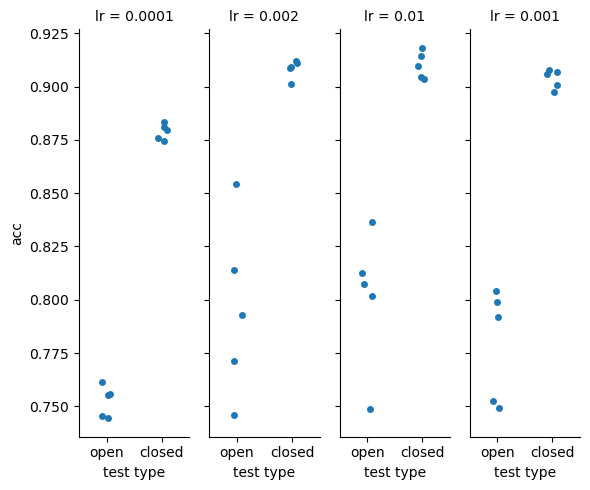

In [71]:
sns.catplot(performance_df, x ='test type', y ='acc', col='lr', aspect=0.3)

In [129]:
replicates = 5
batch_size = 100
dataset = one_vs_all_paths[1]
file = dataset.split('/')[-1].strip('.tsv')
df = pd.read_csv(dataset, sep='\t')
train_one_all, val_one_all,  test_one_all = train_val_test_prep(df, scale = False)
train_loader = DataLoader(train_one_all, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_one_all, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_one_all, batch_size=batch_size, shuffle=True)
for lr in tqdm([0.01, 0.002, 0.001, 0.0001], desc = 'Learning rate list'):
    for i in range(1, replicates+1):
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        model = MLP_2L(6,3).to(device)
        train_mlp(model, device, train_loader, 'MLP_2L_1_vs_all', f'{file}_layers_6_3_lr{lr}_repl_{i}', epochs=200, learning_rate = lr)

Learning rate list:   0%|          | 0/4 [00:00<?, ?it/s]

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.49540168046951294, Validation loss: 0.4055693447589874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.3642880618572235, Validation loss: 0.3507823050022125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.3119015097618103, Validation loss: 0.31629788875579834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.28324761986732483, Validation loss: 0.3024805188179016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.2704539895057678, Validation loss: 0.2971682548522949


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.2573258876800537, Validation loss: 0.29612189531326294


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2515096962451935, Validation loss: 0.28676214814186096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.24584095180034637, Validation loss: 0.28753775358200073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.24129167199134827, Validation loss: 0.284203439950943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.23924610018730164, Validation loss: 0.2816644310951233


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23565863072872162, Validation loss: 0.284678190946579


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2340250164270401, Validation loss: 0.28053581714630127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23139670491218567, Validation loss: 0.2824888229370117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2286052703857422, Validation loss: 0.2895205318927765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22765833139419556, Validation loss: 0.27931809425354004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2269771695137024, Validation loss: 0.2816278636455536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2252812385559082, Validation loss: 0.28146785497665405


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.22301672399044037, Validation loss: 0.2860192060470581


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.22332416474819183, Validation loss: 0.2839618921279907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22294455766677856, Validation loss: 0.27981215715408325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22118942439556122, Validation loss: 0.27699336409568787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22037601470947266, Validation loss: 0.27914828062057495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.22035308182239532, Validation loss: 0.2783016860485077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.21891510486602783, Validation loss: 0.2794437110424042


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.21891234815120697, Validation loss: 0.2791268527507782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21843168139457703, Validation loss: 0.28307947516441345


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21825122833251953, Validation loss: 0.27706313133239746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21744310855865479, Validation loss: 0.2778037190437317


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.21775174140930176, Validation loss: 0.2791283130645752


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.2171681523323059, Validation loss: 0.2826283276081085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.2167424112558365, Validation loss: 0.28039124608039856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.21574130654335022, Validation loss: 0.2800552248954773


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.21554379165172577, Validation loss: 0.2783288061618805


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.2144511342048645, Validation loss: 0.2798214852809906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.21389466524124146, Validation loss: 0.27734431624412537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.2147718071937561, Validation loss: 0.2779117822647095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2131580263376236, Validation loss: 0.2769991457462311


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.2146616131067276, Validation loss: 0.2819276750087738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.21294952929019928, Validation loss: 0.28251996636390686


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.21211758255958557, Validation loss: 0.2850366532802582


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.21302855014801025, Validation loss: 0.27982693910598755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.21214358508586884, Validation loss: 0.2778136432170868


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.21177084743976593, Validation loss: 0.27546271681785583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.21150058507919312, Validation loss: 0.2809965908527374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.21172289550304413, Validation loss: 0.27755486965179443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.21178044378757477, Validation loss: 0.2841333746910095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.2117481231689453, Validation loss: 0.2800513505935669


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.2100811004638672, Validation loss: 0.28103938698768616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.2105470597743988, Validation loss: 0.28190264105796814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.20964163541793823, Validation loss: 0.2799615263938904


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.2099822759628296, Validation loss: 0.2802414894104004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.21005873382091522, Validation loss: 0.2812178134918213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.2108733355998993, Validation loss: 0.27908724546432495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.20874762535095215, Validation loss: 0.28064659237861633


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.20852045714855194, Validation loss: 0.28290531039237976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.2086077332496643, Validation loss: 0.28352031111717224
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.48110008239746094, Validation loss: 0.4015917181968689


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.3571453392505646, Validation loss: 0.3489695191383362


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.3097412586212158, Validation loss: 0.3259967863559723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.2764100432395935, Validation loss: 0.3070974349975586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.26247701048851013, Validation loss: 0.2901035249233246


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.25105008482933044, Validation loss: 0.2908288240432739


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.24538485705852509, Validation loss: 0.2799937129020691


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.24038003385066986, Validation loss: 0.28758689761161804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.237613245844841, Validation loss: 0.27656257152557373


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.23295484483242035, Validation loss: 0.2760663628578186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23109039664268494, Validation loss: 0.2796371281147003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.228972390294075, Validation loss: 0.274605929851532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.226880744099617, Validation loss: 0.28146085143089294


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22798475623130798, Validation loss: 0.271309494972229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2250138223171234, Validation loss: 0.2729274034500122


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2238726019859314, Validation loss: 0.271601140499115


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.22177937626838684, Validation loss: 0.273044228553772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.22228704392910004, Validation loss: 0.28839221596717834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2232266664505005, Validation loss: 0.2778310775756836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22114351391792297, Validation loss: 0.279390424489975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.21985356509685516, Validation loss: 0.27770325541496277


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.21999205648899078, Validation loss: 0.2739497423171997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.21821896731853485, Validation loss: 0.27272510528564453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2198333889245987, Validation loss: 0.27793678641319275


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.21753008663654327, Validation loss: 0.27668437361717224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.21805930137634277, Validation loss: 0.28096523880958557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.21663491427898407, Validation loss: 0.27362537384033203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.21533790230751038, Validation loss: 0.277356892824173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.21487127244472504, Validation loss: 0.2760921120643616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.21488334238529205, Validation loss: 0.27488675713539124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.21426256000995636, Validation loss: 0.27660083770751953


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.2138376235961914, Validation loss: 0.2713509202003479


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.2133082151412964, Validation loss: 0.27631762623786926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.2138601690530777, Validation loss: 0.2744685411453247


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.21290437877178192, Validation loss: 0.26963338255882263


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.21238374710083008, Validation loss: 0.27224719524383545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.212918221950531, Validation loss: 0.279441773891449


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.2117435336112976, Validation loss: 0.27256593108177185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.21190398931503296, Validation loss: 0.27472880482673645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.21131113171577454, Validation loss: 0.2723211944103241


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.2113579660654068, Validation loss: 0.2717607617378235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.21188148856163025, Validation loss: 0.2779948115348816


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.2115614414215088, Validation loss: 0.27623921632766724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.21060645580291748, Validation loss: 0.2745790481567383


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.2101801037788391, Validation loss: 0.28018197417259216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.2093094438314438, Validation loss: 0.271764874458313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.20964522659778595, Validation loss: 0.27257978916168213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.2098010629415512, Validation loss: 0.27239927649497986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.20886945724487305, Validation loss: 0.27314427495002747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.20936143398284912, Validation loss: 0.2769087255001068


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.20900043845176697, Validation loss: 0.28145715594291687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.2093111127614975, Validation loss: 0.27434393763542175


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.20906463265419006, Validation loss: 0.27577102184295654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.20859916508197784, Validation loss: 0.28235000371932983


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.20877303183078766, Validation loss: 0.270998477935791


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.2087876796722412, Validation loss: 0.2767305374145508


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.20829997956752777, Validation loss: 0.2711256742477417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.207597017288208, Validation loss: 0.27341973781585693


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.20867495238780975, Validation loss: 0.2821124196052551


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.20852699875831604, Validation loss: 0.2767360806465149


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.2082725465297699, Validation loss: 0.27393263578414917


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.20786212384700775, Validation loss: 0.2787177860736847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.20810651779174805, Validation loss: 0.2814243733882904


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.20783813297748566, Validation loss: 0.27467402815818787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.20695871114730835, Validation loss: 0.27729663252830505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.20678305625915527, Validation loss: 0.2742670178413391


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.2063468098640442, Validation loss: 0.27200478315353394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.2085450440645218, Validation loss: 0.27316394448280334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.20698338747024536, Validation loss: 0.27397218346595764


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.20697854459285736, Validation loss: 0.28128063678741455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.2074730545282364, Validation loss: 0.27393412590026855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.20671677589416504, Validation loss: 0.2774136960506439


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.20594295859336853, Validation loss: 0.27390095591545105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.20671558380126953, Validation loss: 0.2804475724697113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.20579397678375244, Validation loss: 0.27332594990730286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.20616485178470612, Validation loss: 0.2747277021408081


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.20613835752010345, Validation loss: 0.27170661091804504


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.2060411423444748, Validation loss: 0.27901527285575867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.20621301233768463, Validation loss: 0.27260303497314453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.20622511208057404, Validation loss: 0.27363625168800354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.20565560460090637, Validation loss: 0.2801937460899353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.2064872533082962, Validation loss: 0.27161312103271484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.20521895587444305, Validation loss: 0.27661505341529846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.20626263320446014, Validation loss: 0.27621403336524963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.20570701360702515, Validation loss: 0.27585360407829285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.20530666410923004, Validation loss: 0.2756046652793884


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.20524227619171143, Validation loss: 0.2765820324420929


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.20637181401252747, Validation loss: 0.27737826108932495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.2059962898492813, Validation loss: 0.2775804102420807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.20549426972866058, Validation loss: 0.27588531374931335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.2057570070028305, Validation loss: 0.27358517050743103


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.20532462000846863, Validation loss: 0.281450092792511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.20515267550945282, Validation loss: 0.27809619903564453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.20476803183555603, Validation loss: 0.2806571125984192


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.2050675004720688, Validation loss: 0.2743750810623169


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.20470722019672394, Validation loss: 0.27546626329421997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.20454725623130798, Validation loss: 0.28210410475730896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.2047645002603531, Validation loss: 0.27621975541114807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.20484048128128052, Validation loss: 0.2781497538089752


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.20524491369724274, Validation loss: 0.27629372477531433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.2048959583044052, Validation loss: 0.2756049633026123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.20460109412670135, Validation loss: 0.27605926990509033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.2051945924758911, Validation loss: 0.2799392640590668


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.20350615680217743, Validation loss: 0.2825086712837219


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.20429019629955292, Validation loss: 0.2758450210094452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.20516259968280792, Validation loss: 0.2737405002117157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.20423659682273865, Validation loss: 0.27321138978004456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.2042669653892517, Validation loss: 0.2849784195423126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.2039039134979248, Validation loss: 0.2834111452102661


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.20561830699443817, Validation loss: 0.27790698409080505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.20553605258464813, Validation loss: 0.2819289267063141


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.20507347583770752, Validation loss: 0.2764139175415039


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.20467588305473328, Validation loss: 0.2722817659378052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.20398329198360443, Validation loss: 0.27288496494293213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.20418116450309753, Validation loss: 0.27423667907714844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.20440731942653656, Validation loss: 0.27467772364616394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.20437727868556976, Validation loss: 0.2744884788990021


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.20402278006076813, Validation loss: 0.27322423458099365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.2040349543094635, Validation loss: 0.2769046127796173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.20409993827342987, Validation loss: 0.27804893255233765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.20415203273296356, Validation loss: 0.274898886680603


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.2037980854511261, Validation loss: 0.272030234336853


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.20416174829006195, Validation loss: 0.2789468467235565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.20361490547657013, Validation loss: 0.28723642230033875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.20314191281795502, Validation loss: 0.2761029899120331


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.20371687412261963, Validation loss: 0.2762366831302643


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.2034311294555664, Validation loss: 0.2787337899208069


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.2031305432319641, Validation loss: 0.2810647189617157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.20294883847236633, Validation loss: 0.27617427706718445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2039809674024582, Validation loss: 0.27733081579208374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.20299118757247925, Validation loss: 0.2759489119052887


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.20323969423770905, Validation loss: 0.2778758406639099


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.20408640801906586, Validation loss: 0.2761847674846649


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.20326119661331177, Validation loss: 0.27946388721466064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.20346549153327942, Validation loss: 0.2760332226753235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 136/200 - Train loss: 0.20307298004627228, Validation loss: 0.27881360054016113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 137/200 - Train loss: 0.20407825708389282, Validation loss: 0.27627453207969666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 138/200 - Train loss: 0.2030544877052307, Validation loss: 0.27632957696914673
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5445694923400879, Validation loss: 0.48139268159866333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4543623626232147, Validation loss: 0.4511106014251709


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.3994762897491455, Validation loss: 0.36944809556007385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3374342620372772, Validation loss: 0.34440821409225464


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.31716784834861755, Validation loss: 0.3236296772956848


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.30216002464294434, Validation loss: 0.32513105869293213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2949084937572479, Validation loss: 0.3221557140350342


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28868404030799866, Validation loss: 0.319736123085022


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2827164828777313, Validation loss: 0.3209610879421234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2783049941062927, Validation loss: 0.3203328847885132


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.27657806873321533, Validation loss: 0.31801843643188477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2719061076641083, Validation loss: 0.3170417249202728


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.27038857340812683, Validation loss: 0.31605076789855957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.26787590980529785, Validation loss: 0.3141412138938904


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.26481130719184875, Validation loss: 0.31414949893951416


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.26482290029525757, Validation loss: 0.3113164007663727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.26387351751327515, Validation loss: 0.314823180437088


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2626577317714691, Validation loss: 0.3179073631763458


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2611609399318695, Validation loss: 0.31729602813720703


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2591770887374878, Validation loss: 0.3121424615383148


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2593010663986206, Validation loss: 0.3130609691143036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2577815353870392, Validation loss: 0.31305697560310364


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2560884654521942, Validation loss: 0.3124226927757263


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.256685733795166, Validation loss: 0.3149074912071228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.25504520535469055, Validation loss: 0.31438979506492615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2541906237602234, Validation loss: 0.30860209465026855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2530134618282318, Validation loss: 0.3081605136394501


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.25309497117996216, Validation loss: 0.31139490008354187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.25272783637046814, Validation loss: 0.3046375513076782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.2519395351409912, Validation loss: 0.3069472014904022


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.25168174505233765, Validation loss: 0.3091670274734497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.25260302424430847, Validation loss: 0.30667027831077576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.25157448649406433, Validation loss: 0.3072830140590668


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.2499879002571106, Validation loss: 0.3045275807380676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.24998928606510162, Validation loss: 0.31218430399894714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.25062504410743713, Validation loss: 0.3065451383590698


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2491699457168579, Validation loss: 0.30588582158088684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.2484799474477768, Validation loss: 0.31197643280029297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.24936550855636597, Validation loss: 0.30683979392051697


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.24848100543022156, Validation loss: 0.30866360664367676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.24826271831989288, Validation loss: 0.3149365782737732


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.24930524826049805, Validation loss: 0.3116215467453003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.2483927458524704, Validation loss: 0.3079434037208557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.2480466514825821, Validation loss: 0.3081399202346802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.24747012555599213, Validation loss: 0.30681759119033813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.24574069678783417, Validation loss: 0.3054405450820923


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.2469499409198761, Validation loss: 0.30806559324264526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.2462857961654663, Validation loss: 0.30569028854370117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.2452506572008133, Validation loss: 0.3114511966705322


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.2454080432653427, Validation loss: 0.30819758772850037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.24562028050422668, Validation loss: 0.30762141942977905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.24523554742336273, Validation loss: 0.3115285634994507


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.24461287260055542, Validation loss: 0.30653342604637146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.24507632851600647, Validation loss: 0.3101302981376648


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.24478648602962494, Validation loss: 0.30639737844467163


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.24387504160404205, Validation loss: 0.30575889348983765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.24339133501052856, Validation loss: 0.30824944376945496


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.24403409659862518, Validation loss: 0.3057417571544647


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.24424144625663757, Validation loss: 0.30647411942481995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.24366338551044464, Validation loss: 0.3083299398422241


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.2439526915550232, Validation loss: 0.3056737780570984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.2434099167585373, Validation loss: 0.31027135252952576
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5657293200492859, Validation loss: 0.5239622592926025


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4530676305294037, Validation loss: 0.4168420732021332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.3716607093811035, Validation loss: 0.3618745505809784


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.32267090678215027, Validation loss: 0.32496878504753113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.29661616683006287, Validation loss: 0.31420034170150757


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.27981412410736084, Validation loss: 0.3050808310508728


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2700534462928772, Validation loss: 0.30184486508369446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.26143160462379456, Validation loss: 0.2947932779788971


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2555167078971863, Validation loss: 0.2968371510505676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25113263726234436, Validation loss: 0.29062557220458984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24690912663936615, Validation loss: 0.29099467396736145


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24437452852725983, Validation loss: 0.2953815758228302


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2426844984292984, Validation loss: 0.29485517740249634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.24019542336463928, Validation loss: 0.2894374430179596


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.23851367831230164, Validation loss: 0.2832132577896118


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.23657207190990448, Validation loss: 0.2862658202648163


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.23650521039962769, Validation loss: 0.2876281142234802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.23414483666419983, Validation loss: 0.2855290174484253


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.23190250992774963, Validation loss: 0.27976828813552856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2308894693851471, Validation loss: 0.28352952003479004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.22974561154842377, Validation loss: 0.2823508679866791


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.22715292870998383, Validation loss: 0.27913710474967957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2272958904504776, Validation loss: 0.282340943813324


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2247104048728943, Validation loss: 0.2848840653896332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.22396905720233917, Validation loss: 0.2793411910533905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2220800220966339, Validation loss: 0.27937808632850647


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2234182506799698, Validation loss: 0.2823648452758789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.22278569638729095, Validation loss: 0.2818928360939026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.22164057195186615, Validation loss: 0.2771495282649994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.22072762250900269, Validation loss: 0.2862451672554016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.22036412358283997, Validation loss: 0.2791726291179657


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.22000627219676971, Validation loss: 0.28651881217956543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.21897447109222412, Validation loss: 0.28388622403144836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.21844835579395294, Validation loss: 0.2830721139907837


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.21963632106781006, Validation loss: 0.2836133539676666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.21718771755695343, Validation loss: 0.28528231382369995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2184920758008957, Validation loss: 0.28392815589904785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.21844342350959778, Validation loss: 0.2800173759460449


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.21616815030574799, Validation loss: 0.2845165431499481


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.21617712080478668, Validation loss: 0.2872328460216522


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.21569885313510895, Validation loss: 0.2847023010253906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.2170027792453766, Validation loss: 0.28738370537757874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.2162943333387375, Validation loss: 0.28685927391052246


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.2144363671541214, Validation loss: 0.28352800011634827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.21599745750427246, Validation loss: 0.2843342423439026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.21464648842811584, Validation loss: 0.2848949134349823


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.2143431305885315, Validation loss: 0.28324174880981445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.21393772959709167, Validation loss: 0.2864605188369751
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5022624731063843, Validation loss: 0.41895681619644165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.369417279958725, Validation loss: 0.3542923927307129


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.32168617844581604, Validation loss: 0.3227061629295349


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.2921562194824219, Validation loss: 0.30537426471710205


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.2752498686313629, Validation loss: 0.2921378016471863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.26140353083610535, Validation loss: 0.2867332696914673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2506498694419861, Validation loss: 0.2895488739013672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.24445874989032745, Validation loss: 0.2818845808506012


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2402774542570114, Validation loss: 0.28433385491371155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.236527681350708, Validation loss: 0.28426218032836914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23505768179893494, Validation loss: 0.2757425308227539


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23189102113246918, Validation loss: 0.27632129192352295


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22983455657958984, Validation loss: 0.27207958698272705


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22810424864292145, Validation loss: 0.2788800895214081


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22631803154945374, Validation loss: 0.276233434677124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2248479276895523, Validation loss: 0.27491679787635803


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.22385527193546295, Validation loss: 0.2745443284511566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.22219954431056976, Validation loss: 0.27336186170578003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.22046029567718506, Validation loss: 0.27325639128685


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.22214919328689575, Validation loss: 0.2770439088344574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2210107445716858, Validation loss: 0.27209749817848206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2192489355802536, Validation loss: 0.2755509912967682


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2169634848833084, Validation loss: 0.27617567777633667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2171718031167984, Validation loss: 0.27557599544525146
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.7080186009407043, Validation loss: 0.6972541809082031


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6941363215446472, Validation loss: 0.6935931444168091


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6932160258293152, Validation loss: 0.6932910680770874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6931872963905334, Validation loss: 0.6932835578918457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6931849122047424, Validation loss: 0.693161129951477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.6931952834129333, Validation loss: 0.693195641040802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.6931740641593933, Validation loss: 0.6931468844413757


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.6931787133216858, Validation loss: 0.6931966543197632


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.6931478381156921, Validation loss: 0.6930893659591675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.6931973099708557, Validation loss: 0.6931613683700562
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6351433396339417, Validation loss: 0.5586618185043335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.520446240901947, Validation loss: 0.48586493730545044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.45109719038009644, Validation loss: 0.4299732744693756


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3960999548435211, Validation loss: 0.3886473476886749


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3572481572628021, Validation loss: 0.3610512614250183


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3322882652282715, Validation loss: 0.34565725922584534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3130602538585663, Validation loss: 0.33417758345603943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.30047085881233215, Validation loss: 0.33242473006248474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2898435592651367, Validation loss: 0.322018027305603


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.28254371881484985, Validation loss: 0.3204856514930725


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.27699407935142517, Validation loss: 0.31462880969047546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2728813588619232, Validation loss: 0.31379565596580505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2681880593299866, Validation loss: 0.31204137206077576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2660796642303467, Validation loss: 0.3094502389431


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.26231345534324646, Validation loss: 0.30768561363220215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.25957584381103516, Validation loss: 0.3082738220691681


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2579299509525299, Validation loss: 0.30842325091362


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2557842433452606, Validation loss: 0.305956095457077


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2543385922908783, Validation loss: 0.3033372163772583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.25227174162864685, Validation loss: 0.3042999804019928


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.25184234976768494, Validation loss: 0.3030702471733093


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2500483989715576, Validation loss: 0.3034808933734894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.24906788766384125, Validation loss: 0.3003196716308594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.24752818048000336, Validation loss: 0.30051273107528687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2463466078042984, Validation loss: 0.2972310781478882


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.245771124958992, Validation loss: 0.2968379855155945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.24436278641223907, Validation loss: 0.2972308397293091


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.24307739734649658, Validation loss: 0.2936941683292389


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.24210087954998016, Validation loss: 0.29758429527282715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.24089021980762482, Validation loss: 0.29463621973991394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.24028292298316956, Validation loss: 0.29823851585388184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.23994401097297668, Validation loss: 0.2922836244106293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.23839859664440155, Validation loss: 0.29363003373146057


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.23893016576766968, Validation loss: 0.29404857754707336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.237091064453125, Validation loss: 0.2938563823699951


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.23572076857089996, Validation loss: 0.2929218113422394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2371446043252945, Validation loss: 0.29287078976631165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.23550035059452057, Validation loss: 0.2871219217777252


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.23345117270946503, Validation loss: 0.28901800513267517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.2337556630373001, Validation loss: 0.29314523935317993


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.23253704607486725, Validation loss: 0.2856510877609253


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.23180411756038666, Validation loss: 0.28588008880615234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.23104321956634521, Validation loss: 0.29050326347351074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.23088255524635315, Validation loss: 0.2865137755870819


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.22951704263687134, Validation loss: 0.28517454862594604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.22878694534301758, Validation loss: 0.2894091308116913


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.2285410761833191, Validation loss: 0.2865839898586273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.22830376029014587, Validation loss: 0.2870471477508545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.2277236431837082, Validation loss: 0.2862079441547394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.2271711528301239, Validation loss: 0.28579947352409363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.22691985964775085, Validation loss: 0.28317034244537354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.22588174045085907, Validation loss: 0.2825058102607727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.22553475201129913, Validation loss: 0.28604361414909363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.2255367785692215, Validation loss: 0.28319251537323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.2241043597459793, Validation loss: 0.2833159267902374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.2252076268196106, Validation loss: 0.2857729196548462
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5752208828926086, Validation loss: 0.4976792335510254


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.47071412205696106, Validation loss: 0.4601730704307556


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4339304566383362, Validation loss: 0.42612436413764954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.403174489736557, Validation loss: 0.4014337658882141


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.37804114818573, Validation loss: 0.38089895248413086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.35509786009788513, Validation loss: 0.3625727891921997


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3357517123222351, Validation loss: 0.3492891192436218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3200519382953644, Validation loss: 0.33862143754959106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3069896996021271, Validation loss: 0.33143338561058044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.29419776797294617, Validation loss: 0.3220039904117584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2834470570087433, Validation loss: 0.3146706819534302


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2744778096675873, Validation loss: 0.3086915612220764


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.26560768485069275, Validation loss: 0.3026861250400543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.25938475131988525, Validation loss: 0.3002627193927765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.25356996059417725, Validation loss: 0.295267254114151


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2493882030248642, Validation loss: 0.29400867223739624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.24505332112312317, Validation loss: 0.2947780191898346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.24187234044075012, Validation loss: 0.29049795866012573


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.23910683393478394, Validation loss: 0.2940048277378082


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.23702561855316162, Validation loss: 0.28820717334747314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2359217405319214, Validation loss: 0.2923785150051117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2343948930501938, Validation loss: 0.2848249673843384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.23125270009040833, Validation loss: 0.2884902358055115


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.23111183941364288, Validation loss: 0.2858678698539734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.22976996004581451, Validation loss: 0.2857086956501007


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2281934767961502, Validation loss: 0.28695055842399597


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.22725430130958557, Validation loss: 0.2866273820400238


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.22635430097579956, Validation loss: 0.2854323387145996


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2247599959373474, Validation loss: 0.285304456949234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.22387176752090454, Validation loss: 0.2871910035610199


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.22338423132896423, Validation loss: 0.2845108211040497
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5809476971626282, Validation loss: 0.48780491948127747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4638528525829315, Validation loss: 0.4539012610912323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4295954406261444, Validation loss: 0.4229433536529541


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4030771255493164, Validation loss: 0.40587255358695984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3760432302951813, Validation loss: 0.37911325693130493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.35231348872184753, Validation loss: 0.3645555377006531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3340703845024109, Validation loss: 0.3513323962688446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3191666305065155, Validation loss: 0.3430527150630951


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3085046708583832, Validation loss: 0.3359365463256836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3001306354999542, Validation loss: 0.33006352186203003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2932624816894531, Validation loss: 0.32958856225013733


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2890028953552246, Validation loss: 0.3246898651123047


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2845342755317688, Validation loss: 0.321210652589798


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.27974453568458557, Validation loss: 0.32002535462379456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2753373682498932, Validation loss: 0.319451242685318


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2725522816181183, Validation loss: 0.3109828233718872


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2692936658859253, Validation loss: 0.3100588619709015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2660702168941498, Validation loss: 0.3093491494655609


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2629343569278717, Validation loss: 0.3047403395175934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.261130154132843, Validation loss: 0.30461129546165466


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2584232985973358, Validation loss: 0.3023327887058258


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2562110424041748, Validation loss: 0.3038548529148102


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.25501295924186707, Validation loss: 0.30374234914779663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2524494528770447, Validation loss: 0.30103108286857605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.25118422508239746, Validation loss: 0.2990070581436157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.25001585483551025, Validation loss: 0.30011463165283203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.24917306005954742, Validation loss: 0.2984289228916168


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.24811123311519623, Validation loss: 0.29826146364212036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2470693141222, Validation loss: 0.29739832878112793


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.24512745440006256, Validation loss: 0.300577849149704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.24454395473003387, Validation loss: 0.29761743545532227


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.24342617392539978, Validation loss: 0.3005375266075134


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.24265331029891968, Validation loss: 0.29814887046813965
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6001933813095093, Validation loss: 0.5288823246955872


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.5121560096740723, Validation loss: 0.5040784478187561


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.48927679657936096, Validation loss: 0.481168270111084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4588663578033447, Validation loss: 0.44787871837615967


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.4259055256843567, Validation loss: 0.4197566509246826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.395357221364975, Validation loss: 0.3953813314437866


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3682185411453247, Validation loss: 0.37607675790786743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3466549515724182, Validation loss: 0.360108345746994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.328755259513855, Validation loss: 0.34712842106819153


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3139857351779938, Validation loss: 0.3366827070713043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3006640076637268, Validation loss: 0.32661211490631104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.29094526171684265, Validation loss: 0.3223048448562622


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.28352874517440796, Validation loss: 0.315221905708313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.27788642048835754, Validation loss: 0.31322363018989563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2731421887874603, Validation loss: 0.31184476613998413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2687188386917114, Validation loss: 0.30878040194511414


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2659177780151367, Validation loss: 0.3081721365451813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.26209017634391785, Validation loss: 0.30678635835647583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.25985097885131836, Validation loss: 0.3056182563304901


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2577805817127228, Validation loss: 0.3079065680503845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2560347020626068, Validation loss: 0.3057880699634552


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2544979155063629, Validation loss: 0.30739444494247437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.25386136770248413, Validation loss: 0.3030553460121155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.25169554352760315, Validation loss: 0.30582869052886963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2507898211479187, Validation loss: 0.3053882122039795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.24975824356079102, Validation loss: 0.3038313090801239


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.24923506379127502, Validation loss: 0.305860310792923
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6276320815086365, Validation loss: 0.5287792682647705


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.49805742502212524, Validation loss: 0.48861217498779297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4696846008300781, Validation loss: 0.4668765962123871


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.44992780685424805, Validation loss: 0.45051589608192444


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.43267688155174255, Validation loss: 0.43541011214256287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.41547468304634094, Validation loss: 0.42111340165138245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.39743557572364807, Validation loss: 0.40621447563171387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3794574439525604, Validation loss: 0.38873016834259033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.36200055480003357, Validation loss: 0.37229225039482117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3425821363925934, Validation loss: 0.356105774641037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.32520440220832825, Validation loss: 0.34472352266311646


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.31155839562416077, Validation loss: 0.33503514528274536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.29979658126831055, Validation loss: 0.32603174448013306


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2914264500141144, Validation loss: 0.3221319317817688


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.28410035371780396, Validation loss: 0.3165070712566376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2781684994697571, Validation loss: 0.313098669052124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.27361276745796204, Validation loss: 0.31230470538139343


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2690778076648712, Validation loss: 0.30720093846321106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.26605623960494995, Validation loss: 0.30565235018730164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.26254910230636597, Validation loss: 0.3051440119743347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.26000916957855225, Validation loss: 0.30487820506095886


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2575131058692932, Validation loss: 0.30348527431488037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2549160420894623, Validation loss: 0.3044942021369934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2539425790309906, Validation loss: 0.2998965084552765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.25259432196617126, Validation loss: 0.2995266020298004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.24984802305698395, Validation loss: 0.29819756746292114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.2482743114233017, Validation loss: 0.29812392592430115


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.24679410457611084, Validation loss: 0.29673051834106445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.24507929384708405, Validation loss: 0.29611727595329285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.24333986639976501, Validation loss: 0.29458239674568176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.2426777184009552, Validation loss: 0.293262779712677


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.24193675816059113, Validation loss: 0.29223209619522095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.24034951627254486, Validation loss: 0.2924526631832123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.2390536218881607, Validation loss: 0.29091477394104004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.23796847462654114, Validation loss: 0.2906908392906189


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.23752163350582123, Validation loss: 0.28962811827659607


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.2356921136379242, Validation loss: 0.28916844725608826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.23566073179244995, Validation loss: 0.2905946671962738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.23407115042209625, Validation loss: 0.2872445583343506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.23358485102653503, Validation loss: 0.2885475158691406


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.23282578587532043, Validation loss: 0.28719860315322876


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.2314910739660263, Validation loss: 0.28985825181007385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.23028628528118134, Validation loss: 0.2864550054073334
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6190959811210632, Validation loss: 0.5290785431861877


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4896664619445801, Validation loss: 0.47561967372894287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.45558804273605347, Validation loss: 0.453789621591568


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4347749948501587, Validation loss: 0.4387470483779907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.41751182079315186, Validation loss: 0.42297014594078064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.402079313993454, Validation loss: 0.4108346700668335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.38859671354293823, Validation loss: 0.3995189070701599


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.3747161626815796, Validation loss: 0.3911130428314209


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3626851439476013, Validation loss: 0.3811843693256378


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.34911367297172546, Validation loss: 0.36839327216148376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.3362842798233032, Validation loss: 0.3590185344219208


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.32652154564857483, Validation loss: 0.35076791048049927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.3172091543674469, Validation loss: 0.3455866873264313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.30997762084007263, Validation loss: 0.3376859128475189


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.30397486686706543, Validation loss: 0.3338576853275299


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2979605793952942, Validation loss: 0.33121174573898315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2939617931842804, Validation loss: 0.3275110125541687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2888883650302887, Validation loss: 0.3258047103881836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.28546926379203796, Validation loss: 0.32231953740119934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2827674448490143, Validation loss: 0.32214146852493286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.27890393137931824, Validation loss: 0.3214291036128998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2770499885082245, Validation loss: 0.31897130608558655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2739145755767822, Validation loss: 0.31818267703056335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.27207547426223755, Validation loss: 0.3176271319389343


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.27009013295173645, Validation loss: 0.3163350522518158


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.2673192322254181, Validation loss: 0.3147844672203064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.26663416624069214, Validation loss: 0.3144431412220001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.26470115780830383, Validation loss: 0.31368017196655273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.2623896598815918, Validation loss: 0.31280413269996643


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.26224377751350403, Validation loss: 0.3125532865524292


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.2604256272315979, Validation loss: 0.31152230501174927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.25974681973457336, Validation loss: 0.31351572275161743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.2579033672809601, Validation loss: 0.31149789690971375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.25676801800727844, Validation loss: 0.31128647923469543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.2557058334350586, Validation loss: 0.3120719790458679
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6307041645050049, Validation loss: 0.543302059173584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.48812299966812134, Validation loss: 0.465037077665329


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4339452385902405, Validation loss: 0.430133193731308


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.40268993377685547, Validation loss: 0.409807950258255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.38216620683670044, Validation loss: 0.3955255448818207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.367252379655838, Validation loss: 0.3827574551105499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.35497966408729553, Validation loss: 0.3728599548339844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.34393954277038574, Validation loss: 0.3670549690723419


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.3352522552013397, Validation loss: 0.35977497696876526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.32737311720848083, Validation loss: 0.353943407535553


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.32015931606292725, Validation loss: 0.35157155990600586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.3140031397342682, Validation loss: 0.3448948264122009


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.3083595335483551, Validation loss: 0.34045088291168213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.30349457263946533, Validation loss: 0.3368258774280548


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2995452880859375, Validation loss: 0.3344721496105194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.29522162675857544, Validation loss: 0.3314143419265747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.29119783639907837, Validation loss: 0.32607096433639526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.28773975372314453, Validation loss: 0.3242453634738922


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.28451958298683167, Validation loss: 0.3227541446685791


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2811409533023834, Validation loss: 0.32063427567481995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2780954837799072, Validation loss: 0.3171505630016327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2745346426963806, Validation loss: 0.3137335181236267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.27149736881256104, Validation loss: 0.3122284412384033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.26981738209724426, Validation loss: 0.308529257774353


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.26652228832244873, Validation loss: 0.3059511184692383


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.26396554708480835, Validation loss: 0.3043438494205475


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.26205113530158997, Validation loss: 0.3022100329399109


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.259250670671463, Validation loss: 0.2998928725719452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.25806617736816406, Validation loss: 0.3016219735145569


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.2562384605407715, Validation loss: 0.3003092110157013


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.2550317049026489, Validation loss: 0.29752370715141296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.2528274357318878, Validation loss: 0.29496023058891296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.2521440386772156, Validation loss: 0.2954261302947998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.2504810094833374, Validation loss: 0.29398250579833984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.24870216846466064, Validation loss: 0.29371941089630127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.247121661901474, Validation loss: 0.29048973321914673


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.24522905051708221, Validation loss: 0.29222241044044495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.24352966248989105, Validation loss: 0.29026296734809875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.24188587069511414, Validation loss: 0.28847089409828186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.24052748084068298, Validation loss: 0.2871260643005371


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.23990850150585175, Validation loss: 0.2872198224067688


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.23918157815933228, Validation loss: 0.2846301198005676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.23815174400806427, Validation loss: 0.28714537620544434


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.23663346469402313, Validation loss: 0.284188449382782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.23560668528079987, Validation loss: 0.28433138132095337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.23533907532691956, Validation loss: 0.28676092624664307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.23511996865272522, Validation loss: 0.28362682461738586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.23431004583835602, Validation loss: 0.2844563126564026
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.634120523929596, Validation loss: 0.5362874865531921


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.486802875995636, Validation loss: 0.469686359167099


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.44940879940986633, Validation loss: 0.44947192072868347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4284476935863495, Validation loss: 0.43057891726493835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.4092049300670624, Validation loss: 0.4148443043231964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3892337679862976, Validation loss: 0.3978334665298462


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3705023527145386, Validation loss: 0.38319167494773865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.35389503836631775, Validation loss: 0.3710106313228607


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.34008127450942993, Validation loss: 0.3617870807647705


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3283126652240753, Validation loss: 0.35300755500793457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.31773120164871216, Validation loss: 0.3452659845352173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.3092726767063141, Validation loss: 0.34077176451683044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.30119583010673523, Validation loss: 0.3349210023880005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2938014268875122, Validation loss: 0.3296405076980591


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.28748685121536255, Validation loss: 0.3262803852558136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2811426818370819, Validation loss: 0.32045382261276245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2756359577178955, Validation loss: 0.31752052903175354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2701393961906433, Validation loss: 0.3168894648551941


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.26596522331237793, Validation loss: 0.3122396171092987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.26172587275505066, Validation loss: 0.3082316219806671


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2579554319381714, Validation loss: 0.30437859892845154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.255005806684494, Validation loss: 0.30355122685432434


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.25214484333992004, Validation loss: 0.30182957649230957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.2489515244960785, Validation loss: 0.3020746111869812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.24705572426319122, Validation loss: 0.29873695969581604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.24592815339565277, Validation loss: 0.2955731153488159


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.24319513142108917, Validation loss: 0.29616066813468933


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.24210888147354126, Validation loss: 0.2942199110984802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.24070331454277039, Validation loss: 0.2933828830718994


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.23920144140720367, Validation loss: 0.29434260725975037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.23773570358753204, Validation loss: 0.2930753827095032


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.23726695775985718, Validation loss: 0.2929069697856903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.2360643744468689, Validation loss: 0.2923004925251007


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.23490393161773682, Validation loss: 0.293761670589447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.234205961227417, Validation loss: 0.2916105389595032
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6269088387489319, Validation loss: 0.5391044020652771


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4954741895198822, Validation loss: 0.4779374599456787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4586409032344818, Validation loss: 0.45577046275138855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.4375004470348358, Validation loss: 0.4378199577331543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.42035773396492004, Validation loss: 0.42405617237091064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.4044380784034729, Validation loss: 0.41103681921958923


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.38927462697029114, Validation loss: 0.3971501588821411


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.37287116050720215, Validation loss: 0.3821397125720978


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.35722780227661133, Validation loss: 0.3706502914428711


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.3424340784549713, Validation loss: 0.36061081290245056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.32959339022636414, Validation loss: 0.3485301733016968


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.3183520436286926, Validation loss: 0.3409471809864044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.3083373010158539, Validation loss: 0.3330153822898865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.29987820982933044, Validation loss: 0.32921409606933594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.29321831464767456, Validation loss: 0.32510703802108765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2866150438785553, Validation loss: 0.3224271535873413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.28149253129959106, Validation loss: 0.31961992383003235


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.27694302797317505, Validation loss: 0.3178102374076843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.273221492767334, Validation loss: 0.31439870595932007


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.26889798045158386, Validation loss: 0.31405964493751526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.2660163342952728, Validation loss: 0.31118112802505493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2632031738758087, Validation loss: 0.3080523908138275


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.2604863941669464, Validation loss: 0.3089858293533325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.25814539194107056, Validation loss: 0.3063350021839142


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.2559761106967926, Validation loss: 0.305938720703125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.25466060638427734, Validation loss: 0.30335497856140137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.25234368443489075, Validation loss: 0.3027156889438629


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.25083765387535095, Validation loss: 0.30114078521728516


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.24907253682613373, Validation loss: 0.30074915289878845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.24776364862918854, Validation loss: 0.30034029483795166


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.24651996791362762, Validation loss: 0.30356523394584656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.24544090032577515, Validation loss: 0.2978864014148712


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.24472738802433014, Validation loss: 0.2977167069911957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.24316930770874023, Validation loss: 0.2963673770427704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.2422301471233368, Validation loss: 0.29742348194122314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.24119117856025696, Validation loss: 0.2971574664115906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.23999065160751343, Validation loss: 0.2960599958896637


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.23874090611934662, Validation loss: 0.29472219944000244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.23841652274131775, Validation loss: 0.29426535964012146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.2368117719888687, Validation loss: 0.2964620888233185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.23672524094581604, Validation loss: 0.29213500022888184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.2351544201374054, Validation loss: 0.29323869943618774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.23477572202682495, Validation loss: 0.2929745614528656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.23489269614219666, Validation loss: 0.2928825616836548


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.2337629348039627, Validation loss: 0.29260969161987305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.23241615295410156, Validation loss: 0.2911355197429657


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.2323543280363083, Validation loss: 0.2901119291782379


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.23117683827877045, Validation loss: 0.2903175354003906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.23055535554885864, Validation loss: 0.2919202744960785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.2305973917245865, Validation loss: 0.292140930891037
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.711767315864563, Validation loss: 0.705816924571991


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.7017967700958252, Validation loss: 0.6911887526512146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6824180483818054, Validation loss: 0.6721093058586121


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6606979370117188, Validation loss: 0.6504383683204651


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6385692954063416, Validation loss: 0.630940854549408


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.6191364526748657, Validation loss: 0.6137653589248657


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.6020752787590027, Validation loss: 0.5988211631774902


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5869260430335999, Validation loss: 0.5854656100273132


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5733045339584351, Validation loss: 0.5736626386642456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5612993836402893, Validation loss: 0.5622719526290894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5506206750869751, Validation loss: 0.5533254742622375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5406731367111206, Validation loss: 0.5441015958786011


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5322706699371338, Validation loss: 0.5367091298103333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.5244766473770142, Validation loss: 0.5298322439193726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.51708984375, Validation loss: 0.5234212279319763


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.5105351209640503, Validation loss: 0.517247200012207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.5043734908103943, Validation loss: 0.5119484663009644


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4985324442386627, Validation loss: 0.5066086649894714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.49343711137771606, Validation loss: 0.5024310946464539


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.48814088106155396, Validation loss: 0.4972158372402191


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.48349353671073914, Validation loss: 0.4925832748413086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.47842341661453247, Validation loss: 0.4874471127986908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.47406938672065735, Validation loss: 0.48312366008758545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4699993431568146, Validation loss: 0.4788297712802887


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.4657600522041321, Validation loss: 0.47494831681251526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.4615134596824646, Validation loss: 0.47112831473350525


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.4572964608669281, Validation loss: 0.4677625000476837


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.45375537872314453, Validation loss: 0.4641394019126892


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4503822326660156, Validation loss: 0.4602457582950592


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.44623005390167236, Validation loss: 0.45681896805763245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.44312340021133423, Validation loss: 0.4547024369239807


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.4396252930164337, Validation loss: 0.4515600800514221


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.4363674223423004, Validation loss: 0.44809502363204956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4335658550262451, Validation loss: 0.44520825147628784


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4297318458557129, Validation loss: 0.44193896651268005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.42657119035720825, Validation loss: 0.4396601617336273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4239256680011749, Validation loss: 0.43543383479118347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.42126595973968506, Validation loss: 0.4342919588088989


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4180436432361603, Validation loss: 0.4315240979194641


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.41487354040145874, Validation loss: 0.42878207564353943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.412208616733551, Validation loss: 0.4259995222091675


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.4094747304916382, Validation loss: 0.4233083426952362


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.40651026368141174, Validation loss: 0.4208603501319885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.40437930822372437, Validation loss: 0.41826632618904114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.40166184306144714, Validation loss: 0.4163985848426819


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.3992237448692322, Validation loss: 0.4144313633441925


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.3968459963798523, Validation loss: 0.4125601351261139


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.3944731056690216, Validation loss: 0.4100109338760376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.39192500710487366, Validation loss: 0.40801432728767395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.39026081562042236, Validation loss: 0.40639251470565796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.3877755403518677, Validation loss: 0.40560397505760193


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.38589605689048767, Validation loss: 0.4033837616443634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.3836587071418762, Validation loss: 0.40120255947113037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.38198503851890564, Validation loss: 0.40018290281295776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.38035041093826294, Validation loss: 0.3999147415161133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.3784177601337433, Validation loss: 0.39735013246536255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.3769088387489319, Validation loss: 0.3957871198654175


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.37538284063339233, Validation loss: 0.3948517143726349


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.3732273578643799, Validation loss: 0.3927842378616333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.37162119150161743, Validation loss: 0.3923143446445465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.37014448642730713, Validation loss: 0.3915018141269684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.3687860369682312, Validation loss: 0.3901628851890564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.3676510751247406, Validation loss: 0.3889268934726715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.3661414682865143, Validation loss: 0.3885243237018585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.3646526038646698, Validation loss: 0.38686177134513855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.3633672893047333, Validation loss: 0.3861478567123413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.36215415596961975, Validation loss: 0.3844744563102722


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.36110493540763855, Validation loss: 0.38462528586387634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.35988643765449524, Validation loss: 0.3829856216907501


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.35914307832717896, Validation loss: 0.3837302029132843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3576778769493103, Validation loss: 0.38239428400993347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.35674944519996643, Validation loss: 0.3813179135322571


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.35550549626350403, Validation loss: 0.38188502192497253


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.35501641035079956, Validation loss: 0.37949904799461365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.35363197326660156, Validation loss: 0.3800199031829834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.35272639989852905, Validation loss: 0.37896955013275146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.35238829255104065, Validation loss: 0.37870198488235474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.3510541617870331, Validation loss: 0.37821653485298157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3504429757595062, Validation loss: 0.37712329626083374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3490932285785675, Validation loss: 0.3775743544101715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.34819895029067993, Validation loss: 0.3770166039466858
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6972998976707458, Validation loss: 0.6954622864723206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6956025958061218, Validation loss: 0.6929579377174377


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.691817581653595, Validation loss: 0.6880621314048767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.682288646697998, Validation loss: 0.668387234210968


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6550253033638, Validation loss: 0.6427801847457886


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.628666877746582, Validation loss: 0.618152916431427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.6034662127494812, Validation loss: 0.5948262214660645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5802222490310669, Validation loss: 0.5739523768424988


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5601390600204468, Validation loss: 0.5565152764320374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5431514382362366, Validation loss: 0.5426140427589417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5293675661087036, Validation loss: 0.5299880504608154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5166895985603333, Validation loss: 0.5202914476394653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5069627165794373, Validation loss: 0.5123271942138672


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.498831182718277, Validation loss: 0.5054836273193359


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.4928117096424103, Validation loss: 0.5006087422370911


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.4873993992805481, Validation loss: 0.49592462182044983


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.48330432176589966, Validation loss: 0.4923529624938965


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4787209928035736, Validation loss: 0.4888572692871094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.4745491147041321, Validation loss: 0.4852154552936554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.471230149269104, Validation loss: 0.4813806712627411


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.4674704670906067, Validation loss: 0.4786285161972046


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.4642687439918518, Validation loss: 0.4754457473754883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.4609101414680481, Validation loss: 0.47221583127975464


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4571206867694855, Validation loss: 0.469545841217041


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.45431050658226013, Validation loss: 0.46672290563583374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.45072638988494873, Validation loss: 0.46473610401153564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.44794854521751404, Validation loss: 0.4607882797718048


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.44454634189605713, Validation loss: 0.4588049352169037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4416515529155731, Validation loss: 0.4559251070022583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.4387156069278717, Validation loss: 0.45301809906959534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.43591436743736267, Validation loss: 0.4500746726989746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.432797908782959, Validation loss: 0.44737428426742554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.43034806847572327, Validation loss: 0.44567736983299255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4277362525463104, Validation loss: 0.44338440895080566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.42488762736320496, Validation loss: 0.4407704174518585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.42269229888916016, Validation loss: 0.4384118914604187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.41988512873649597, Validation loss: 0.43576517701148987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.41750475764274597, Validation loss: 0.43368396162986755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.41498568654060364, Validation loss: 0.43189528584480286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.41297978162765503, Validation loss: 0.42971181869506836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.41062411665916443, Validation loss: 0.42826709151268005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.4081317186355591, Validation loss: 0.425184428691864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.40635621547698975, Validation loss: 0.42295247316360474


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.40357550978660583, Validation loss: 0.42141324281692505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4014846980571747, Validation loss: 0.42024320363998413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.3997899889945984, Validation loss: 0.41900891065597534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.39742591977119446, Validation loss: 0.4161217212677002


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.395600825548172, Validation loss: 0.4145241975784302


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.3937914967536926, Validation loss: 0.41282981634140015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.391754686832428, Validation loss: 0.41207098960876465


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.3901500999927521, Validation loss: 0.40989580750465393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.3879597783088684, Validation loss: 0.40838029980659485


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.38656872510910034, Validation loss: 0.4070092439651489


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.38463732600212097, Validation loss: 0.40493881702423096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.3827844262123108, Validation loss: 0.40396496653556824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.3817065954208374, Validation loss: 0.4021192491054535


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.3794362246990204, Validation loss: 0.4009900987148285


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.37819182872772217, Validation loss: 0.39965686202049255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.3762824237346649, Validation loss: 0.3980916738510132


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.374784380197525, Validation loss: 0.39695194363594055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.3733256161212921, Validation loss: 0.39591115713119507


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.3716355562210083, Validation loss: 0.39534106850624084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.37032952904701233, Validation loss: 0.3930418789386749


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.36880066990852356, Validation loss: 0.3916511535644531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.3675341308116913, Validation loss: 0.3906630575656891


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.3658154010772705, Validation loss: 0.38991427421569824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3645637035369873, Validation loss: 0.38868409395217896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.36276775598526, Validation loss: 0.388529509305954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.3611465096473694, Validation loss: 0.38580405712127686


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.3598918318748474, Validation loss: 0.38511621952056885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3582872152328491, Validation loss: 0.3842289447784424


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.35698264837265015, Validation loss: 0.38256123661994934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.35525938868522644, Validation loss: 0.3819802403450012


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.3538398742675781, Validation loss: 0.3811018466949463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3521910607814789, Validation loss: 0.3793676197528839


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3511379659175873, Validation loss: 0.3777466118335724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.3492397367954254, Validation loss: 0.37635117769241333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.34824246168136597, Validation loss: 0.3751735985279083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3467310070991516, Validation loss: 0.37470489740371704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.34523898363113403, Validation loss: 0.3736242353916168


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.34373441338539124, Validation loss: 0.3719426691532135


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.34268811345100403, Validation loss: 0.37093502283096313


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.34098634123802185, Validation loss: 0.3702123761177063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.34022510051727295, Validation loss: 0.36958834528923035


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3387756943702698, Validation loss: 0.3677399754524231


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.33727195858955383, Validation loss: 0.3663007616996765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.3359301686286926, Validation loss: 0.36572399735450745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.3348192274570465, Validation loss: 0.36420226097106934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.3334735631942749, Validation loss: 0.3640305697917938


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.3322660028934479, Validation loss: 0.36205199360847473


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.330765038728714, Validation loss: 0.3610641360282898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.32941699028015137, Validation loss: 0.36001303791999817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3285398781299591, Validation loss: 0.35858091711997986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.327364057302475, Validation loss: 0.3582700490951538


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3262117803096771, Validation loss: 0.3571873605251312


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.3246428966522217, Validation loss: 0.3560248613357544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.32392436265945435, Validation loss: 0.3550328314304352


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.32245051860809326, Validation loss: 0.3538069427013397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.3214852511882782, Validation loss: 0.35307949781417847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.3201606273651123, Validation loss: 0.35232406854629517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.3192594647407532, Validation loss: 0.35089465975761414


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.31815966963768005, Validation loss: 0.3508463501930237


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.3168865144252777, Validation loss: 0.34897351264953613


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3160395324230194, Validation loss: 0.3484472632408142


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.31494414806365967, Validation loss: 0.34733638167381287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.31372684240341187, Validation loss: 0.3466234803199768


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.3129538595676422, Validation loss: 0.34492406249046326


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.31177330017089844, Validation loss: 0.3455580472946167


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3106575906276703, Validation loss: 0.34395235776901245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.309460312128067, Validation loss: 0.3430326581001282


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.30845677852630615, Validation loss: 0.34203293919563293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.3080303370952606, Validation loss: 0.341111421585083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.3074707090854645, Validation loss: 0.341574490070343


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.30587729811668396, Validation loss: 0.33973315358161926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.30541491508483887, Validation loss: 0.33937928080558777


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.3038409948348999, Validation loss: 0.3388367295265198


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.3029935657978058, Validation loss: 0.33846792578697205


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.30253034830093384, Validation loss: 0.3378053903579712


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.30164429545402527, Validation loss: 0.33678528666496277


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.3005225658416748, Validation loss: 0.33497604727745056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.29989174008369446, Validation loss: 0.3352116048336029


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.2989044785499573, Validation loss: 0.3341112732887268


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.29814285039901733, Validation loss: 0.33408603072166443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.29774653911590576, Validation loss: 0.333260715007782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.29676222801208496, Validation loss: 0.3332678973674774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.2960284650325775, Validation loss: 0.3314186930656433


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.29531577229499817, Validation loss: 0.33054307103157043


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.29436108469963074, Validation loss: 0.3307132422924042


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.29382961988449097, Validation loss: 0.33049264550209045
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6939560770988464, Validation loss: 0.692410409450531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6906085014343262, Validation loss: 0.6870166659355164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6813156604766846, Validation loss: 0.6746004819869995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.665378987789154, Validation loss: 0.6565936207771301


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6445183753967285, Validation loss: 0.6350334286689758


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.620917022228241, Validation loss: 0.6119888424873352


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.5969286561012268, Validation loss: 0.5897243022918701


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5749797821044922, Validation loss: 0.5697660446166992


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5554952621459961, Validation loss: 0.5529392957687378


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5397821664810181, Validation loss: 0.5398395657539368


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5270783305168152, Validation loss: 0.529092013835907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5177720189094543, Validation loss: 0.5217572450637817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5098918080329895, Validation loss: 0.5156911015510559


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.5042298436164856, Validation loss: 0.5110087990760803


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.49975791573524475, Validation loss: 0.5070313215255737


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.49591174721717834, Validation loss: 0.5033078193664551


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.4926636219024658, Validation loss: 0.500849187374115


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4899575114250183, Validation loss: 0.49810609221458435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.4875181019306183, Validation loss: 0.4963856041431427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.48568668961524963, Validation loss: 0.4948652386665344


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.48368287086486816, Validation loss: 0.4931442141532898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.48194706439971924, Validation loss: 0.49130159616470337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.48028865456581116, Validation loss: 0.4895395338535309


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4786348044872284, Validation loss: 0.4882120192050934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.47685423493385315, Validation loss: 0.4863865077495575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.47563809156417847, Validation loss: 0.48516181111335754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.47416016459465027, Validation loss: 0.48388347029685974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.4723230004310608, Validation loss: 0.48227089643478394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4705340564250946, Validation loss: 0.48112475872039795


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.46888771653175354, Validation loss: 0.4785480797290802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.46698519587516785, Validation loss: 0.47753116488456726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.4653186500072479, Validation loss: 0.47549155354499817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.4628724157810211, Validation loss: 0.47400400042533875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.46108752489089966, Validation loss: 0.47181153297424316


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4588821232318878, Validation loss: 0.46898186206817627


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.45648548007011414, Validation loss: 0.46758735179901123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4540647268295288, Validation loss: 0.46517983078956604


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.45236754417419434, Validation loss: 0.46358394622802734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.45036375522613525, Validation loss: 0.4611196517944336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.44794923067092896, Validation loss: 0.45909494161605835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.44588008522987366, Validation loss: 0.45741114020347595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.44397711753845215, Validation loss: 0.4554268419742584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.4418880045413971, Validation loss: 0.4531250298023224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.4398908019065857, Validation loss: 0.4513368010520935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4382147789001465, Validation loss: 0.4498782753944397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.43593060970306396, Validation loss: 0.4479753077030182


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.4338112771511078, Validation loss: 0.44607892632484436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.43182477355003357, Validation loss: 0.44360339641571045


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4299599528312683, Validation loss: 0.44159671664237976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.4277265965938568, Validation loss: 0.4405530095100403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.42582598328590393, Validation loss: 0.43834754824638367


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.4239029884338379, Validation loss: 0.4366646111011505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.4217558801174164, Validation loss: 0.4352587163448334


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.41963696479797363, Validation loss: 0.43281081318855286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.41794633865356445, Validation loss: 0.43091368675231934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.4158688187599182, Validation loss: 0.4287150204181671


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.4135720133781433, Validation loss: 0.42738133668899536


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.4120284616947174, Validation loss: 0.4250326156616211


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.4096015989780426, Validation loss: 0.42412808537483215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.4076400399208069, Validation loss: 0.42132145166397095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.4055407643318176, Validation loss: 0.4195000231266022


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.4038633108139038, Validation loss: 0.417320191860199


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.40158751606941223, Validation loss: 0.41658827662467957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.3998052477836609, Validation loss: 0.41468334197998047


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.39778420329093933, Validation loss: 0.41234201192855835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.3960309624671936, Validation loss: 0.41145560145378113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.393914133310318, Validation loss: 0.4088253080844879


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.3916717767715454, Validation loss: 0.40709564089775085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.39019203186035156, Validation loss: 0.4063110649585724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.38816291093826294, Validation loss: 0.4040910601615906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3858022391796112, Validation loss: 0.40204963088035583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.38417676091194153, Validation loss: 0.40184518694877625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.38203567266464233, Validation loss: 0.39880335330963135


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.38002607226371765, Validation loss: 0.3973248600959778


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3781462013721466, Validation loss: 0.3956874907016754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.37606704235076904, Validation loss: 0.39388418197631836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.3741922378540039, Validation loss: 0.3927851617336273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.37194013595581055, Validation loss: 0.3913205862045288


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.37044277787208557, Validation loss: 0.3898145258426666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.36822599172592163, Validation loss: 0.38753971457481384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3663530647754669, Validation loss: 0.3863344192504883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.36423203349113464, Validation loss: 0.38411420583724976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.3625339865684509, Validation loss: 0.3828773498535156


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.3605164587497711, Validation loss: 0.3818149268627167


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3584597110748291, Validation loss: 0.37936094403266907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.35695043206214905, Validation loss: 0.3787959814071655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.35526856780052185, Validation loss: 0.37715521454811096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.3534771800041199, Validation loss: 0.3761514723300934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.3516886234283447, Validation loss: 0.37438908219337463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.35006725788116455, Validation loss: 0.3737310469150543


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.34810879826545715, Validation loss: 0.37196084856987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.34655332565307617, Validation loss: 0.3702743649482727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3452697992324829, Validation loss: 0.36860141158103943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.3433905839920044, Validation loss: 0.36727121472358704


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3421124219894409, Validation loss: 0.365825355052948


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.3399984836578369, Validation loss: 0.3664887845516205


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.33867835998535156, Validation loss: 0.3635686933994293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.33723166584968567, Validation loss: 0.36265525221824646


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.3356717824935913, Validation loss: 0.360849529504776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.33396822214126587, Validation loss: 0.3599952459335327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.33235782384872437, Validation loss: 0.3596176207065582


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.33109381794929504, Validation loss: 0.3583618104457855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.33000805974006653, Validation loss: 0.35709819197654724


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.328169047832489, Validation loss: 0.3566947281360626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.32659590244293213, Validation loss: 0.35569629073143005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.32546401023864746, Validation loss: 0.35358336567878723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.32447677850723267, Validation loss: 0.3540576696395874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.322747141122818, Validation loss: 0.3526107370853424


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3215715289115906, Validation loss: 0.3524852395057678


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.3200400769710541, Validation loss: 0.35092127323150635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.318950355052948, Validation loss: 0.3497726321220398


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.3175622522830963, Validation loss: 0.3492957055568695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.31643638014793396, Validation loss: 0.34809738397598267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.31536999344825745, Validation loss: 0.34855762124061584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.31438466906547546, Validation loss: 0.34667977690696716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.31309565901756287, Validation loss: 0.34694963693618774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.31190988421440125, Validation loss: 0.34500589966773987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.31078818440437317, Validation loss: 0.34441348910331726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.3095196783542633, Validation loss: 0.34398984909057617


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.3086544871330261, Validation loss: 0.3446417450904846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.3076840937137604, Validation loss: 0.3438858389854431


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.30675792694091797, Validation loss: 0.3415996730327606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.30562007427215576, Validation loss: 0.34261009097099304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.30494529008865356, Validation loss: 0.3413103222846985


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.30353111028671265, Validation loss: 0.3412817120552063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.30293768644332886, Validation loss: 0.33998772501945496


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.3017732799053192, Validation loss: 0.3391760587692261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.3007536828517914, Validation loss: 0.3393844962120056


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.30067262053489685, Validation loss: 0.33813971281051636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.2995165288448334, Validation loss: 0.3396962583065033


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.29835978150367737, Validation loss: 0.3373524248600006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.2977060079574585, Validation loss: 0.33704227209091187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 133/200 - Train loss: 0.2966040074825287, Validation loss: 0.336242139339447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 134/200 - Train loss: 0.2960231602191925, Validation loss: 0.3364909291267395


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 135/200 - Train loss: 0.2954811155796051, Validation loss: 0.3351720869541168
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.7027143836021423, Validation loss: 0.701226532459259


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6962974667549133, Validation loss: 0.6940680146217346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6878345608711243, Validation loss: 0.6840426921844482


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.677725076675415, Validation loss: 0.6747730374336243


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6672526597976685, Validation loss: 0.6640924215316772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.6557722687721252, Validation loss: 0.6533334255218506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.644321620464325, Validation loss: 0.6429631114006042


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.6336829662322998, Validation loss: 0.6335139870643616


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.6237531900405884, Validation loss: 0.6245606541633606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.6146939396858215, Validation loss: 0.6164591312408447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.6063337922096252, Validation loss: 0.6087676882743835


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5985246300697327, Validation loss: 0.601803183555603


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5915107131004333, Validation loss: 0.5948063135147095


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.5850757956504822, Validation loss: 0.5894345045089722


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.5786066055297852, Validation loss: 0.5838093161582947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.5728658437728882, Validation loss: 0.5789107084274292


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.5672784447669983, Validation loss: 0.573922336101532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.5620352625846863, Validation loss: 0.5688028335571289


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.5571762323379517, Validation loss: 0.5643833875656128


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.5524348616600037, Validation loss: 0.5599740147590637


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.5478227138519287, Validation loss: 0.5555523633956909


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.5434377193450928, Validation loss: 0.5506847500801086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.5389610528945923, Validation loss: 0.5474387407302856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.5345210433006287, Validation loss: 0.5431849360466003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.5307862162590027, Validation loss: 0.538918673992157


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.5265223979949951, Validation loss: 0.5350159406661987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.5225417613983154, Validation loss: 0.5313630700111389


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.5186755061149597, Validation loss: 0.5276908874511719


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.5149533748626709, Validation loss: 0.5248531103134155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.5114731788635254, Validation loss: 0.5212637782096863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.5078619718551636, Validation loss: 0.5177837610244751


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.5041760206222534, Validation loss: 0.5149486660957336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.5010528564453125, Validation loss: 0.5114503502845764


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.4975782334804535, Validation loss: 0.5083310604095459


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.4944228231906891, Validation loss: 0.5057281851768494


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.4911092221736908, Validation loss: 0.5023933053016663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4881650507450104, Validation loss: 0.49908247590065


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.4850779175758362, Validation loss: 0.4965553283691406


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4823053479194641, Validation loss: 0.49411216378211975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.47911322116851807, Validation loss: 0.4917769432067871


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.4761984050273895, Validation loss: 0.48828068375587463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.473275363445282, Validation loss: 0.48585566878318787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.4709593653678894, Validation loss: 0.4834388494491577


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.46798035502433777, Validation loss: 0.4809582531452179


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4652535319328308, Validation loss: 0.4781043529510498


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.46253955364227295, Validation loss: 0.47548753023147583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.4599590003490448, Validation loss: 0.47332143783569336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.45748695731163025, Validation loss: 0.47092270851135254


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.4546889364719391, Validation loss: 0.46807241439819336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.45256638526916504, Validation loss: 0.4657125473022461


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.44999051094055176, Validation loss: 0.4632454216480255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.44775474071502686, Validation loss: 0.46212148666381836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.445486843585968, Validation loss: 0.45954176783561707


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.4427502453327179, Validation loss: 0.45667800307273865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.4408005475997925, Validation loss: 0.45506682991981506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.438438355922699, Validation loss: 0.4522978663444519


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.43616464734077454, Validation loss: 0.4504184126853943


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.43422991037368774, Validation loss: 0.448446661233902


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.43169182538986206, Validation loss: 0.44658344984054565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.4300415515899658, Validation loss: 0.444313108921051


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.4277486503124237, Validation loss: 0.44300031661987305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.4255037009716034, Validation loss: 0.44076645374298096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.4234679043292999, Validation loss: 0.4388970136642456


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.4214174449443817, Validation loss: 0.4374238848686218


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.4194314777851105, Validation loss: 0.4359542429447174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.4173518419265747, Validation loss: 0.4341931939125061


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.41541510820388794, Validation loss: 0.4322790503501892


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.41367509961128235, Validation loss: 0.4300597906112671


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.41164910793304443, Validation loss: 0.4286952614784241


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.41001930832862854, Validation loss: 0.4275663197040558


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.40836310386657715, Validation loss: 0.42578640580177307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.40636685490608215, Validation loss: 0.4244520366191864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.4047750234603882, Validation loss: 0.422569215297699


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.4030159115791321, Validation loss: 0.4207797050476074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.4011867344379425, Validation loss: 0.4191519320011139


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.39923539757728577, Validation loss: 0.4178301692008972


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.3977619409561157, Validation loss: 0.4168775677680969


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.3959623873233795, Validation loss: 0.41456854343414307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3945680856704712, Validation loss: 0.4131260812282562


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3928509056568146, Validation loss: 0.41181328892707825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.39144015312194824, Validation loss: 0.4109267294406891


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.38958051800727844, Validation loss: 0.4092232882976532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.3885785937309265, Validation loss: 0.4082026183605194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.3866347372531891, Validation loss: 0.4072992503643036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.38517239689826965, Validation loss: 0.4055231213569641


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.3839370310306549, Validation loss: 0.40413394570350647


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.38285407423973083, Validation loss: 0.40277233719825745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.38075101375579834, Validation loss: 0.4018591642379761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.37975773215293884, Validation loss: 0.40084904432296753


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.3782343566417694, Validation loss: 0.39947476983070374


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3768589496612549, Validation loss: 0.40011534094810486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.37564703822135925, Validation loss: 0.39722177386283875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.374437153339386, Validation loss: 0.396675169467926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.373203843832016, Validation loss: 0.3953506350517273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.37189236283302307, Validation loss: 0.3944407105445862


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.3706156313419342, Validation loss: 0.3934113085269928


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.3692719042301178, Validation loss: 0.3929997384548187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.36800938844680786, Validation loss: 0.39160364866256714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.3670901954174042, Validation loss: 0.39061474800109863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.3658400774002075, Validation loss: 0.3898456394672394


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.3650089204311371, Validation loss: 0.38818806409835815


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.36335334181785583, Validation loss: 0.3878398835659027


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.36244019865989685, Validation loss: 0.38673266768455505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3613070845603943, Validation loss: 0.3856523334980011


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.3600541651248932, Validation loss: 0.3847478926181793


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.3590146005153656, Validation loss: 0.3837316632270813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.35795092582702637, Validation loss: 0.3828062117099762


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.35716578364372253, Validation loss: 0.3828595280647278


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3557833731174469, Validation loss: 0.3821728825569153


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.35499560832977295, Validation loss: 0.3810959756374359


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.3540591597557068, Validation loss: 0.3793397843837738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.3529280722141266, Validation loss: 0.37919673323631287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.3520562946796417, Validation loss: 0.37947216629981995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 114/200 - Train loss: 0.35107213258743286, Validation loss: 0.3776257038116455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 115/200 - Train loss: 0.3500613570213318, Validation loss: 0.37733474373817444


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 116/200 - Train loss: 0.3487812280654907, Validation loss: 0.37614524364471436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 117/200 - Train loss: 0.34786516427993774, Validation loss: 0.37527602910995483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 118/200 - Train loss: 0.3469579517841339, Validation loss: 0.3749091625213623


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 119/200 - Train loss: 0.3462803065776825, Validation loss: 0.37407398223876953


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 120/200 - Train loss: 0.34518828988075256, Validation loss: 0.373366117477417


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 121/200 - Train loss: 0.3443956971168518, Validation loss: 0.37331146001815796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 122/200 - Train loss: 0.34337273240089417, Validation loss: 0.3725390136241913


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 123/200 - Train loss: 0.3424888551235199, Validation loss: 0.37085551023483276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 124/200 - Train loss: 0.3412560522556305, Validation loss: 0.37033793330192566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 125/200 - Train loss: 0.34055933356285095, Validation loss: 0.3699197769165039


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 126/200 - Train loss: 0.3394809663295746, Validation loss: 0.36937716603279114


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 127/200 - Train loss: 0.3386441767215729, Validation loss: 0.3689412474632263


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 128/200 - Train loss: 0.3379549980163574, Validation loss: 0.3678669333457947


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 129/200 - Train loss: 0.33736199140548706, Validation loss: 0.36720404028892517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 130/200 - Train loss: 0.33653998374938965, Validation loss: 0.366958349943161


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 131/200 - Train loss: 0.3355177044868469, Validation loss: 0.36611080169677734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 132/200 - Train loss: 0.33441615104675293, Validation loss: 0.36592355370521545
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.6936402320861816, Validation loss: 0.6925007104873657


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.6873233318328857, Validation loss: 0.6819776892662048


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.6739884614944458, Validation loss: 0.6672558784484863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.6581076979637146, Validation loss: 0.6507694125175476


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.6401400566101074, Validation loss: 0.6323668956756592


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.6207202076911926, Validation loss: 0.613030195236206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.6007781028747559, Validation loss: 0.5940021872520447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.5813608765602112, Validation loss: 0.5758423209190369


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.5624998807907104, Validation loss: 0.5579549074172974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.5444541573524475, Validation loss: 0.5416537523269653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.5290769338607788, Validation loss: 0.5288316011428833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.5167951583862305, Validation loss: 0.5196275115013123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.5066653490066528, Validation loss: 0.5109588503837585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.4985175132751465, Validation loss: 0.5039467811584473


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.49197033047676086, Validation loss: 0.49795854091644287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.4863432049751282, Validation loss: 0.49299633502960205


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.48103177547454834, Validation loss: 0.48887014389038086


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.4770006239414215, Validation loss: 0.48431915044784546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.4729527235031128, Validation loss: 0.4807969927787781


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.46874621510505676, Validation loss: 0.4779996871948242


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.4655367136001587, Validation loss: 0.4751914143562317


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.46191900968551636, Validation loss: 0.4718415141105652


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.45948535203933716, Validation loss: 0.4694342017173767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.4567094147205353, Validation loss: 0.46703630685806274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.45326587557792664, Validation loss: 0.4637635350227356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.45033520460128784, Validation loss: 0.46181949973106384


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.4476175904273987, Validation loss: 0.45896413922309875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.44486069679260254, Validation loss: 0.45709121227264404


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.4426857531070709, Validation loss: 0.4540479779243469


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.44001829624176025, Validation loss: 0.45316046476364136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.43798568844795227, Validation loss: 0.45024052262306213


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.43518200516700745, Validation loss: 0.4481410086154938


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.43283146619796753, Validation loss: 0.4457677900791168


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.43088990449905396, Validation loss: 0.4444662630558014


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.42881473898887634, Validation loss: 0.44227275252342224


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.4263356029987335, Validation loss: 0.44008389115333557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.4248557984828949, Validation loss: 0.4393931031227112


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.42239484190940857, Validation loss: 0.4380935728549957


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.4204898774623871, Validation loss: 0.43514516949653625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.4185464680194855, Validation loss: 0.4341426491737366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.4165741503238678, Validation loss: 0.43251046538352966


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.4148658812046051, Validation loss: 0.43082860112190247


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.41330528259277344, Validation loss: 0.42917779088020325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.41189098358154297, Validation loss: 0.428343266248703


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.4097311496734619, Validation loss: 0.42677825689315796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.4083646237850189, Validation loss: 0.4247099757194519


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.4067048132419586, Validation loss: 0.42328202724456787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.4051050841808319, Validation loss: 0.4228742718696594


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.40361955761909485, Validation loss: 0.4217371642589569


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 50/200 - Train loss: 0.401677668094635, Validation loss: 0.4193607568740845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 51/200 - Train loss: 0.40035924315452576, Validation loss: 0.41863930225372314


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 52/200 - Train loss: 0.39854639768600464, Validation loss: 0.4173200726509094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 53/200 - Train loss: 0.39719539880752563, Validation loss: 0.41542941331863403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 54/200 - Train loss: 0.3956061899662018, Validation loss: 0.4140346944332123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 55/200 - Train loss: 0.394119530916214, Validation loss: 0.413818359375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 56/200 - Train loss: 0.3932228684425354, Validation loss: 0.41224315762519836


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 57/200 - Train loss: 0.3911040723323822, Validation loss: 0.4112195670604706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 58/200 - Train loss: 0.38966360688209534, Validation loss: 0.4092763066291809


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 59/200 - Train loss: 0.38843539357185364, Validation loss: 0.40816178917884827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 60/200 - Train loss: 0.387119859457016, Validation loss: 0.40759438276290894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 61/200 - Train loss: 0.38500460982322693, Validation loss: 0.4058210551738739


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 62/200 - Train loss: 0.38337618112564087, Validation loss: 0.4051460027694702


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 63/200 - Train loss: 0.38207560777664185, Validation loss: 0.40353864431381226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 64/200 - Train loss: 0.38038673996925354, Validation loss: 0.403093546628952


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 65/200 - Train loss: 0.3787273168563843, Validation loss: 0.40107816457748413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 66/200 - Train loss: 0.37733161449432373, Validation loss: 0.3996686339378357


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 67/200 - Train loss: 0.3761391341686249, Validation loss: 0.39853987097740173


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 68/200 - Train loss: 0.3742416799068451, Validation loss: 0.39730414748191833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 69/200 - Train loss: 0.37305179238319397, Validation loss: 0.39580416679382324


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 70/200 - Train loss: 0.371551513671875, Validation loss: 0.3954593539237976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 71/200 - Train loss: 0.3701607584953308, Validation loss: 0.3943532407283783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 72/200 - Train loss: 0.36872830986976624, Validation loss: 0.39380091428756714


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 73/200 - Train loss: 0.3679299056529999, Validation loss: 0.3917939364910126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 74/200 - Train loss: 0.36585843563079834, Validation loss: 0.390445739030838


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 75/200 - Train loss: 0.3643309473991394, Validation loss: 0.3894089162349701


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 76/200 - Train loss: 0.3628975749015808, Validation loss: 0.38815686106681824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 77/200 - Train loss: 0.3617582619190216, Validation loss: 0.3869858980178833


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 78/200 - Train loss: 0.36077558994293213, Validation loss: 0.3855797350406647


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 79/200 - Train loss: 0.3592097759246826, Validation loss: 0.38477185368537903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 80/200 - Train loss: 0.3581676185131073, Validation loss: 0.3841959238052368


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 81/200 - Train loss: 0.3566682040691376, Validation loss: 0.3836221694946289


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 82/200 - Train loss: 0.35535117983818054, Validation loss: 0.38220101594924927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 83/200 - Train loss: 0.3544124960899353, Validation loss: 0.3814152181148529


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 84/200 - Train loss: 0.35301685333251953, Validation loss: 0.37993139028549194


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 85/200 - Train loss: 0.3515089452266693, Validation loss: 0.37970423698425293


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 86/200 - Train loss: 0.35008424520492554, Validation loss: 0.37836191058158875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 87/200 - Train loss: 0.34912005066871643, Validation loss: 0.3774872124195099


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 88/200 - Train loss: 0.34780266880989075, Validation loss: 0.3759547770023346


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 89/200 - Train loss: 0.3465941250324249, Validation loss: 0.3763430416584015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 90/200 - Train loss: 0.34562334418296814, Validation loss: 0.37520283460617065


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 91/200 - Train loss: 0.3443811237812042, Validation loss: 0.3742120862007141


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 92/200 - Train loss: 0.342977911233902, Validation loss: 0.3733963370323181


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 93/200 - Train loss: 0.3419773578643799, Validation loss: 0.37282413244247437


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 94/200 - Train loss: 0.3412698805332184, Validation loss: 0.37132173776626587


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 95/200 - Train loss: 0.3403671681880951, Validation loss: 0.3712487816810608


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 96/200 - Train loss: 0.33906447887420654, Validation loss: 0.37050193548202515


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 97/200 - Train loss: 0.33818671107292175, Validation loss: 0.3699507415294647


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 98/200 - Train loss: 0.33702412247657776, Validation loss: 0.36885708570480347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 99/200 - Train loss: 0.33598893880844116, Validation loss: 0.3679198920726776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 100/200 - Train loss: 0.33489757776260376, Validation loss: 0.36766499280929565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 101/200 - Train loss: 0.3348572850227356, Validation loss: 0.3665437400341034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 102/200 - Train loss: 0.33309146761894226, Validation loss: 0.36592578887939453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 103/200 - Train loss: 0.33249321579933167, Validation loss: 0.36501380801200867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 104/200 - Train loss: 0.3314971327781677, Validation loss: 0.3648749887943268


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 105/200 - Train loss: 0.3308514952659607, Validation loss: 0.3635425269603729


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 106/200 - Train loss: 0.33004575967788696, Validation loss: 0.36361926794052124


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 107/200 - Train loss: 0.32879960536956787, Validation loss: 0.36191174387931824


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 108/200 - Train loss: 0.3281978964805603, Validation loss: 0.36230725049972534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 109/200 - Train loss: 0.3270111680030823, Validation loss: 0.36084532737731934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 110/200 - Train loss: 0.3266758620738983, Validation loss: 0.3601236343383789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 111/200 - Train loss: 0.3255484998226166, Validation loss: 0.36084213852882385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 112/200 - Train loss: 0.32465773820877075, Validation loss: 0.359884113073349


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 113/200 - Train loss: 0.3242128789424896, Validation loss: 0.3604101240634918
Early stopping


In [73]:
models_folder = 'MLP_2L_1_vs_all'
fstr_file = 'vs_all_layers_6_3_lr[0-9.]*_repl_[0-9].pt'
var_col = "[f'{lr}']"
var_col_name = ['lr']
ags = ['1ADQ']
list_4_df = []

for ag in ags:
    models = glob.glob(f'./torch_models/{models_folder}/{ag}_{fstr_file}')
    open_path = HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    closed_path = ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    open_dataloader, closed_dataloader = get_open_closed_dataloader(open_path, closed_path)
    for model_path in models:
        
        #what is variable in the model !CHANGABLE
        lr = re.search('lr([0-9.]*)',model_path.split('/')[-1]).group(1)
        lr = float(lr)
        model = MLP_2L(6,3)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        
        #get repl number
        repl = model_path.split('/')[-1]
        repl = re.search('\.*_repl_(\d*)', repl).group(1)
        
        open_performance, closed_performance = get_open_closed_perf(model, open_dataloader, closed_dataloader)
        list_4_df.append([ag, 'open', repl] + eval(var_col) + open_performance)
        list_4_df.append([ag, 'closed', repl] + eval(var_col) + closed_performance)

performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl'] + var_col_name +['loss', 'acc', 'recall', 'prec', 'f1'])


In [74]:
performance_df

,ag,test type,repl,lr,loss,acc,recall,prec,f1
0,1ADQ,open,4,0.01,1.264189,0.727551,0.897143,0.669918,0.767056
1,1ADQ,closed,4,0.01,0.271532,0.895399,0.897143,0.894102,0.895620
2,1ADQ,open,2,0.0001,0.576438,0.748299,0.874422,0.698283,0.776489
3,1ADQ,closed,2,0.0001,0.320074,0.869811,0.874422,0.866523,0.870454
4,1ADQ,open,3,0.0001,0.673723,0.714762,0.856327,0.667374,0.750134
5,1ADQ,closed,3,0.0001,0.326789,0.862189,0.856327,0.866584,0.861425
6,1ADQ,open,1,0.01,0.869276,0.775510,0.902449,0.719727,0.800797
7,1ADQ,closed,1,0.01,0.267344,0.900572,0.902449,0.899146,0.900794
8,1ADQ,open,5,0.01,0.684278,0.811837,0.903673,0.763448,0.827664
9,1ADQ,closed,5,0.01,0.265714,0.900572,0.903673,0.898174,0.900916


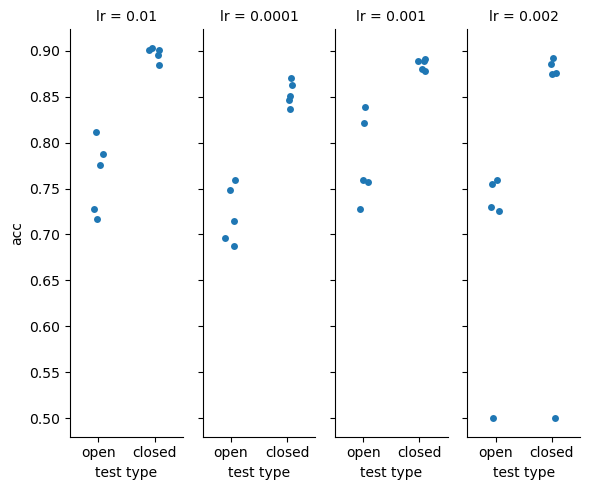

In [75]:
sns.catplot(performance_df, x ='test type', y ='acc', col='lr', aspect=0.3)

In [92]:
def train_model_swa(model, device, train_loader, val_loader, saving_folder, file_name, epochs=200, learning_rate = 0.002,\
                    momentum = 0, weight_decay = 0, patience = 10, min_delta = 0.005, swa_lr = 0.005, swa_start = 3):


    device = "mps" if torch.backends.mps.is_available() else "cpu"
    baseline_model = model.to(device)

    optimizer = torch.optim.Adam(
                baseline_model.parameters(), 
                lr=learning_rate,
                weight_decay=weight_decay,
                )
    loss_fn = nn.BCELoss()
    swa_model = torch.optim.swa_utils.AveragedModel(baseline_model)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
    swa_start = swa_start
    swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr = swa_lr)
    #epochs =40
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs), desc="Epochs"):
        #train
        running_loss_train= []
        for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            X = X.to(device)
            y = y.to(device)
            y_pred, logits = baseline_model(X, return_logits = True)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss_train.append(loss.cpu().detach().numpy())
        
        train_loss = np.mean(running_loss_train)
        train_losses.append(float(train_loss))
            
        if epoch > swa_start:
            swa_model.update_parameters(baseline_model)
            swa_scheduler.step()
            val_model = swa_model
        else:
            scheduler.step()
            val_model = baseline_model



        #validation
        running_loss = []
        with torch.no_grad():
            validation_loss = []
            for batch, (X,y) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
                X = X.to(device)
                y = y.to(device)
                y_pred = val_model(X)
                running_loss.append(loss_fn(y_pred, y).cpu().detach().numpy())
            val_loss = np.mean(running_loss) 
            val_losses.append(float(val_loss))
        print(f"Epoch: {epoch+1}/{epochs} - Train loss: {train_loss}, Validation loss: {val_loss}") #save to log-file
        if len(val_losses) >= patience:
            last_losses = val_losses[-patience:]
            max_loss = max(last_losses)
            min_loss = min(last_losses)
            if min_loss + min_delta >= max_loss:
                print("Early stopping") #save-to log file
                #save train_losses and val_losses to log file
                break
    torch.optim.swa_utils.update_bn(train_loader, swa_model)
    torch.save(swa_model.state_dict(), f'./torch_models/{saving_folder}/{file_name}_swa.pt')
    torch.save(swa_model.state_dict(), f'./torch_models/{saving_folder}/{file_name}_baseline.pt')
    with open(f'./logs/{file_name}_train_val_losses.json', 'w') as f:
        json.dump([train_losses, val_losses], f)



In [93]:
dataset = one_vs_all_paths[1]
file = dataset.split('/')[-1].strip('.tsv')
df = pd.read_csv(dataset, sep='\t')
train_one_all, val_one_all,  test_one_all = train_val_test_prep(df, scale = False)
train_loader = DataLoader(train_one_all, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_one_all, batch_size=batch_size, shuffle=True)

swa_starts = [3,7]
swa_lrs = [0.005, 0.002]
for swa_start in swa_starts:
    print(swa_start)
    for swa_lr in swa_lrs:
        print(swa_lr)
        for ag in ags:
            for i in range(1,6):
                model = SN_n(10) 
                train_model_swa(model, device, train_loader, val_loader, 'SN10_1_vs_all', file + f'_swa_lr{swa_lr}_swa_start{swa_start}_repl_{i}', swa_lr = swa_lr, swa_start = swa_start)


3
0.005


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5512604713439941, Validation loss: 0.4887351989746094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4635084271430969, Validation loss: 0.4510200321674347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4274181127548218, Validation loss: 0.4183526933193207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.39473703503608704, Validation loss: 0.3918636739253998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.364108681678772, Validation loss: 0.3678082227706909


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3359873294830322, Validation loss: 0.35406970977783203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.31182366609573364, Validation loss: 0.34307077527046204


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2901480197906494, Validation loss: 0.3341957926750183


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27340948581695557, Validation loss: 0.32437679171562195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2603156566619873, Validation loss: 0.3162296414375305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24994289875030518, Validation loss: 0.3097488284111023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24146351218223572, Validation loss: 0.30451545119285583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23327530920505524, Validation loss: 0.29824399948120117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22650542855262756, Validation loss: 0.29322806000709534


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22159430384635925, Validation loss: 0.2890612781047821


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.214222252368927, Validation loss: 0.28475499153137207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21194089949131012, Validation loss: 0.28171175718307495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.209025040268898, Validation loss: 0.27772095799446106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20292387902736664, Validation loss: 0.2758367657661438


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2005227655172348, Validation loss: 0.27363425493240356


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.198564812541008, Validation loss: 0.2715758979320526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19514282047748566, Validation loss: 0.27014750242233276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19195054471492767, Validation loss: 0.2680467963218689


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19065548479557037, Validation loss: 0.26605600118637085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18853162229061127, Validation loss: 0.26500388979911804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1868954747915268, Validation loss: 0.2633611261844635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18411628901958466, Validation loss: 0.2628301978111267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18273784220218658, Validation loss: 0.26233282685279846


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18197593092918396, Validation loss: 0.26105257868766785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1811360865831375, Validation loss: 0.26176178455352783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18029949069023132, Validation loss: 0.26046180725097656


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1780737042427063, Validation loss: 0.25991949439048767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17997050285339355, Validation loss: 0.2582250237464905


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17702625691890717, Validation loss: 0.25800472497940063


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.17524246871471405, Validation loss: 0.2579352557659149


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.17569591104984283, Validation loss: 0.2579822242259979
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5427672863006592, Validation loss: 0.47654375433921814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4483901262283325, Validation loss: 0.43342339992523193


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4072067439556122, Validation loss: 0.40103453397750854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37326109409332275, Validation loss: 0.3698318898677826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.34249040484428406, Validation loss: 0.34510302543640137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3155454099178314, Validation loss: 0.33406367897987366


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.29300457239151, Validation loss: 0.3250630795955658


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.27396494150161743, Validation loss: 0.31512928009033203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.25772300362586975, Validation loss: 0.3074618875980377


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2450392246246338, Validation loss: 0.2996886074542999


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.233255535364151, Validation loss: 0.2914833128452301


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.22264772653579712, Validation loss: 0.2851480543613434


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.21621829271316528, Validation loss: 0.28021374344825745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.20936816930770874, Validation loss: 0.27496153116226196


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.20368899405002594, Validation loss: 0.27076247334480286


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.1992088109254837, Validation loss: 0.26629096269607544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.1943361610174179, Validation loss: 0.2628884017467499


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1910356730222702, Validation loss: 0.25943270325660706


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.187303826212883, Validation loss: 0.25681591033935547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1858338862657547, Validation loss: 0.25421270728111267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1827125996351242, Validation loss: 0.25235334038734436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18072570860385895, Validation loss: 0.2512689232826233


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1776679903268814, Validation loss: 0.24981719255447388


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.17843005061149597, Validation loss: 0.2474968135356903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17606095969676971, Validation loss: 0.2463759034872055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17361848056316376, Validation loss: 0.24589680135250092


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17420710623264313, Validation loss: 0.24448543787002563


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17166531085968018, Validation loss: 0.2433967888355255


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17117854952812195, Validation loss: 0.24331465363502502


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.16905540227890015, Validation loss: 0.24168796837329865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1690281480550766, Validation loss: 0.24070170521736145


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16721183061599731, Validation loss: 0.24071748554706573


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16695581376552582, Validation loss: 0.23938527703285217


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16569320857524872, Validation loss: 0.23907119035720825


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16453321278095245, Validation loss: 0.23826530575752258


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1641617715358734, Validation loss: 0.23801638185977936


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16323541104793549, Validation loss: 0.23828305304050446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.16321584582328796, Validation loss: 0.23815298080444336


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16205157339572906, Validation loss: 0.2377261072397232
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5379452705383301, Validation loss: 0.4708176851272583


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.43887460231781006, Validation loss: 0.42243266105651855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.39460137486457825, Validation loss: 0.3865427076816559


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3594980835914612, Validation loss: 0.3621118366718292


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.33009156584739685, Validation loss: 0.33446186780929565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.30463308095932007, Validation loss: 0.32394498586654663


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2822297215461731, Validation loss: 0.31359443068504333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.26200050115585327, Validation loss: 0.3041536509990692


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.24577006697654724, Validation loss: 0.29500582814216614


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.23362182080745697, Validation loss: 0.28598347306251526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2236168384552002, Validation loss: 0.27843600511550903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.21653087437152863, Validation loss: 0.272410124540329


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2094736248254776, Validation loss: 0.26739203929901123


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2029070109128952, Validation loss: 0.2623519003391266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.19990307092666626, Validation loss: 0.25852692127227783


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.19648298621177673, Validation loss: 0.2556985914707184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.19057658314704895, Validation loss: 0.2521226704120636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.1869909018278122, Validation loss: 0.24876423180103302


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.1857386976480484, Validation loss: 0.24780212342739105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1835474967956543, Validation loss: 0.2448384314775467


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.18125002086162567, Validation loss: 0.2439146190881729


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1792413294315338, Validation loss: 0.24219296872615814


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.17661091685295105, Validation loss: 0.2415996789932251


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.17447195947170258, Validation loss: 0.2402672916650772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17366254329681396, Validation loss: 0.24004526436328888


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17233838140964508, Validation loss: 0.23889723420143127


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17129094898700714, Validation loss: 0.23789682984352112


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1688125878572464, Validation loss: 0.2383708357810974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.16782106459140778, Validation loss: 0.23768363893032074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.16631242632865906, Validation loss: 0.2376086413860321


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.16685663163661957, Validation loss: 0.2376278042793274
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5497087240219116, Validation loss: 0.4951307773590088


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4679076075553894, Validation loss: 0.45565345883369446


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.43135130405426025, Validation loss: 0.4257466793060303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.39486929774284363, Validation loss: 0.39380621910095215


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3612557351589203, Validation loss: 0.36516237258911133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.33020710945129395, Validation loss: 0.35232025384902954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30596742033958435, Validation loss: 0.34228819608688354


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2858384847640991, Validation loss: 0.33122968673706055


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2702047824859619, Validation loss: 0.32297247648239136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25570404529571533, Validation loss: 0.31354716420173645


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2439463883638382, Validation loss: 0.306688129901886


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23425959050655365, Validation loss: 0.2999420762062073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22605280578136444, Validation loss: 0.29381152987480164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21839937567710876, Validation loss: 0.28909289836883545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21153970062732697, Validation loss: 0.28393229842185974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2039927840232849, Validation loss: 0.28016629815101624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.19898545742034912, Validation loss: 0.27591025829315186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.19341899454593658, Validation loss: 0.2723231017589569


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.18994027376174927, Validation loss: 0.2698984146118164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.18661773204803467, Validation loss: 0.267699658870697


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1842656433582306, Validation loss: 0.26476603746414185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18144670128822327, Validation loss: 0.26254138350486755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1795748621225357, Validation loss: 0.2608836591243744


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.17779479920864105, Validation loss: 0.2582685053348541


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17569802701473236, Validation loss: 0.25611525774002075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17390823364257812, Validation loss: 0.2555449903011322


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1716267466545105, Validation loss: 0.2545183002948761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17228318750858307, Validation loss: 0.25454187393188477


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.170552060008049, Validation loss: 0.25205013155937195


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.16989058256149292, Validation loss: 0.25167116522789


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.167291060090065, Validation loss: 0.25058814883232117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16731780767440796, Validation loss: 0.2506410777568817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16720253229141235, Validation loss: 0.24991483986377716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16560818254947662, Validation loss: 0.24892257153987885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16423526406288147, Validation loss: 0.2486134171485901


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16482052206993103, Validation loss: 0.24851585924625397


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16290366649627686, Validation loss: 0.248371422290802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.16285419464111328, Validation loss: 0.24835282564163208
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5396588444709778, Validation loss: 0.4823879897594452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45515552163124084, Validation loss: 0.4491874873638153


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4204173684120178, Validation loss: 0.4168589115142822


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38790327310562134, Validation loss: 0.38701698184013367


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3558347523212433, Validation loss: 0.3622134029865265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32818669080734253, Validation loss: 0.34903284907341003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30378472805023193, Validation loss: 0.33761119842529297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2819119393825531, Validation loss: 0.3257455825805664


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2641680836677551, Validation loss: 0.3157329559326172


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24978676438331604, Validation loss: 0.3062942922115326


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23879563808441162, Validation loss: 0.2982569932937622


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23065774142742157, Validation loss: 0.2915310859680176


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22351433336734772, Validation loss: 0.285847008228302


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21835872530937195, Validation loss: 0.28047752380371094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21333783864974976, Validation loss: 0.2747385799884796


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.20801743865013123, Validation loss: 0.27192968130111694


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20483219623565674, Validation loss: 0.2685103416442871


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20287960767745972, Validation loss: 0.2643936276435852


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20005735754966736, Validation loss: 0.2624710202217102


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19724546372890472, Validation loss: 0.26053956151008606


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1967138648033142, Validation loss: 0.25825709104537964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1948697417974472, Validation loss: 0.2573012113571167


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19192498922348022, Validation loss: 0.25534313917160034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19126109778881073, Validation loss: 0.2537805438041687


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.1922372430562973, Validation loss: 0.25329625606536865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18964602053165436, Validation loss: 0.25156453251838684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18764083087444305, Validation loss: 0.25110435485839844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1875281035900116, Validation loss: 0.2500760853290558


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18601152300834656, Validation loss: 0.24950237572193146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18484222888946533, Validation loss: 0.2495097815990448


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18392635881900787, Validation loss: 0.24859380722045898


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1829673945903778, Validation loss: 0.2487325221300125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18277119100093842, Validation loss: 0.24836242198944092


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18061883747577667, Validation loss: 0.24753302335739136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.18139876425266266, Validation loss: 0.24713850021362305
Early stopping
0.002


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5438719391822815, Validation loss: 0.47677943110466003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4419673979282379, Validation loss: 0.4313673675060272


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40180104970932007, Validation loss: 0.4014979302883148


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.36868035793304443, Validation loss: 0.37149184942245483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.33735379576683044, Validation loss: 0.34514284133911133


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3103483021259308, Validation loss: 0.33202436566352844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.28771573305130005, Validation loss: 0.32247868180274963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.26973026990890503, Validation loss: 0.3132847845554352


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.25537803769111633, Validation loss: 0.30547377467155457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24329064786434174, Validation loss: 0.2992338240146637


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23416054248809814, Validation loss: 0.29328280687332153


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.22706064581871033, Validation loss: 0.2874530553817749


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.220865860581398, Validation loss: 0.2835388481616974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21534107625484467, Validation loss: 0.2790457308292389


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21051447093486786, Validation loss: 0.27764901518821716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2065260112285614, Validation loss: 0.2728545367717743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20321877300739288, Validation loss: 0.27004000544548035


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.19963175058364868, Validation loss: 0.26719287037849426


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.1962968409061432, Validation loss: 0.26489385962486267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1936349868774414, Validation loss: 0.26338139176368713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19113211333751678, Validation loss: 0.26042911410331726


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18811772763729095, Validation loss: 0.2581242322921753


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18614406883716583, Validation loss: 0.2566637396812439


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1842375099658966, Validation loss: 0.255016952753067


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18268385529518127, Validation loss: 0.2533535063266754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18069474399089813, Validation loss: 0.2533350884914398


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1786975860595703, Validation loss: 0.2522291839122772


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17733748257160187, Validation loss: 0.25007006525993347


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17585667967796326, Validation loss: 0.24825353920459747


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17456252872943878, Validation loss: 0.24740830063819885


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17275476455688477, Validation loss: 0.24752306938171387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17240270972251892, Validation loss: 0.2457628697156906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17089048027992249, Validation loss: 0.24496863782405853


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16990245878696442, Validation loss: 0.24453207850456238


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16792507469654083, Validation loss: 0.2435111701488495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16742457449436188, Validation loss: 0.24310874938964844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1668294221162796, Validation loss: 0.24179165065288544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.16483689844608307, Validation loss: 0.24152658879756927


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16429387032985687, Validation loss: 0.24056851863861084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.16421598196029663, Validation loss: 0.2407190054655075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.16244898736476898, Validation loss: 0.24055394530296326


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.16166876256465912, Validation loss: 0.23953373730182648


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.16093052923679352, Validation loss: 0.23997513949871063
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5487635731697083, Validation loss: 0.48269200325012207


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4491710960865021, Validation loss: 0.4351580739021301


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.406699538230896, Validation loss: 0.4059521555900574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37604978680610657, Validation loss: 0.3837425112724304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.34902605414390564, Validation loss: 0.3624427318572998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3273496925830841, Validation loss: 0.3513546884059906


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3073866367340088, Validation loss: 0.34188857674598694


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.29039058089256287, Validation loss: 0.3351866602897644


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27562472224235535, Validation loss: 0.32777848839759827


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2637999653816223, Validation loss: 0.3207821846008301


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25233158469200134, Validation loss: 0.3154838979244232


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24404047429561615, Validation loss: 0.3094480037689209


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2352677434682846, Validation loss: 0.3041156530380249


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22853577136993408, Validation loss: 0.3008366525173187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22257287800312042, Validation loss: 0.29677367210388184


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21859267354011536, Validation loss: 0.2930157482624054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21427221596240997, Validation loss: 0.2904234528541565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20960751175880432, Validation loss: 0.28778311610221863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20567721128463745, Validation loss: 0.28480422496795654


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20301124453544617, Validation loss: 0.2825101315975189


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19975173473358154, Validation loss: 0.2795434892177582


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19604530930519104, Validation loss: 0.2774637043476105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.194497212767601, Validation loss: 0.2758619487285614


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19166232645511627, Validation loss: 0.27370908856391907


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18971113860607147, Validation loss: 0.27125999331474304


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18822437524795532, Validation loss: 0.2707357704639435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1861610859632492, Validation loss: 0.26918190717697144


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1844518780708313, Validation loss: 0.2676762342453003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18195407092571259, Validation loss: 0.2663942277431488


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18089568614959717, Validation loss: 0.26517733931541443


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17927980422973633, Validation loss: 0.2645840644836426


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.178044855594635, Validation loss: 0.2632412016391754


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1761827915906906, Validation loss: 0.2621634900569916


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17546521127223969, Validation loss: 0.2608802616596222


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.17435488104820251, Validation loss: 0.259957492351532


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.17299020290374756, Validation loss: 0.25892484188079834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.17151017487049103, Validation loss: 0.2577776610851288


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.17064808309078217, Validation loss: 0.2579871118068695


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.17011281847953796, Validation loss: 0.25694864988327026


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.16944552958011627, Validation loss: 0.256453275680542


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.16827619075775146, Validation loss: 0.2552732825279236


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.1669953316450119, Validation loss: 0.2557176351547241


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.1655408889055252, Validation loss: 0.2546340525150299


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.16502170264720917, Validation loss: 0.25432291626930237


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.16491813957691193, Validation loss: 0.2528481185436249


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.16289326548576355, Validation loss: 0.25185203552246094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.1626608669757843, Validation loss: 0.2514544427394867


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.16212956607341766, Validation loss: 0.2522347867488861


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 49/200 - Train loss: 0.16222268342971802, Validation loss: 0.25177186727523804
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5492079257965088, Validation loss: 0.48607298731803894


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4561576247215271, Validation loss: 0.44707804918289185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.42429107427597046, Validation loss: 0.42395418882369995


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3951852321624756, Validation loss: 0.3982072174549103


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.36447271704673767, Validation loss: 0.3696095049381256


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.33365508913993835, Validation loss: 0.3547912538051605


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3085119426250458, Validation loss: 0.34308385848999023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2883121073246002, Validation loss: 0.33284276723861694


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2729664146900177, Validation loss: 0.3241502642631531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.26061686873435974, Validation loss: 0.31604477763175964


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.250325471162796, Validation loss: 0.3099673092365265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24188245832920074, Validation loss: 0.3047882616519928


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23434464633464813, Validation loss: 0.2996312379837036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22877392172813416, Validation loss: 0.2960219085216522


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22343984246253967, Validation loss: 0.2925225794315338


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21878784894943237, Validation loss: 0.28899019956588745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21449598670005798, Validation loss: 0.28624165058135986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21052473783493042, Validation loss: 0.28295013308525085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.208563432097435, Validation loss: 0.2803831994533539


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20464877784252167, Validation loss: 0.2777247726917267


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20218046009540558, Validation loss: 0.27609702944755554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19981597363948822, Validation loss: 0.27411624789237976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19749556481838226, Validation loss: 0.27240264415740967


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19564677774906158, Validation loss: 0.2704148292541504


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19343894720077515, Validation loss: 0.26800528168678284


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.19173261523246765, Validation loss: 0.26740482449531555


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18996059894561768, Validation loss: 0.26508960127830505


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1882980614900589, Validation loss: 0.26400116086006165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18719451129436493, Validation loss: 0.26435351371765137


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18632666766643524, Validation loss: 0.26194581389427185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18471355736255646, Validation loss: 0.26087868213653564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1836736798286438, Validation loss: 0.26021063327789307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18283452093601227, Validation loss: 0.2588469684123993


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18165777623653412, Validation loss: 0.2581150233745575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1803782731294632, Validation loss: 0.25689125061035156


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.18021820485591888, Validation loss: 0.25662481784820557


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.17847634851932526, Validation loss: 0.25542736053466797


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.17845050990581512, Validation loss: 0.25545743107795715


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.17721925675868988, Validation loss: 0.2541978359222412


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.17578177154064178, Validation loss: 0.25342026352882385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.1758488118648529, Validation loss: 0.2537382245063782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.17460285127162933, Validation loss: 0.2523784637451172


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 43/200 - Train loss: 0.17397086322307587, Validation loss: 0.25170838832855225


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 44/200 - Train loss: 0.17336401343345642, Validation loss: 0.2518509030342102


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 45/200 - Train loss: 0.17149323225021362, Validation loss: 0.25072407722473145


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 46/200 - Train loss: 0.1720517873764038, Validation loss: 0.25005200505256653


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 47/200 - Train loss: 0.17094750702381134, Validation loss: 0.25009363889694214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 48/200 - Train loss: 0.17084896564483643, Validation loss: 0.24951401352882385
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5465006828308105, Validation loss: 0.4859880208969116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.46027126908302307, Validation loss: 0.4498024880886078


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.42343685030937195, Validation loss: 0.41523948311805725


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.387958288192749, Validation loss: 0.38346439599990845


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.35641035437583923, Validation loss: 0.3600725829601288


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.33027875423431396, Validation loss: 0.348603218793869


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30727577209472656, Validation loss: 0.33689218759536743


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28716108202934265, Validation loss: 0.32751038670539856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2705228924751282, Validation loss: 0.3192608654499054


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2561754882335663, Validation loss: 0.3113939166069031


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2448999583721161, Validation loss: 0.3048563003540039


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.2356870025396347, Validation loss: 0.29922056198120117


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22729843854904175, Validation loss: 0.2936474680900574


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22098280489444733, Validation loss: 0.2883045971393585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21520651876926422, Validation loss: 0.2847181558609009


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2101246416568756, Validation loss: 0.28054916858673096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2059638351202011, Validation loss: 0.277249813079834


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20178815722465515, Validation loss: 0.274676650762558


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19848687946796417, Validation loss: 0.2718539535999298


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1953548789024353, Validation loss: 0.26890718936920166


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19265952706336975, Validation loss: 0.2669801414012909


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18952752649784088, Validation loss: 0.2655565142631531


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18714013695716858, Validation loss: 0.26313602924346924


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1857137531042099, Validation loss: 0.2613705098628998


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18285901844501495, Validation loss: 0.25983789563179016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18092751502990723, Validation loss: 0.2595168352127075


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1794828325510025, Validation loss: 0.25814053416252136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17800065875053406, Validation loss: 0.25681206583976746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1765819638967514, Validation loss: 0.25541070103645325


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17507022619247437, Validation loss: 0.25444096326828003


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1742676943540573, Validation loss: 0.2538280189037323


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17286284267902374, Validation loss: 0.25340279936790466


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.17211833596229553, Validation loss: 0.25255879759788513


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.1707794964313507, Validation loss: 0.2522818446159363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.17018935084342957, Validation loss: 0.2519792318344116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1687956303358078, Validation loss: 0.2511959969997406


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16805827617645264, Validation loss: 0.250444233417511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1669887751340866, Validation loss: 0.24958878755569458


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.1668468713760376, Validation loss: 0.2489931434392929


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.16606751084327698, Validation loss: 0.2501211166381836
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5426377654075623, Validation loss: 0.4782075881958008


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.44636672735214233, Validation loss: 0.43047237396240234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40597790479660034, Validation loss: 0.4007203280925751


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3731115758419037, Validation loss: 0.3735436797142029


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3427427113056183, Validation loss: 0.34792977571487427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3141852915287018, Validation loss: 0.33340632915496826


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2921570837497711, Validation loss: 0.3232710659503937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.27439990639686584, Validation loss: 0.31470727920532227


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2606683671474457, Validation loss: 0.3071720600128174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2500384449958801, Validation loss: 0.3018698990345001


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2409004420042038, Validation loss: 0.2961770296096802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23285022377967834, Validation loss: 0.29145410656929016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.22683221101760864, Validation loss: 0.28741589188575745


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22082580626010895, Validation loss: 0.2832901179790497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21721862256526947, Validation loss: 0.2800215482711792


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21275009214878082, Validation loss: 0.27696549892425537


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2083282470703125, Validation loss: 0.27426475286483765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20484305918216705, Validation loss: 0.27254974842071533


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20237040519714355, Validation loss: 0.2699428200721741


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.200231671333313, Validation loss: 0.267515629529953


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19666767120361328, Validation loss: 0.266236811876297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19506844878196716, Validation loss: 0.26435941457748413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19318844377994537, Validation loss: 0.26305410265922546


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1910981386899948, Validation loss: 0.261936753988266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18991412222385406, Validation loss: 0.2603370249271393


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1887732446193695, Validation loss: 0.25871023535728455


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18693535029888153, Validation loss: 0.258149653673172


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18569500744342804, Validation loss: 0.25728875398635864


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1857968121767044, Validation loss: 0.25621357560157776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1836947500705719, Validation loss: 0.2545859217643738


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18249277770519257, Validation loss: 0.25433188676834106


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.18168629705905914, Validation loss: 0.25370872020721436


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18159456551074982, Validation loss: 0.2538295090198517


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18020589649677277, Validation loss: 0.25305888056755066


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.17955832183361053, Validation loss: 0.25248953700065613


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.17934848368167877, Validation loss: 0.2513379156589508


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.17777974903583527, Validation loss: 0.25071826577186584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.17756183445453644, Validation loss: 0.2505357563495636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.17722088098526, Validation loss: 0.24983558058738708
Early stopping
7
0.005


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5413312315940857, Validation loss: 0.4726638197898865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4441101551055908, Validation loss: 0.43572285771369934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41159161925315857, Validation loss: 0.40929993987083435


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.38171571493148804, Validation loss: 0.3821733295917511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3539305031299591, Validation loss: 0.3589532673358917


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3272605538368225, Validation loss: 0.33910104632377625


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3048962354660034, Validation loss: 0.32020437717437744


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2861397862434387, Validation loss: 0.309330552816391


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2721485495567322, Validation loss: 0.2989238202571869


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.26114290952682495, Validation loss: 0.29458463191986084


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25136980414390564, Validation loss: 0.2897653579711914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24305380880832672, Validation loss: 0.2858084738254547


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23532696068286896, Validation loss: 0.2815743386745453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22780242562294006, Validation loss: 0.2784026563167572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22084824740886688, Validation loss: 0.2747356593608856


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21434597671031952, Validation loss: 0.2716751992702484


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20913204550743103, Validation loss: 0.2679891884326935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20526379346847534, Validation loss: 0.2662336230278015


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.1988050937652588, Validation loss: 0.2636905014514923


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.1952817291021347, Validation loss: 0.2616860866546631


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19159531593322754, Validation loss: 0.25926533341407776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.1877431720495224, Validation loss: 0.25822582840919495


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18385618925094604, Validation loss: 0.2563803493976593


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1824972778558731, Validation loss: 0.25495752692222595


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17888687551021576, Validation loss: 0.25517329573631287


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17749950289726257, Validation loss: 0.25265827775001526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1755352020263672, Validation loss: 0.2525460124015808


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1746368408203125, Validation loss: 0.2512567639350891


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17172837257385254, Validation loss: 0.25078877806663513


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17066192626953125, Validation loss: 0.24958696961402893


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17012456059455872, Validation loss: 0.24882759153842926


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16847360134124756, Validation loss: 0.24792253971099854


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16648675501346588, Validation loss: 0.24876125156879425


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16484655439853668, Validation loss: 0.24676892161369324


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16512063145637512, Validation loss: 0.24694547057151794


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16396446526050568, Validation loss: 0.24608832597732544


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16263200342655182, Validation loss: 0.24572795629501343


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1616193950176239, Validation loss: 0.24547922611236572


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16141940653324127, Validation loss: 0.2450225055217743
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5388233661651611, Validation loss: 0.47618672251701355


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.44452333450317383, Validation loss: 0.4331788420677185


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40365299582481384, Validation loss: 0.3978762626647949


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3673331141471863, Validation loss: 0.37032315135002136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3363760709762573, Validation loss: 0.347910076379776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3116481304168701, Validation loss: 0.3288103938102722


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2918680012226105, Validation loss: 0.3143475353717804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2762814462184906, Validation loss: 0.3032992482185364


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2621736526489258, Validation loss: 0.293775349855423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2518787384033203, Validation loss: 0.28952884674072266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24342532455921173, Validation loss: 0.2859184741973877


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23574884235858917, Validation loss: 0.2820371985435486


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.229791522026062, Validation loss: 0.27978911995887756


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.2245139628648758, Validation loss: 0.27657705545425415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.219513401389122, Validation loss: 0.2733970880508423


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21552534401416779, Validation loss: 0.27166223526000977


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2106197327375412, Validation loss: 0.2690296173095703


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20719558000564575, Validation loss: 0.26758307218551636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2023681402206421, Validation loss: 0.26441553235054016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19645580649375916, Validation loss: 0.26330578327178955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1942075937986374, Validation loss: 0.26120951771736145


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19114357233047485, Validation loss: 0.2597910463809967


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18907445669174194, Validation loss: 0.2592357099056244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18705211579799652, Validation loss: 0.2581983208656311


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18617992103099823, Validation loss: 0.2569900453090668


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18445514142513275, Validation loss: 0.2569114863872528


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18251590430736542, Validation loss: 0.25505825877189636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18004775047302246, Validation loss: 0.25459346175193787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17860811948776245, Validation loss: 0.25369521975517273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17820148169994354, Validation loss: 0.25274327397346497


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.17760442197322845, Validation loss: 0.25283756852149963


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17632095515727997, Validation loss: 0.2522059977054596


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1734454333782196, Validation loss: 0.2516293525695801


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17282597720623016, Validation loss: 0.2522028386592865


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.17233985662460327, Validation loss: 0.2501288652420044


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.171841099858284, Validation loss: 0.2495998740196228


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.17087580263614655, Validation loss: 0.24999120831489563
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.54995197057724, Validation loss: 0.48310187458992004


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4497787654399872, Validation loss: 0.4378880262374878


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.40647920966148376, Validation loss: 0.4008614718914032


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3664964735507965, Validation loss: 0.36521121859550476


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3291488289833069, Validation loss: 0.3379015624523163


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.30076104402542114, Validation loss: 0.31423014402389526


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2805534303188324, Validation loss: 0.3000619411468506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2657952606678009, Validation loss: 0.2900373041629791


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2543587386608124, Validation loss: 0.28093212842941284


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.24514992535114288, Validation loss: 0.2770979106426239


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.23717035353183746, Validation loss: 0.2739577889442444


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23056362569332123, Validation loss: 0.27045193314552307


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2238791584968567, Validation loss: 0.26707959175109863


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.219254732131958, Validation loss: 0.26472240686416626


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21339870989322662, Validation loss: 0.2609458565711975


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.208762064576149, Validation loss: 0.2590809762477875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20544128119945526, Validation loss: 0.2544538676738739


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20085018873214722, Validation loss: 0.25245627760887146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19669824838638306, Validation loss: 0.249919593334198


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19221080839633942, Validation loss: 0.24806763231754303


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.18828259408473969, Validation loss: 0.24523964524269104


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18625585734844208, Validation loss: 0.2431461215019226


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18346072733402252, Validation loss: 0.24277658760547638


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18048961460590363, Validation loss: 0.24005459249019623


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.17908287048339844, Validation loss: 0.23805201053619385


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17549251019954681, Validation loss: 0.23733766376972198


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17394323647022247, Validation loss: 0.2352420687675476


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.17247775197029114, Validation loss: 0.23465880751609802


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17135192453861237, Validation loss: 0.2346433848142624


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.16890233755111694, Validation loss: 0.2324778288602829


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.16974174976348877, Validation loss: 0.23222613334655762


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1669468730688095, Validation loss: 0.23158326745033264


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16609488427639008, Validation loss: 0.2303132265806198


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.16433416306972504, Validation loss: 0.2298266589641571


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16328224539756775, Validation loss: 0.22893773019313812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16178739070892334, Validation loss: 0.2280638962984085


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.1626434028148651, Validation loss: 0.22771349549293518


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.16068030893802643, Validation loss: 0.22738496959209442


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.15861715376377106, Validation loss: 0.2265225648880005


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.1593703031539917, Validation loss: 0.2271786332130432


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.15915612876415253, Validation loss: 0.22625413537025452


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.1582353115081787, Validation loss: 0.22616997361183167
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5527979731559753, Validation loss: 0.4948570132255554


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4702461361885071, Validation loss: 0.45867303013801575


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4354781210422516, Validation loss: 0.42645201086997986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.39866968989372253, Validation loss: 0.3926803171634674


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3648412525653839, Validation loss: 0.36487436294555664


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3337883949279785, Validation loss: 0.3392939865589142


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.30876991152763367, Validation loss: 0.31935209035873413


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2885465919971466, Validation loss: 0.3040471076965332


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2740877568721771, Validation loss: 0.29277583956718445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2627030909061432, Validation loss: 0.28770217299461365


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25391533970832825, Validation loss: 0.28368985652923584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24531280994415283, Validation loss: 0.2807852029800415


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2400195300579071, Validation loss: 0.2780378460884094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23458746075630188, Validation loss: 0.2753843665122986


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.23060376942157745, Validation loss: 0.27308741211891174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2251952439546585, Validation loss: 0.2706679403781891


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21958671510219574, Validation loss: 0.26918914914131165


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.21711160242557526, Validation loss: 0.26699233055114746


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.210722878575325, Validation loss: 0.2644523084163666


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20725734531879425, Validation loss: 0.26312893629074097


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20513422787189484, Validation loss: 0.26143649220466614


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.2018388956785202, Validation loss: 0.26051604747772217


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1988646239042282, Validation loss: 0.2597768008708954


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19692277908325195, Validation loss: 0.2597208023071289


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.1950647234916687, Validation loss: 0.25881674885749817


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.1931740939617157, Validation loss: 0.2573341727256775


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1944507658481598, Validation loss: 0.25677481293678284


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1908152997493744, Validation loss: 0.2570723593235016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18860548734664917, Validation loss: 0.25606608390808105


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1887282282114029, Validation loss: 0.2562105059623718


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18762759864330292, Validation loss: 0.25572818517684937
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5471088886260986, Validation loss: 0.48035308718681335


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4543374180793762, Validation loss: 0.4443575441837311


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4211636185646057, Validation loss: 0.41885316371917725


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3919975757598877, Validation loss: 0.3938637971878052


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.362326055765152, Validation loss: 0.36678990721702576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3346943259239197, Validation loss: 0.34377050399780273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.31033575534820557, Validation loss: 0.32603222131729126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2896781265735626, Validation loss: 0.31029415130615234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27416104078292847, Validation loss: 0.2980162799358368


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.26199352741241455, Validation loss: 0.29247644543647766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.25085026025772095, Validation loss: 0.28725215792655945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24130377173423767, Validation loss: 0.28356319665908813


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23329661786556244, Validation loss: 0.27991044521331787


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22568325698375702, Validation loss: 0.27406904101371765


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.2186957150697708, Validation loss: 0.27005863189697266


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2128347009420395, Validation loss: 0.2667711079120636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.2079029381275177, Validation loss: 0.2634296417236328


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20297950506210327, Validation loss: 0.2611345648765564


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19844888150691986, Validation loss: 0.2577708661556244


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19438530504703522, Validation loss: 0.25565454363822937


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1912289708852768, Validation loss: 0.25407201051712036


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.18727988004684448, Validation loss: 0.2509397566318512


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18421140313148499, Validation loss: 0.2501669228076935


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18297183513641357, Validation loss: 0.24808137118816376


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18082192540168762, Validation loss: 0.2465405911207199


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.17872780561447144, Validation loss: 0.24579744040966034


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17736448347568512, Validation loss: 0.24361351132392883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1747719645500183, Validation loss: 0.24229149520397186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1727728247642517, Validation loss: 0.24206338822841644


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.17290985584259033, Validation loss: 0.24170759320259094


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1703128069639206, Validation loss: 0.24083231389522552


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1681872010231018, Validation loss: 0.2400633543729782


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.16707536578178406, Validation loss: 0.2394467443227768


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.1679861843585968, Validation loss: 0.2393125742673874


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16626428067684174, Validation loss: 0.2383279651403427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1651286780834198, Validation loss: 0.23756209015846252


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.164204403758049, Validation loss: 0.23761509358882904
Early stopping
0.002


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5508461594581604, Validation loss: 0.4866935610771179


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.46111518144607544, Validation loss: 0.44846978783607483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4265126585960388, Validation loss: 0.41886839270591736


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.39409610629081726, Validation loss: 0.3907584249973297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3636794686317444, Validation loss: 0.36759495735168457


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3352566361427307, Validation loss: 0.3434194028377533


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3124538064002991, Validation loss: 0.32505714893341064


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2939065992832184, Validation loss: 0.31221485137939453


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27875760197639465, Validation loss: 0.30135515332221985


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.26708558201789856, Validation loss: 0.29685071110725403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2569461762905121, Validation loss: 0.2932282090187073


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24806801974773407, Validation loss: 0.2909166216850281


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.24064408242702484, Validation loss: 0.2872050702571869


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23480656743049622, Validation loss: 0.28385886549949646


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.228430837392807, Validation loss: 0.28170305490493774


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2230367213487625, Validation loss: 0.2799299955368042


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21823525428771973, Validation loss: 0.27886340022087097


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2134799212217331, Validation loss: 0.2759867310523987


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.2095990628004074, Validation loss: 0.2748663127422333


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.20626868307590485, Validation loss: 0.27205654978752136


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20259778201580048, Validation loss: 0.2712605595588684


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19973261654376984, Validation loss: 0.2705039381980896


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.19630372524261475, Validation loss: 0.26839905977249146


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.1946762651205063, Validation loss: 0.2675818204879761


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19146709144115448, Validation loss: 0.2667756974697113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18940487504005432, Validation loss: 0.26427289843559265


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18757466971874237, Validation loss: 0.26420870423316956


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18588021397590637, Validation loss: 0.26401159167289734


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1839880645275116, Validation loss: 0.26203516125679016


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18198424577713013, Validation loss: 0.26154834032058716


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.18054728209972382, Validation loss: 0.2613512873649597


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.17940430343151093, Validation loss: 0.2597000002861023


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1789799928665161, Validation loss: 0.25918686389923096


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.17665305733680725, Validation loss: 0.25911349058151245


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.1758415400981903, Validation loss: 0.2583547830581665


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.17436204850673676, Validation loss: 0.25808772444725037


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.175111323595047, Validation loss: 0.25728169083595276


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.17313243448734283, Validation loss: 0.2571565508842468
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5429414510726929, Validation loss: 0.47882023453712463


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4534561336040497, Validation loss: 0.4425053894519806


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41963306069374084, Validation loss: 0.4154985249042511


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3873695731163025, Validation loss: 0.3861662745475769


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3553037941455841, Validation loss: 0.3594481647014618


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3248522877693176, Validation loss: 0.33439013361930847


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.2985880970954895, Validation loss: 0.31436145305633545


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.2778346538543701, Validation loss: 0.29811331629753113


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26193875074386597, Validation loss: 0.2861296832561493


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.2492840588092804, Validation loss: 0.28136736154556274


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2395877093076706, Validation loss: 0.27639901638031006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.23223140835762024, Validation loss: 0.2721632122993469


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.2248881608247757, Validation loss: 0.2699354887008667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.21889883279800415, Validation loss: 0.2666689455509186


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.21372714638710022, Validation loss: 0.26492756605148315


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.20932219922542572, Validation loss: 0.2627752423286438


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.20627088844776154, Validation loss: 0.26058122515678406


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20273524522781372, Validation loss: 0.25922203063964844


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.19955052435398102, Validation loss: 0.2568715214729309


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19636957347393036, Validation loss: 0.25605106353759766


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.193430557847023, Validation loss: 0.2549450099468231


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19214452803134918, Validation loss: 0.2540946304798126


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1896096169948578, Validation loss: 0.2542971968650818


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18745164573192596, Validation loss: 0.251751184463501


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18617130815982819, Validation loss: 0.2514802813529968


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18466109037399292, Validation loss: 0.2508470416069031


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1839621663093567, Validation loss: 0.2503347396850586


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.18186677992343903, Validation loss: 0.2503173351287842


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.181818887591362, Validation loss: 0.24938592314720154


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1797627955675125, Validation loss: 0.24929361045360565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.178826704621315, Validation loss: 0.24788707494735718


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.1774960160255432, Validation loss: 0.24845466017723083


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1763521432876587, Validation loss: 0.2479887157678604
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5413975119590759, Validation loss: 0.4781782627105713


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.4491029381752014, Validation loss: 0.44150155782699585


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.41222548484802246, Validation loss: 0.40823718905448914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37936756014823914, Validation loss: 0.38358619809150696


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.35043570399284363, Validation loss: 0.3585343062877655


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.32562151551246643, Validation loss: 0.3365249037742615


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3047427237033844, Validation loss: 0.3222675621509552


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.28873637318611145, Validation loss: 0.3129163086414337


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.27600663900375366, Validation loss: 0.30391550064086914


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.26491162180900574, Validation loss: 0.2992435395717621


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.2565959095954895, Validation loss: 0.29576221108436584


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24844881892204285, Validation loss: 0.2937448024749756


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.24232366681098938, Validation loss: 0.29015475511550903


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.23643416166305542, Validation loss: 0.2879437506198883


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.23094482719898224, Validation loss: 0.28460243344306946


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.22644835710525513, Validation loss: 0.281912624835968


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.22211746871471405, Validation loss: 0.2801222801208496


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.2185935080051422, Validation loss: 0.27795711159706116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.21484574675559998, Validation loss: 0.27618592977523804


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.21101781725883484, Validation loss: 0.2751995921134949


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.20840176939964294, Validation loss: 0.273468017578125


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.20528383553028107, Validation loss: 0.2723420560359955


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.20277640223503113, Validation loss: 0.2709435224533081


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.20083004236221313, Validation loss: 0.2707723081111908


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19855590164661407, Validation loss: 0.2681354582309723


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.19690372049808502, Validation loss: 0.2676315903663635


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.1952907294034958, Validation loss: 0.26649656891822815


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.19281284511089325, Validation loss: 0.2661513090133667


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.1910461038351059, Validation loss: 0.2650291621685028


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1893778294324875, Validation loss: 0.264154314994812


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1878965049982071, Validation loss: 0.26234200596809387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.18669292330741882, Validation loss: 0.2618448734283447


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.18589456379413605, Validation loss: 0.2622227072715759


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.18389858305454254, Validation loss: 0.2606028616428375


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.18330547213554382, Validation loss: 0.26073017716407776


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.1824869066476822, Validation loss: 0.25973376631736755


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.18112507462501526, Validation loss: 0.2586890161037445


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.18014051020145416, Validation loss: 0.25903841853141785


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.1801759898662567, Validation loss: 0.2588483989238739


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.17905297875404358, Validation loss: 0.2577512562274933
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5464874505996704, Validation loss: 0.48169222474098206


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.45064079761505127, Validation loss: 0.43928611278533936


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.4124530255794525, Validation loss: 0.4099975526332855


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.37910404801368713, Validation loss: 0.3806025981903076


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.34901556372642517, Validation loss: 0.3563106954097748


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3212708830833435, Validation loss: 0.33199021220207214


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.29973089694976807, Validation loss: 0.3218185007572174


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.283475786447525, Validation loss: 0.3069342076778412


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.26915088295936584, Validation loss: 0.2972523272037506


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25893303751945496, Validation loss: 0.29223307967185974


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24910883605480194, Validation loss: 0.28794002532958984


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24124833941459656, Validation loss: 0.28469979763031006


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23397469520568848, Validation loss: 0.28164172172546387


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.22725342214107513, Validation loss: 0.2788745164871216


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22069688141345978, Validation loss: 0.2765747308731079


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.2145533561706543, Validation loss: 0.27385690808296204


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21042771637439728, Validation loss: 0.27160945534706116


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.205900639295578, Validation loss: 0.26978275179862976


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20183032751083374, Validation loss: 0.26836666464805603


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.19789685308933258, Validation loss: 0.267228901386261


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.1947333961725235, Validation loss: 0.2647918462753296


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19084256887435913, Validation loss: 0.2633470296859741


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.18801254034042358, Validation loss: 0.2620011568069458


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.18602608144283295, Validation loss: 0.2608252465724945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.18328174948692322, Validation loss: 0.2594006657600403


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18072573840618134, Validation loss: 0.2582031488418579


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.17865972220897675, Validation loss: 0.2574937641620636


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1767825335264206, Validation loss: 0.2573719918727875


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.17455612123012543, Validation loss: 0.2555753290653229


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.1724073886871338, Validation loss: 0.2548452913761139


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.1710682213306427, Validation loss: 0.25408831238746643


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.16931584477424622, Validation loss: 0.2540072500705719


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 33/200 - Train loss: 0.1678660660982132, Validation loss: 0.2524607181549072


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 34/200 - Train loss: 0.1669609248638153, Validation loss: 0.2516501247882843


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 35/200 - Train loss: 0.16485586762428284, Validation loss: 0.25043201446533203


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 36/200 - Train loss: 0.16406869888305664, Validation loss: 0.25110673904418945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 37/200 - Train loss: 0.16290029883384705, Validation loss: 0.25017765164375305


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 38/200 - Train loss: 0.1615470051765442, Validation loss: 0.2501206696033478


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 39/200 - Train loss: 0.16054470837116241, Validation loss: 0.24945154786109924


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 40/200 - Train loss: 0.15943795442581177, Validation loss: 0.24842174351215363


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 41/200 - Train loss: 0.15892153978347778, Validation loss: 0.24810318648815155


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 42/200 - Train loss: 0.15783660113811493, Validation loss: 0.248295858502388
Early stopping


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1/200 - Train loss: 0.5514863729476929, Validation loss: 0.49179205298423767


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 2/200 - Train loss: 0.46780338883399963, Validation loss: 0.4554951786994934


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 3/200 - Train loss: 0.43177685141563416, Validation loss: 0.4232512414455414


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 4/200 - Train loss: 0.3936885893344879, Validation loss: 0.3881690502166748


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 5/200 - Train loss: 0.3576158583164215, Validation loss: 0.35812264680862427


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 6/200 - Train loss: 0.3276517689228058, Validation loss: 0.33617082238197327


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 7/200 - Train loss: 0.3034663498401642, Validation loss: 0.31568512320518494


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 8/200 - Train loss: 0.285529226064682, Validation loss: 0.30156612396240234


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 9/200 - Train loss: 0.2706588804721832, Validation loss: 0.2926078736782074


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 10/200 - Train loss: 0.25933870673179626, Validation loss: 0.2884892523288727


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 11/200 - Train loss: 0.24983623623847961, Validation loss: 0.2845284640789032


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 12/200 - Train loss: 0.24119657278060913, Validation loss: 0.2802148163318634


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 13/200 - Train loss: 0.23386473953723907, Validation loss: 0.27779603004455566


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 14/200 - Train loss: 0.228084534406662, Validation loss: 0.27460527420043945


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 15/200 - Train loss: 0.22234119474887848, Validation loss: 0.2725914418697357


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 16/200 - Train loss: 0.21693168580532074, Validation loss: 0.2700749337673187


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 17/200 - Train loss: 0.21247893571853638, Validation loss: 0.2682746946811676


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 18/200 - Train loss: 0.20915357768535614, Validation loss: 0.26675328612327576


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 19/200 - Train loss: 0.20537173748016357, Validation loss: 0.2644272744655609


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 20/200 - Train loss: 0.2019483596086502, Validation loss: 0.2640005648136139


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 21/200 - Train loss: 0.19902993738651276, Validation loss: 0.2620963156223297


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 22/200 - Train loss: 0.19672390818595886, Validation loss: 0.26152634620666504


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 23/200 - Train loss: 0.1946144998073578, Validation loss: 0.2601056396961212


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 24/200 - Train loss: 0.19220101833343506, Validation loss: 0.2595362365245819


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 25/200 - Train loss: 0.19037805497646332, Validation loss: 0.25813817977905273


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 26/200 - Train loss: 0.18902665376663208, Validation loss: 0.2581753134727478


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 27/200 - Train loss: 0.18722623586654663, Validation loss: 0.25767964124679565


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 28/200 - Train loss: 0.1855839639902115, Validation loss: 0.2574615180492401


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 29/200 - Train loss: 0.18527820706367493, Validation loss: 0.25712457299232483


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 30/200 - Train loss: 0.18334797024726868, Validation loss: 0.25697341561317444


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 31/200 - Train loss: 0.181873619556427, Validation loss: 0.25614023208618164


Training:   0%|          | 0/275 [00:00<?, ?it/s]

Validation:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 32/200 - Train loss: 0.18131104111671448, Validation loss: 0.25624004006385803
Early stopping


In [100]:
models_folder = 'SN10_1_vs_all'
fstr_file = 'vs_all_swa_lr[0-9.]*_swa_start[0-9]_repl_[0-9]_swa.pt'
var_col = "[f'lr{lr}_start{swa_start}']"
var_col_name = ['arc']
ags = ['1ADQ']
list_4_df = []

for ag in ags:
    models = glob.glob(f'./torch_models/{models_folder}/{ag}_{fstr_file}')
    open_path = HIGH_LOW_PATH / f'{ag}_high_low.tsv'
    closed_path = ONE_VS_ALL_PATH / f'{ag}_vs_all.tsv'
    open_dataloader, closed_dataloader = get_open_closed_dataloader(open_path, closed_path)
    for model_path in models:
        
        #what is variable in the model !CHANGABLE
        lr = re.search('lr([0-9.]*)',model_path.split('/')[-1]).group(1)
        lr = float(lr)
        swa_start = re.search('swa_start([0-9])',model_path.split('/')[-1]).group(1)
        baseline_model = SN_n(10)
        swa_model = torch.optim.swa_utils.AveragedModel(baseline_model)
        swa_model.load_state_dict(torch.load(model_path))
        swa_model = swa_model.to(device)
        
        #get repl number
        repl = model_path.split('/')[-1]
        repl = re.search('\.*_repl_(\d*)', repl).group(1)
        
        open_performance, closed_performance = get_open_closed_perf(swa_model, open_dataloader, closed_dataloader)
        list_4_df.append([ag, 'open', repl] + eval(var_col) + open_performance)
        list_4_df.append([ag, 'closed', repl] + eval(var_col) + closed_performance)

performance_df = pd.DataFrame(list_4_df, columns = ['ag', 'test type', 'repl'] + var_col_name +['loss', 'acc', 'recall', 'prec', 'f1'])


In [101]:
performance_df.shape

(40, 9)

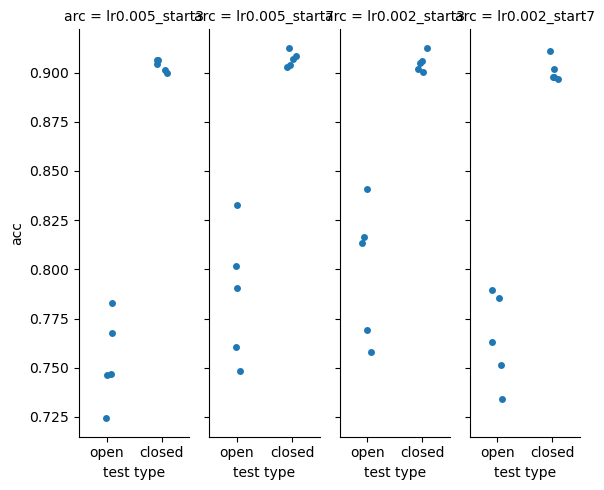

In [102]:
sns.catplot(performance_df, x ='test type', y ='acc', col='arc', aspect=0.3)

In [ ]:
swa_start = 3, learning_rate = 0.002